In [1]:
 '''
Author information:
Joey R. Muffoletto
University of Texas at Austin
Autonomous Systems Group
jrmuff@utexas.edu
'''

'\nAuthor information:\nJoey R. Muffoletto\nUniversity of Texas at Austin\nAutonomous Systems Group\njrmuff@utexas.edu\n'

In [2]:
import realtime_manager as rm 
import graph_manager as gm
import reworked_graph as rg
import copy
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz 2.44.1/bin'

c:\users\joey\appdata\local\programs\python\python37\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\users\joey\appdata\local\programs\python\python37\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
c:\users\joey\appdata\local\programs\python\python37\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


In [3]:
'''
manager configurations

traffic test globals
'''
NUM_TOWERS = 5
TAU_MAX = 6
TAU = 4

LOW_TRAFFIC_MULTIPLIER = 1
HIGH_TRAFFIC_MULTIPLIER = 4

MIN_LOW_TRAFFIC = 0
MAX_LOW_TRAFFIC = LOW_TRAFFIC_MULTIPLIER * NUM_TOWERS

MIN_HIGH_TRAFFIC = MAX_LOW_TRAFFIC
MAX_HIGH_TRAFFIC = HIGH_TRAFFIC_MULTIPLIER * NUM_TOWERS

MIN_TTL = 2
MAX_TTL = 6

DEFAULT_EMPTY_STATE = rg.State((),(),{"0" : 6})
rm.configure_realtime(tau=TAU, override_default_empty_state=DEFAULT_EMPTY_STATE)

HIGH_TRAFFIC_FREQUENCY = .2 # use rand.random() = [0.0, 1.0], or, just add this value until = 1 then reset

NUM_TIME_STEPS = 40



In [4]:
'''
Input generation functions

low traffic is some random number between min_low_traffic and max_low_traffic, high traffic is the same with high

choose a random tower index everytime we add one

high traffic occurs everytime HIGH_TRAFFIC_FREQUENCY * TIME_STEPS is a whole number

TTL is a random number between MIN_TTL and MAX_TTL
'''
import random
random.seed(10)
def generate_traffic(min_traffic, max_traffic):
    additional_requests_dict = dict()
#     counter = 0
    requests_to_add = random.randint(min_traffic, max_traffic)
    for i in range(requests_to_add):
#         if counter == NUM_TOWERS:
#             counter = 0
#         tower_to_add_to = counter
#         counter+=1
        tower_to_add_to = random.randint(0, NUM_TOWERS-1) # NUM_TOWERS is OOB
        request_to_add = ('no_pref', random.randint(MIN_TTL, MAX_TTL))
#         request_to_add = ('no_pref', 5)
        if tower_to_add_to in additional_requests_dict:
            additional_requests_dict[tower_to_add_to].append(request_to_add)
        else:
            additional_requests_dict[tower_to_add_to] = [request_to_add]
    return additional_requests_dict
            
def generate_low_traffic():
    return generate_traffic(MIN_LOW_TRAFFIC, MAX_LOW_TRAFFIC)
    
def generate_high_traffic():
    return generate_traffic(MIN_HIGH_TRAFFIC, MAX_HIGH_TRAFFIC)

In [5]:
'''
Input Generation
'''
input = []
high_traffic_counter = 0
for time in range(NUM_TIME_STEPS):
    if high_traffic_counter == 1:
        high_traffic_counter = 0
        input.append([generate_high_traffic()])
    else:
        high_traffic_counter += HIGH_TRAFFIC_FREQUENCY
        input.append([generate_low_traffic()])
        
initial_system = [copy.deepcopy(gm.return_tower(0, 1, [],[6])) for i in range(NUM_TOWERS)]

In [6]:
'''
Input statistics:
'''
requests_per_tower = [0 for i in range(NUM_TOWERS)]
for time_step in range(len(input)):
    for i in range(NUM_TOWERS):
        if i in input[time_step][0]:
            requests_per_tower[i]+=len(input[time_step][0][i])
for i in range(NUM_TOWERS):
    print("tower " + str(i) + "has " + str(requests_per_tower[i]) + " requests")

tower 0has 37 requests
tower 1has 26 requests
tower 2has 30 requests
tower 3has 44 requests
tower 4has 29 requests


In [7]:
'''
INPUT SAVING (DO NOT RE-RUN WILLY NILLY MY FRIEND)
'''
input_copy = copy.deepcopy(input)
# for _dict in input_copy:
#     print(_dict)

initial_system_copy = copy.deepcopy(initial_system)

In [8]:
'''
data collection
'''
_completed_states_per_tau = [[] for i in range(TAU_MAX)]
_timing_info_per_tau = [[] for i in range(TAU_MAX)]
for _tau in range(TAU_MAX):
    rm.configure_realtime(tau=_tau, override_default_empty_state=DEFAULT_EMPTY_STATE)
    traces, timings = rm.main_loop(initial_system_copy, copy.deepcopy(input_copy))
    _completed_states_per_tau[_tau] = copy.deepcopy(traces)
    _timing_info_per_tau[_tau] = copy.deepcopy(timings)
    gm.reset_globals()
#     print(traces)
    # _completed_states, _timing_info = rm.main_loop(initial_system_copy, input_copy)


40
[[State currently has requests :: ('no_pref', 'no_pref') Time states of :: (5, 3) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: ('no_pref',) Time states of :: (4,) Port states of :: {'0': 5} Labels :: ('VALID',)  
, State currently has requests :: ('no_pref',) Time states of :: (3,) Port states of :: {'0': 4} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 3} Labels :: ('VALID', 'FINISH')  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
, State currently has requests :: ('no_pref', 'no_pref', 'no_pref', 'no_pref', 'no_pref') Time states of :: (6, 3, 5, 6, 3) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: ('no_pref', 'no_pref', 'no_pref', 'no_pref', 'no_pref') Time states of :: (5, 2, 4, 5, 2) Port states of :: {'0': 5} Labels :: ('VALID',)  
, State currently has requests :: ('no_pref

In [9]:
'''
data buffer (DO NOT RE-RUN WILLY-NILLY)
'''
completed_states = copy.deepcopy(_completed_states_per_tau)
timing_info = copy.deepcopy(_timing_info_per_tau)




In [10]:
'''
process data buffer
'''
percent_valid = [0 for i in range(len(completed_states[0]))]
percent_valid_per_tau = [percent_valid for i in range(TAU_MAX)]
for tau,completed in enumerate(completed_states):
    print(completed)
    print("\n\n\n\n\n\n")
    for index, com in enumerate(completed):
        for state in com:
            if("VALID" in state.labels):
                percent_valid_per_tau[tau][index] += 1

for tower_cost in percent_valid_per_tau:
    print(tower_cost)
    
# actual_percentages = [(i/len(completed_states[0])) for i in percent_valid]
# print(actual_percentages)

# mvp_output_per_tower
mvp_output_per_tower_per_tau = [rm.get_mvp_output(completed) for completed in completed_states]
for tau in mvp_output_per_tower_per_tau:
    for output in tau:
        gm.print_formatted_cost(output[0],format_override=True)
#     output[3].plot()
#     gm.print_formatted_trace_path(output[1])
for timings in timing_info:
    print(timings)
    

[[State currently has requests :: ('no_pref', 'no_pref') Time states of :: (5, 3) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: ('no_pref',) Time states of :: (4,) Port states of :: {'0': 5} Labels :: ('VALID',)  
, State currently has requests :: ('no_pref',) Time states of :: (3,) Port states of :: {'0': 4} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 3} Labels :: ('VALID', 'FINISH')  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
, State currently has requests :: ('no_pref', 'no_pref', 'no_pref', 'no_pref', 'no_pref') Time states of :: (6, 3, 5, 6, 3) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: ('no_pref', 'no_pref', 'no_pref', 'no_pref', 'no_pref') Time states of :: (5, 2, 4, 5, 2) Port states of :: {'0': 5} Labels :: ('VALID',)  
, State currently has requests :: ('no_pref', 

Path cost [0, 24, 45]
Path cost [0, 2, 45]
Path cost [0, 22, 45]
Path cost [27, 40, 45]
Path cost [0, 0, 45]
Path cost [0, 0, 0]
Path cost [0, 0, 0]
Path cost [0, 0, 0]
Path cost [0, 0, 0]
Path cost [0, 0, 0]
Path cost [0, 0, 0]
Path cost [0, 0, 0]
Path cost [0, 0, 0]
Path cost [0, 0, 0]
Path cost [0, 0, 0]
Path cost [0, 0, 0]
Path cost [0, 0, 0]
Path cost [0, 0, 0]
Path cost [0, 0, 0]
Path cost [0, 0, 0]
Path cost [0, 0, 0]
Path cost [0, 0, 0]
Path cost [0, 0, 0]
Path cost [0, 0, 0]
Path cost [0, 0, 0]
Path cost [0, 0, 0]
Path cost [0, 0, 0]
Path cost [0, 0, 0]
Path cost [0, 0, 0]
Path cost [0, 0, 0]
[0.006399499999999891, 0.00433030000000012, 0.0043455999999999495, 0.005832400000000071, 0.007406299999999977, 0.05115610000000004, 0.02417590000000014, 0.01134769999999996, 0.00594579999999989, 0.009845199999999998, 0.0031438999999999773, 0.23436880000000015, 0.12805109999999997, 1.600000000046009e-06, 0.034060200000000096, 0.009460799999999825, 0.03933739999999997, 0.39293829999999996, 

[51, 51, 51, 24, 51]
[51, 51, 51, 24, 51]
[51, 51, 51, 24, 51]
[51, 51, 51, 24, 51]
[51, 51, 51, 24, 51]
[51, 51, 51, 24, 51]
Path cost [0, 24, 45]


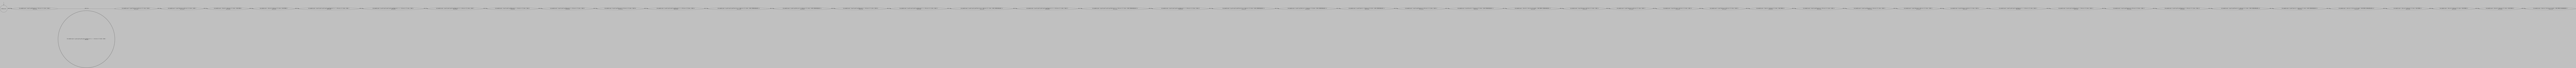

Path cost [0, 2, 45]


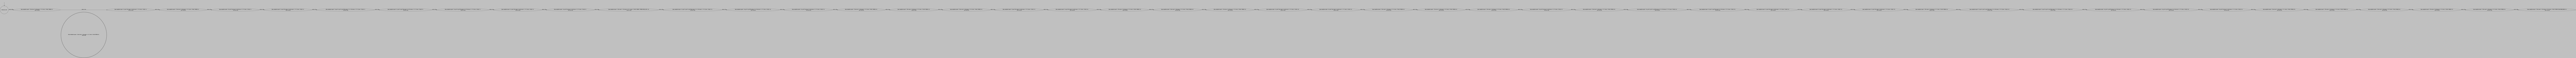

Path cost [0, 22, 45]


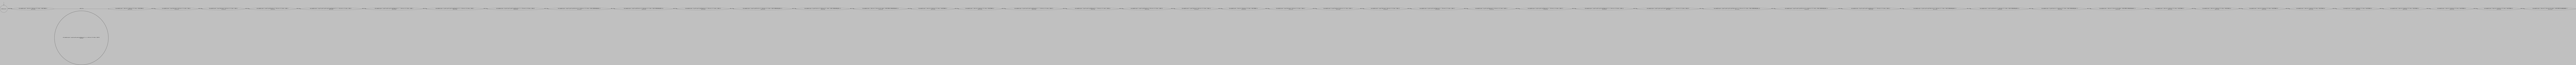

Path cost [27, 40, 45]


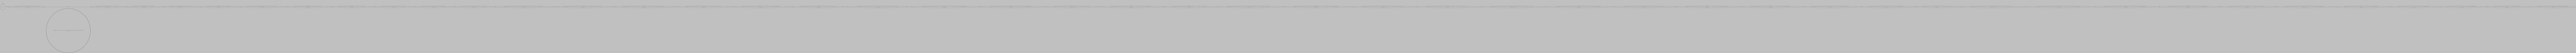

Path cost [0, 0, 45]


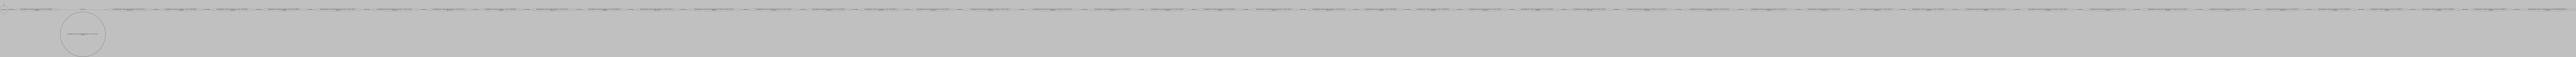

Path cost [0, 0, 0]


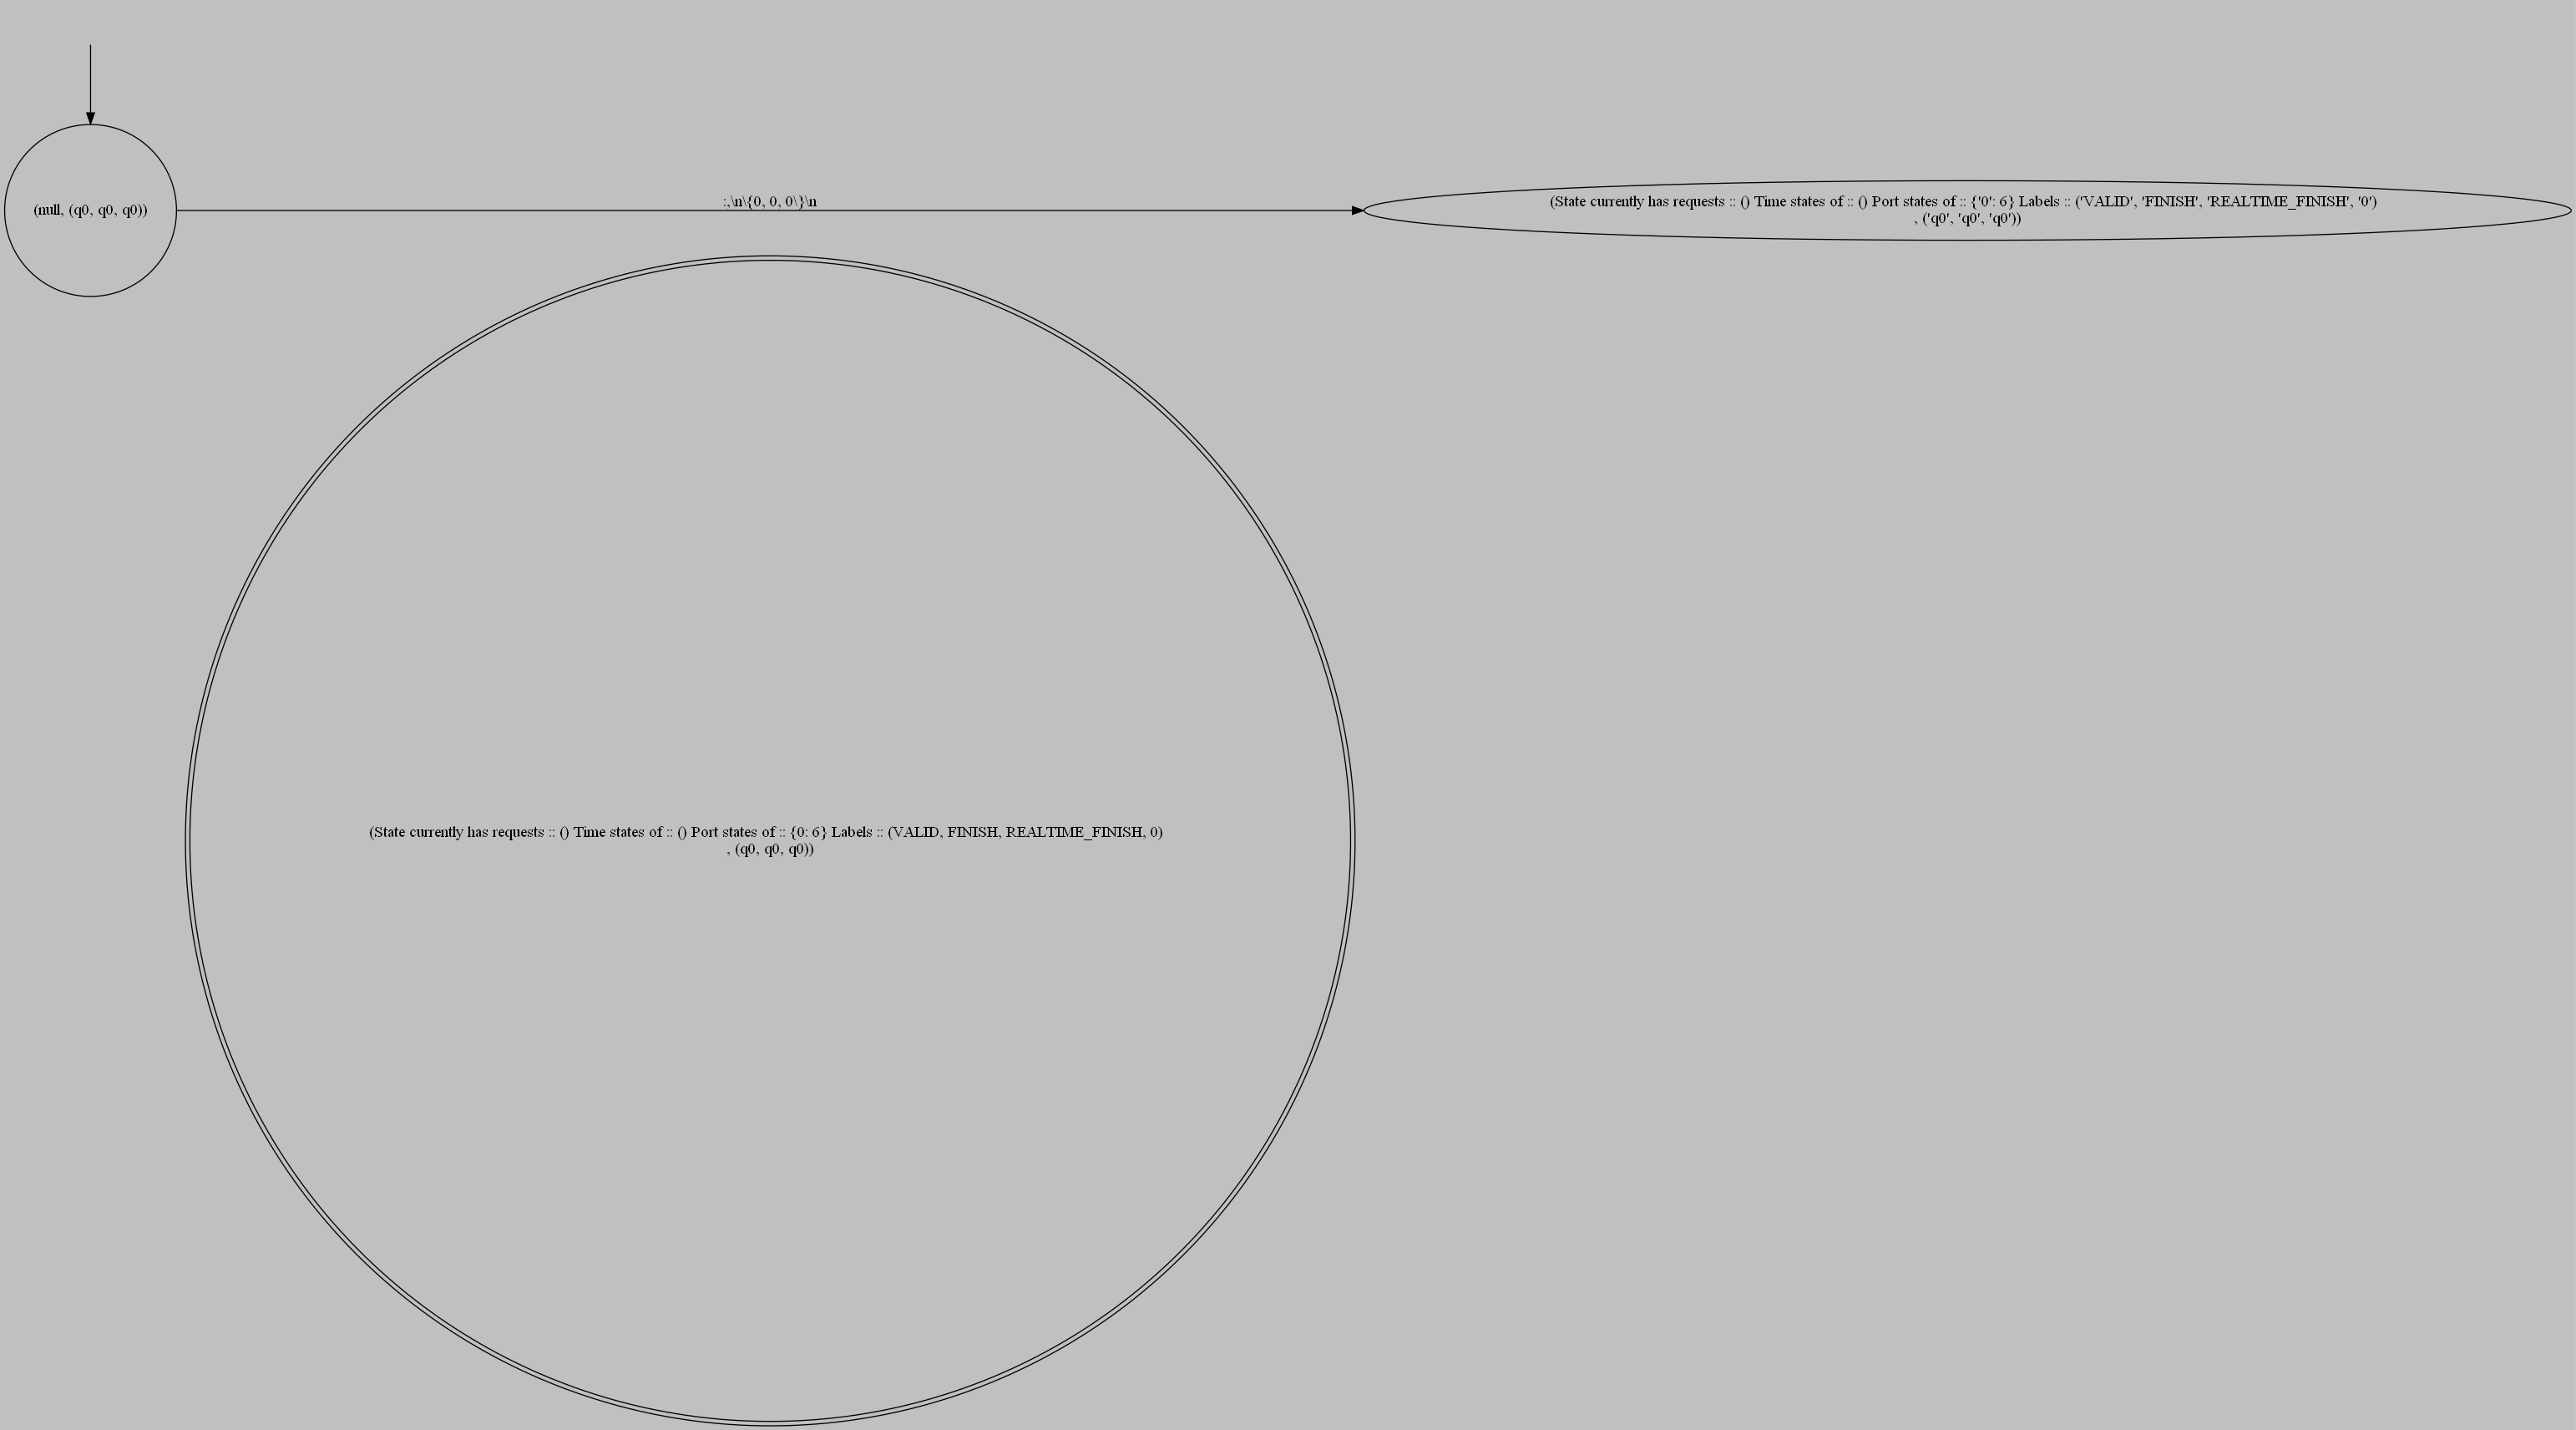

Path cost [0, 0, 0]


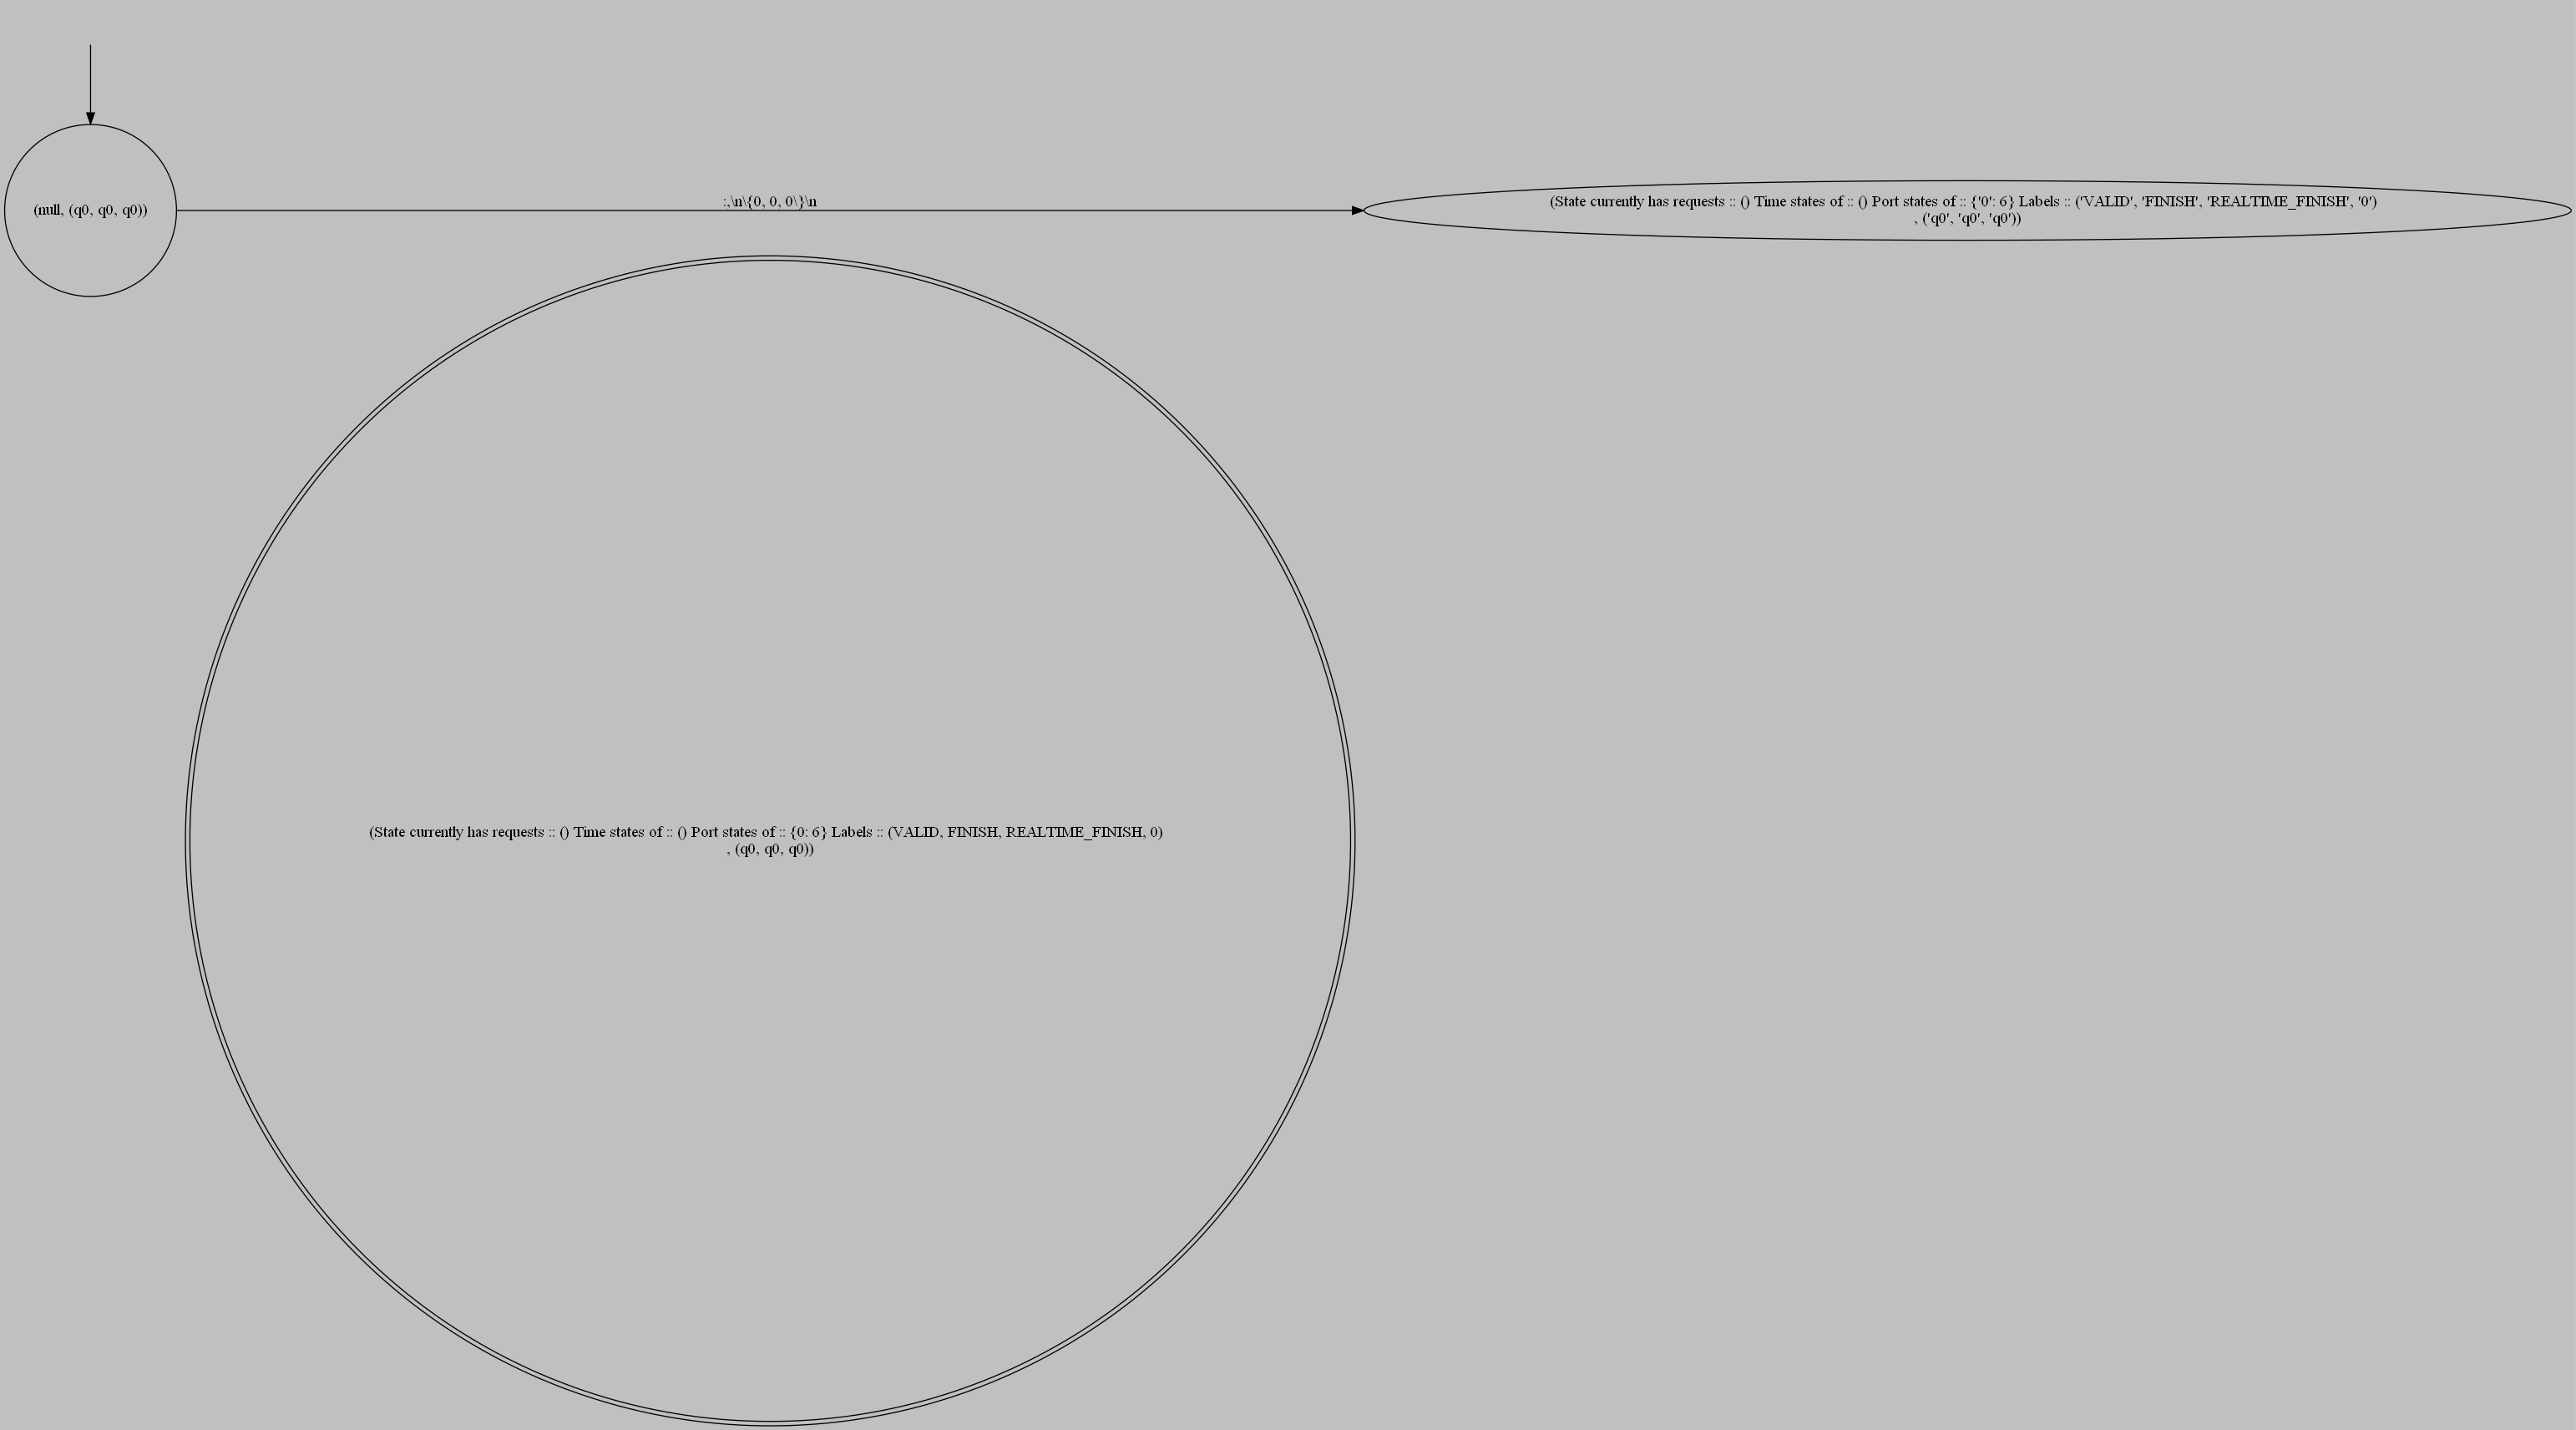

Path cost [0, 0, 0]


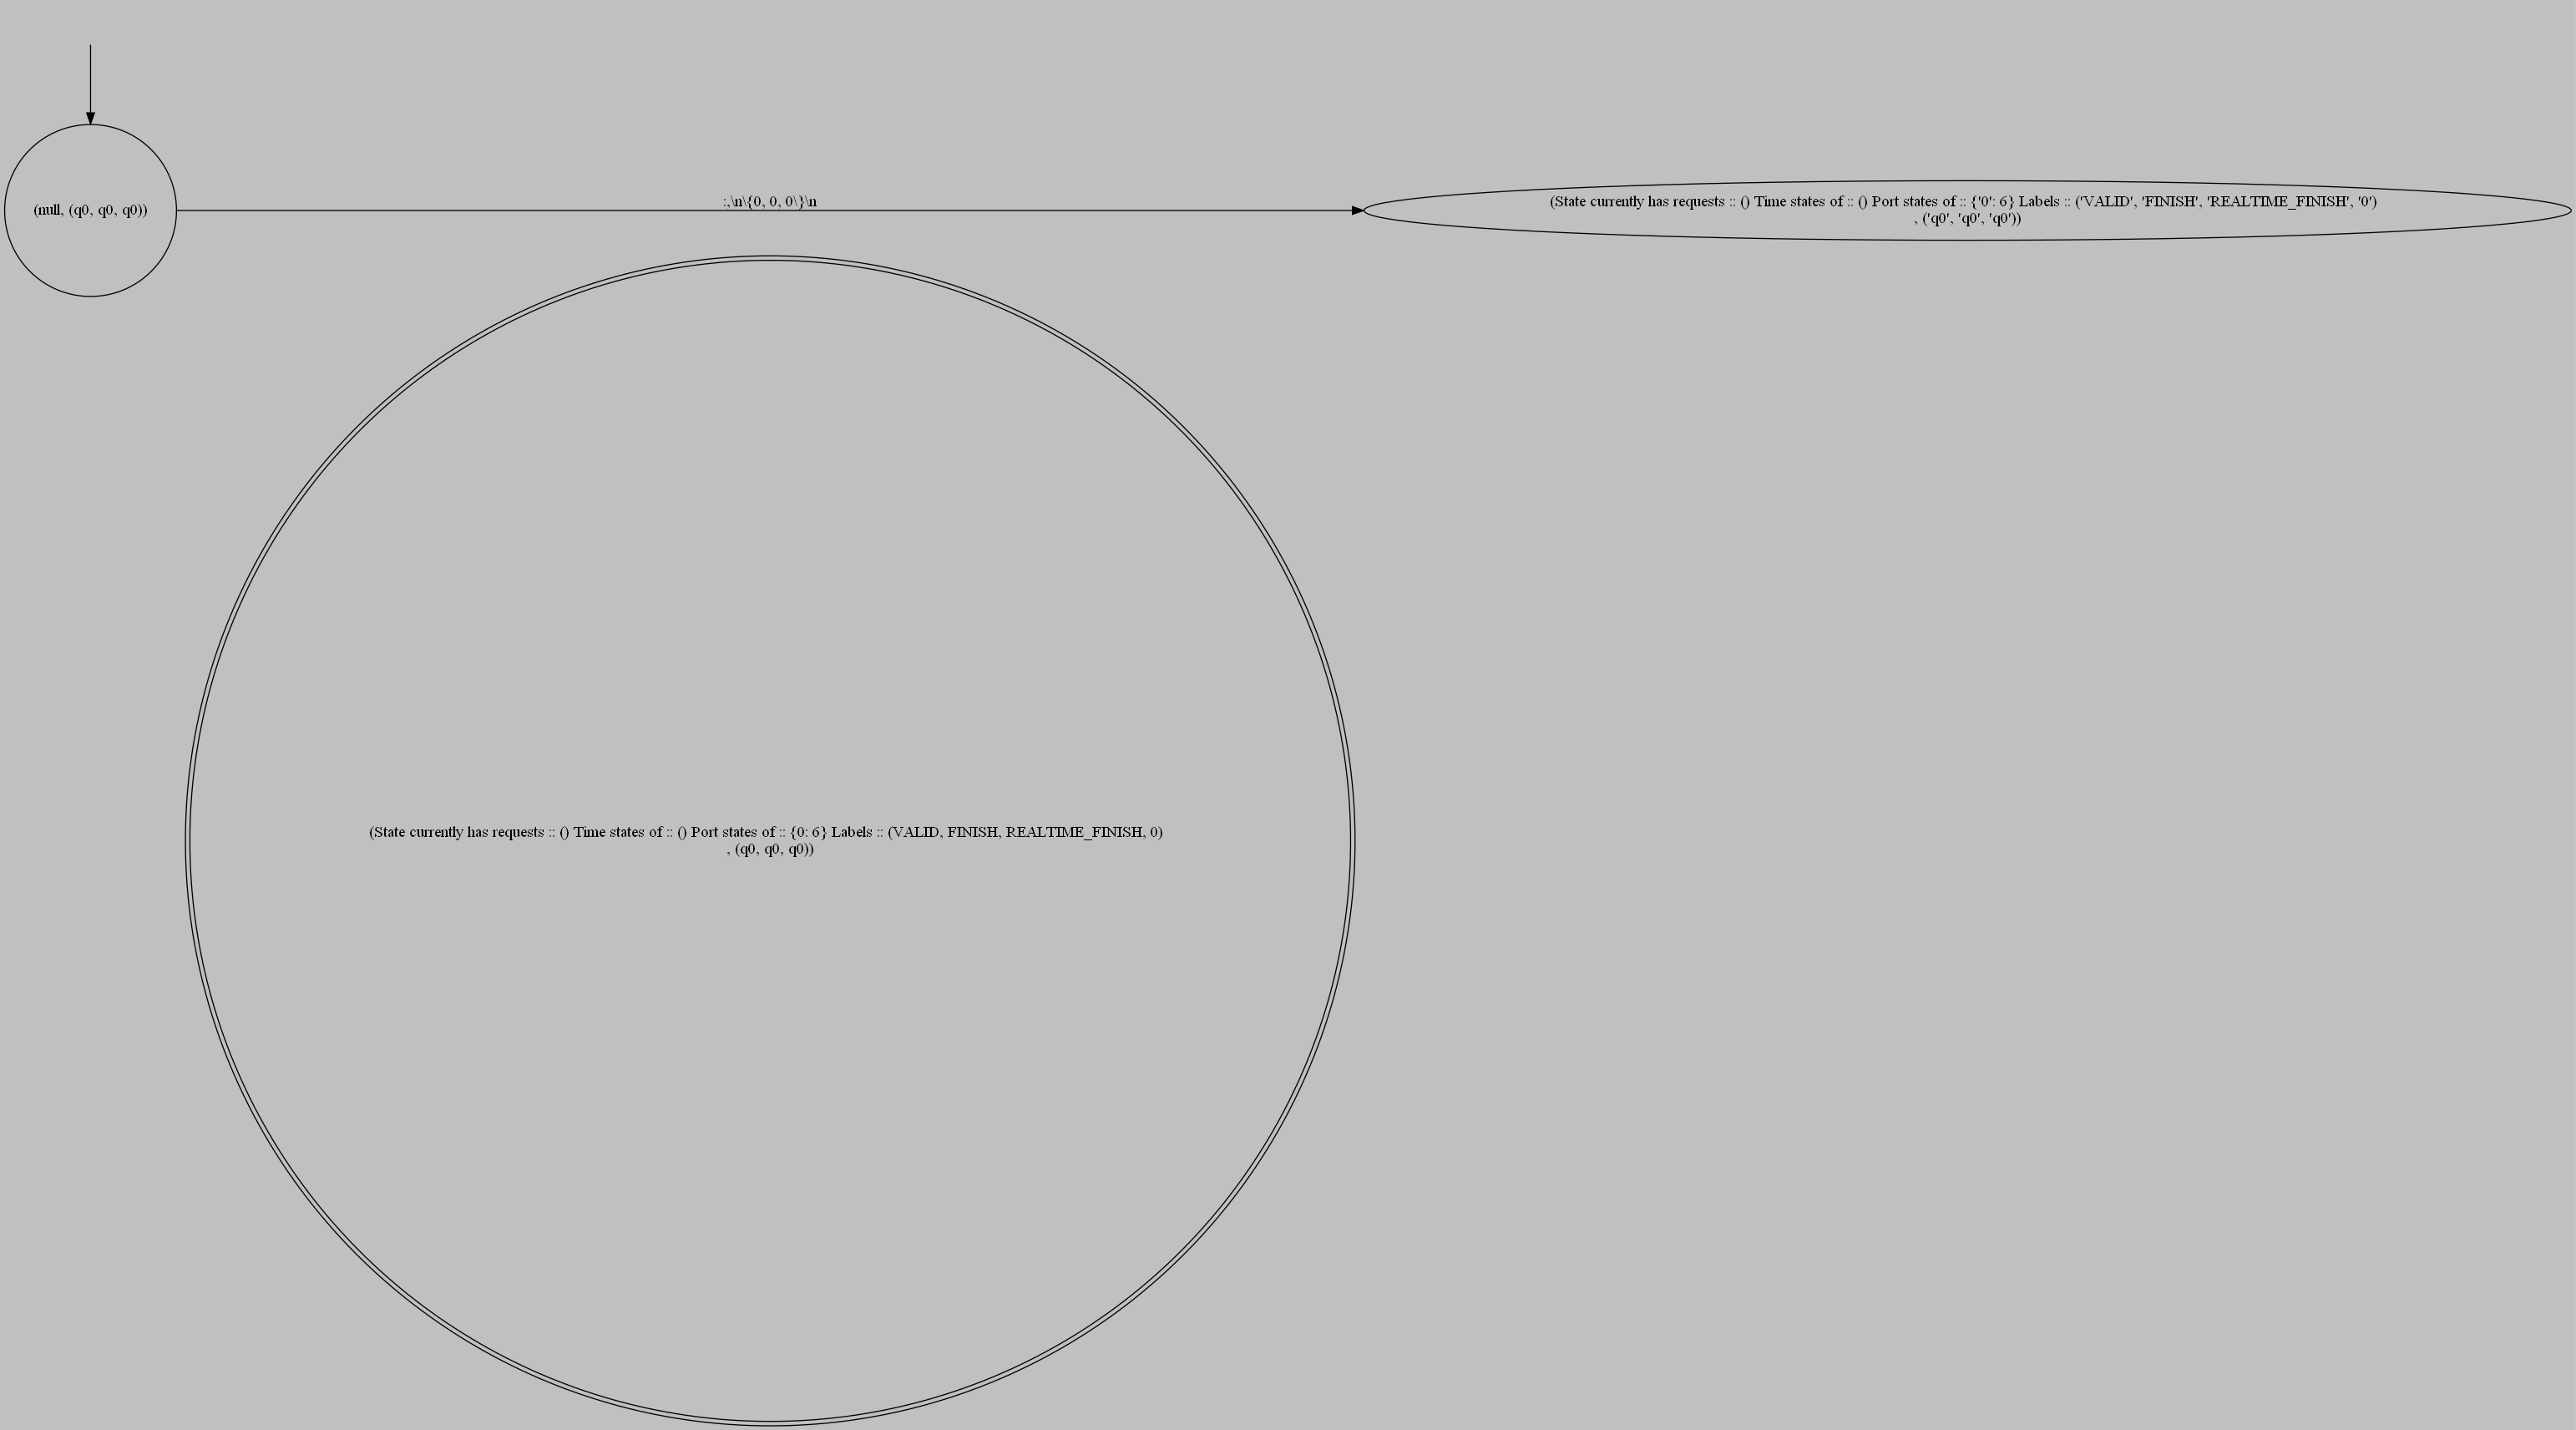

Path cost [0, 0, 0]


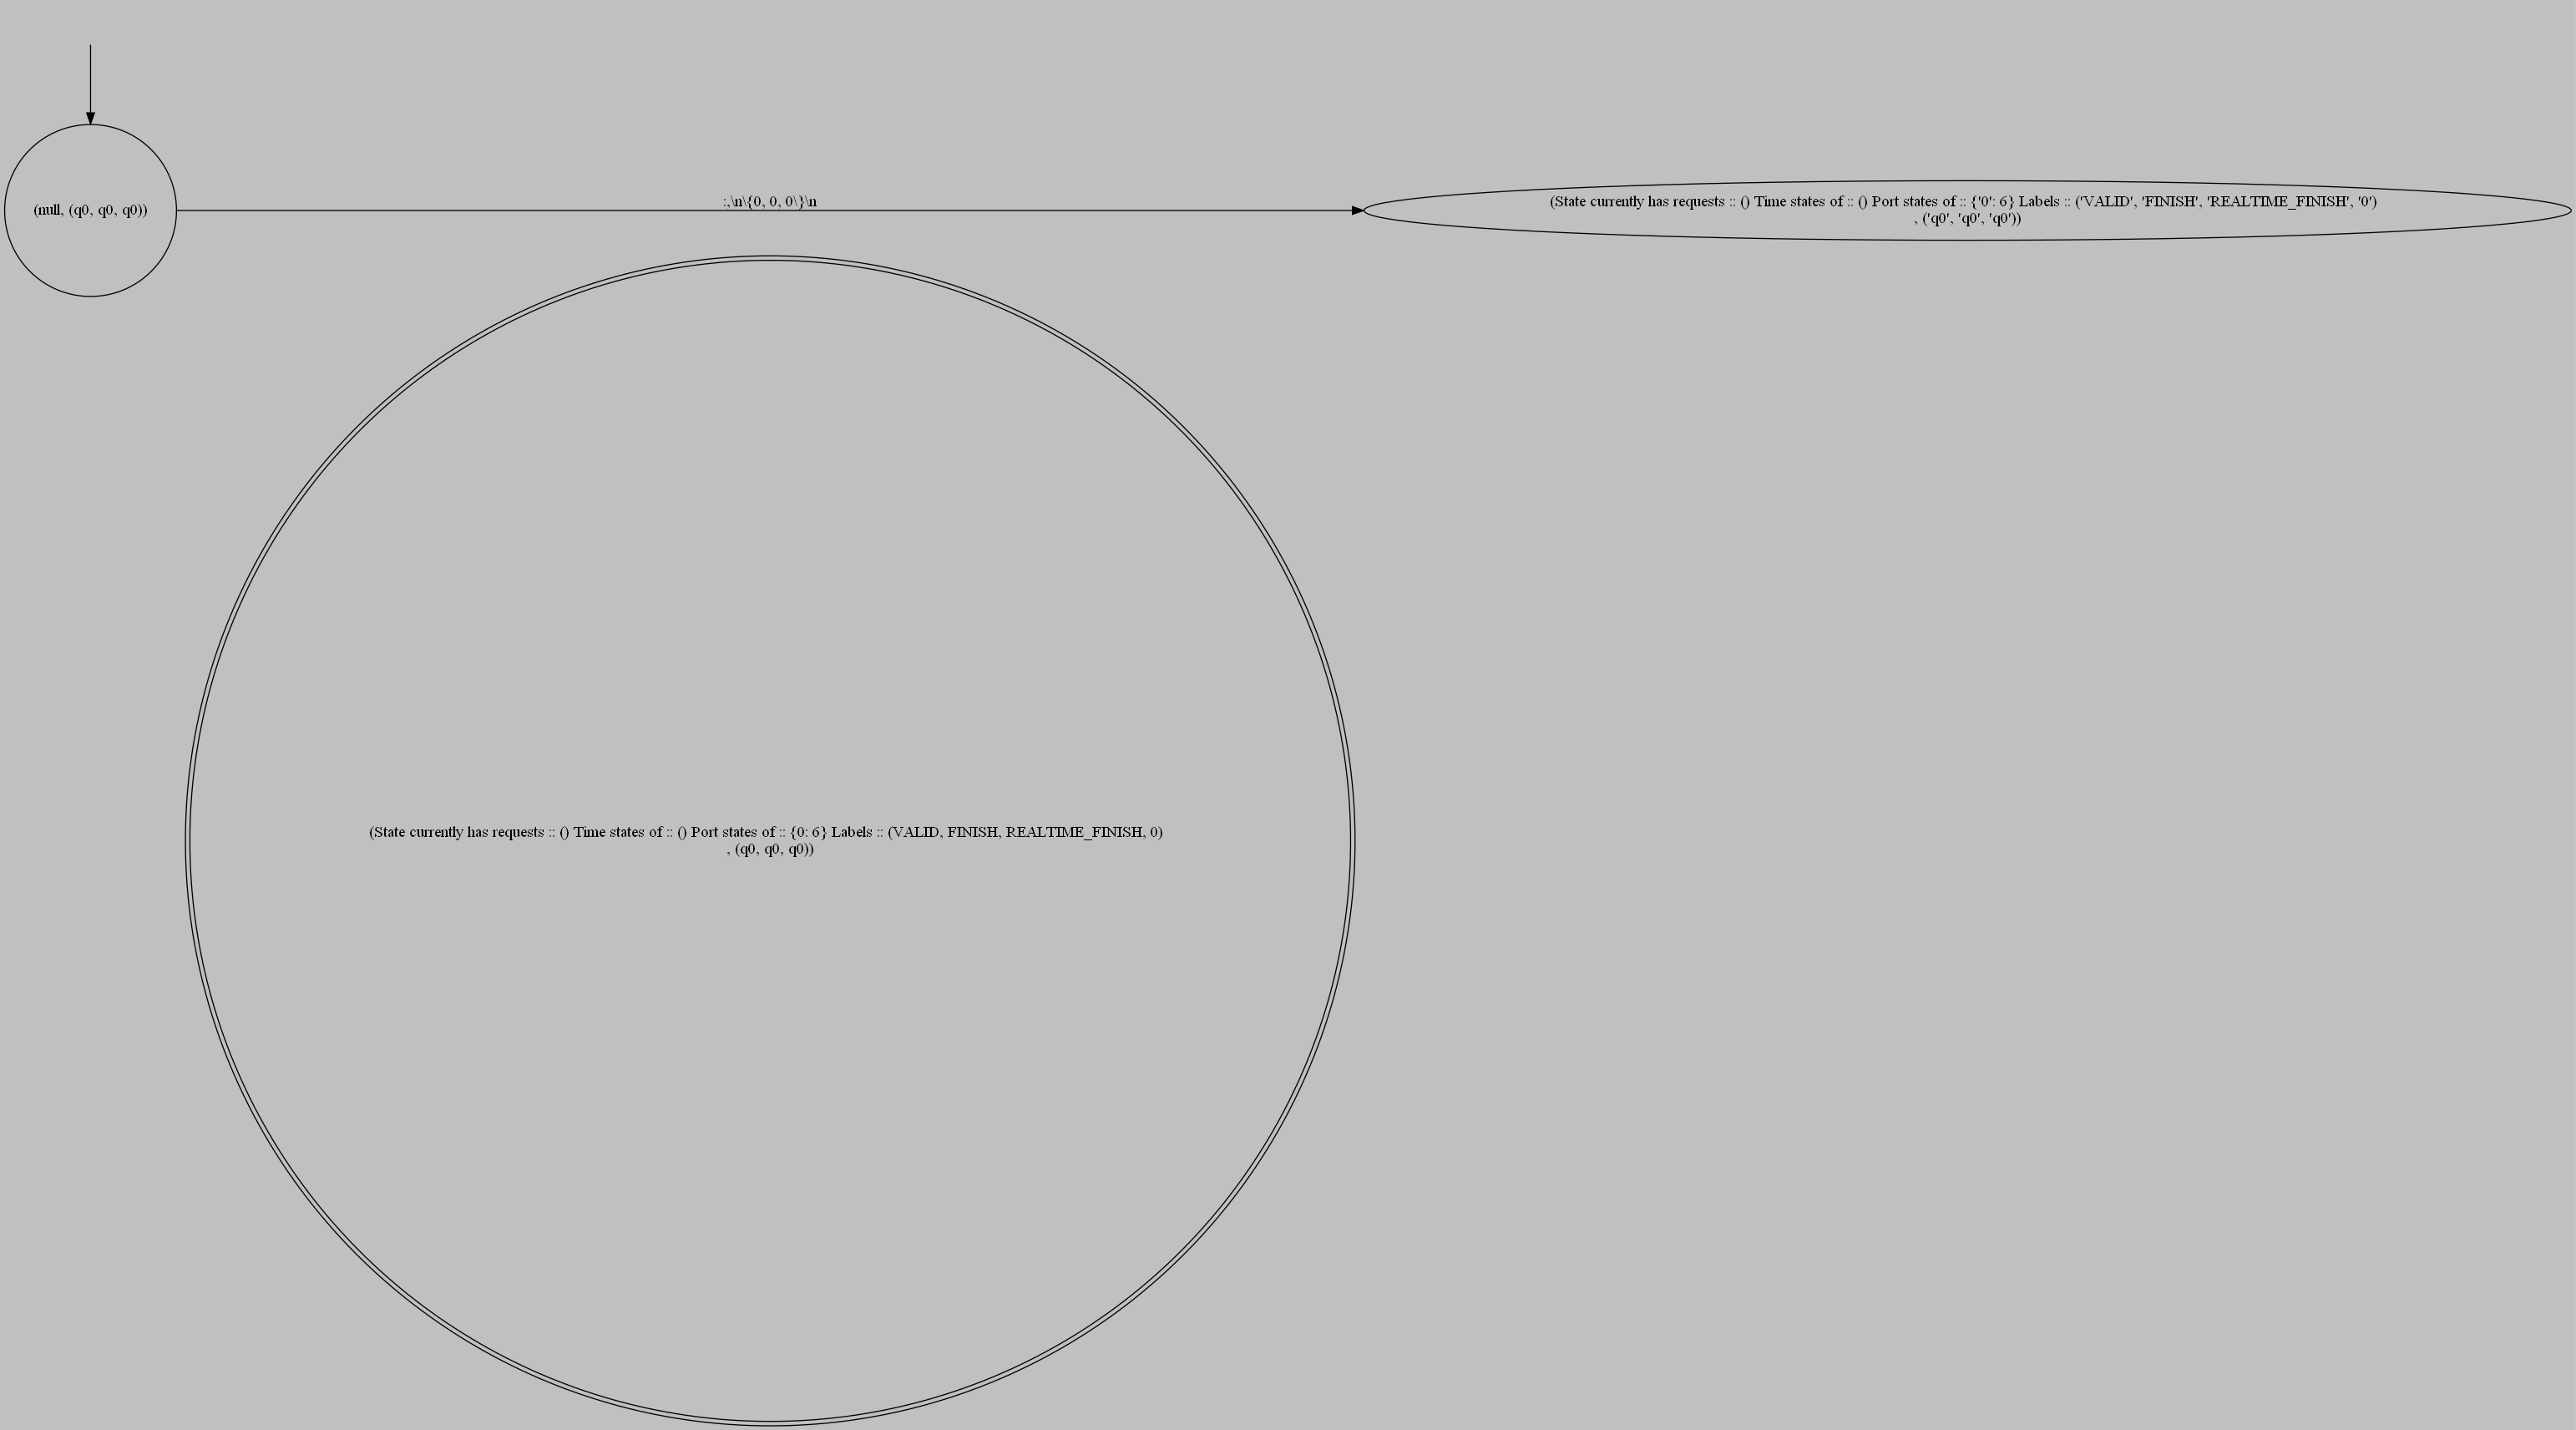

Path cost [0, 0, 0]


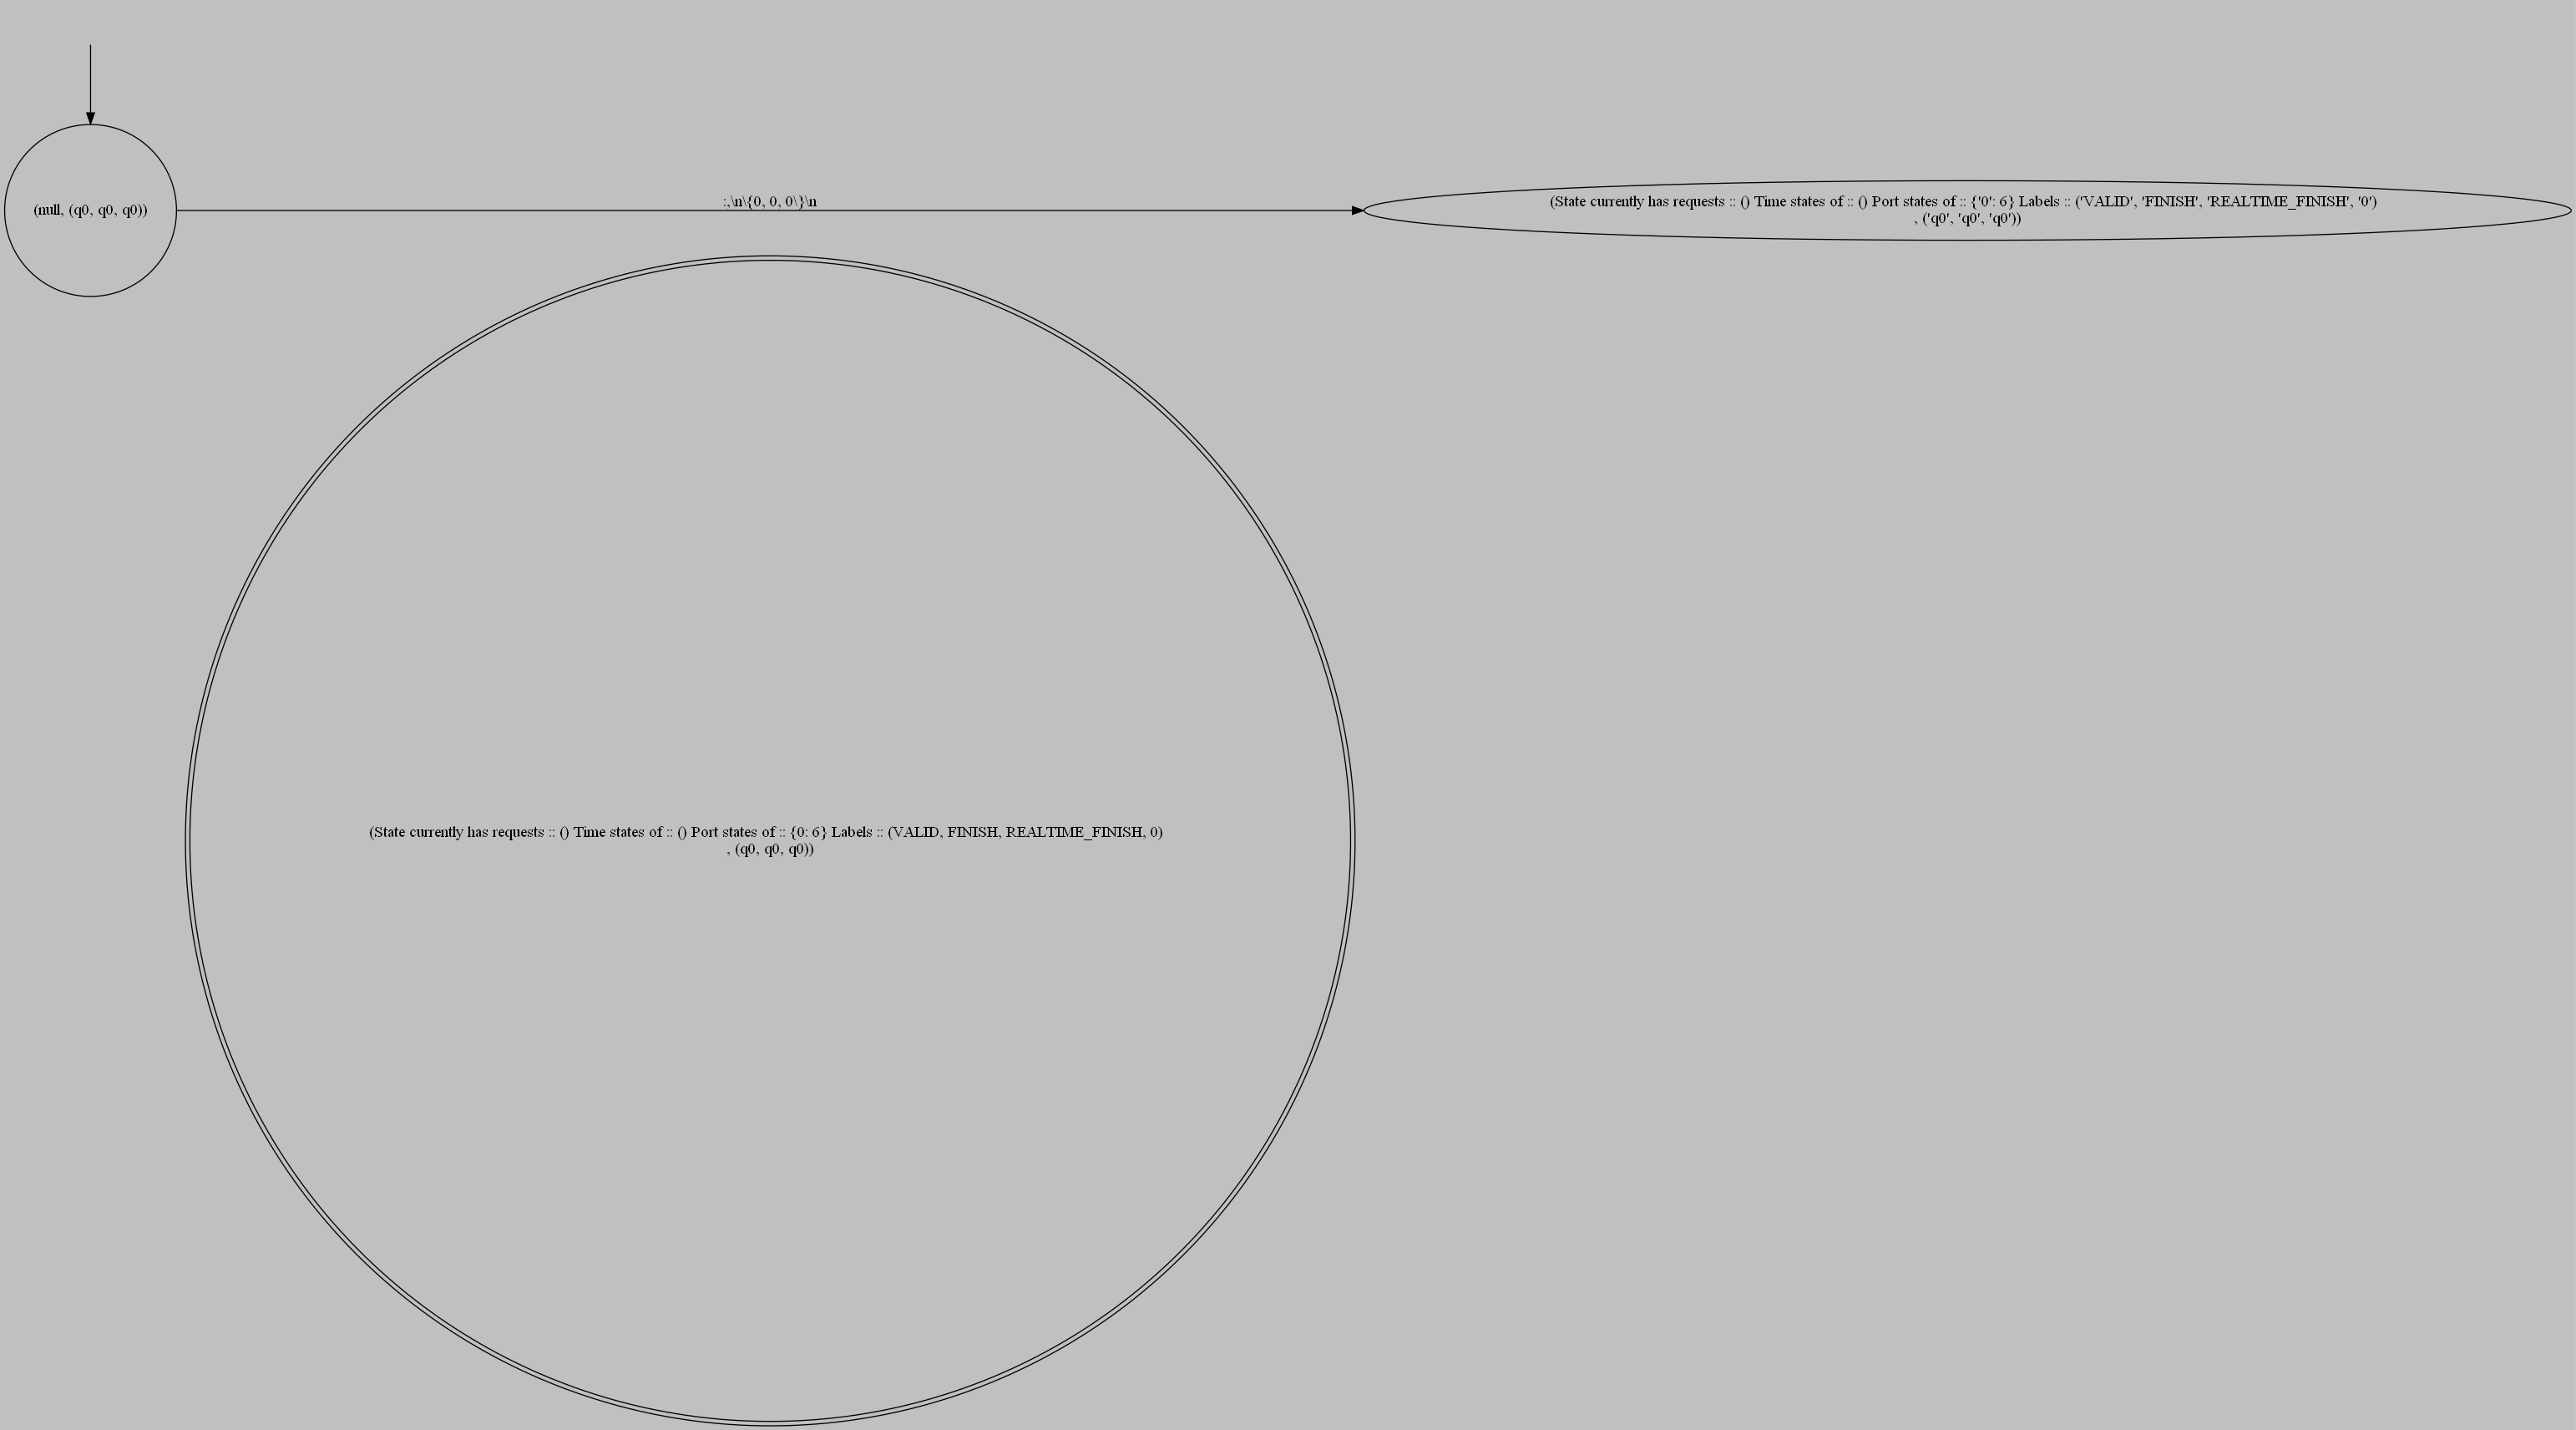

Path cost [0, 0, 0]


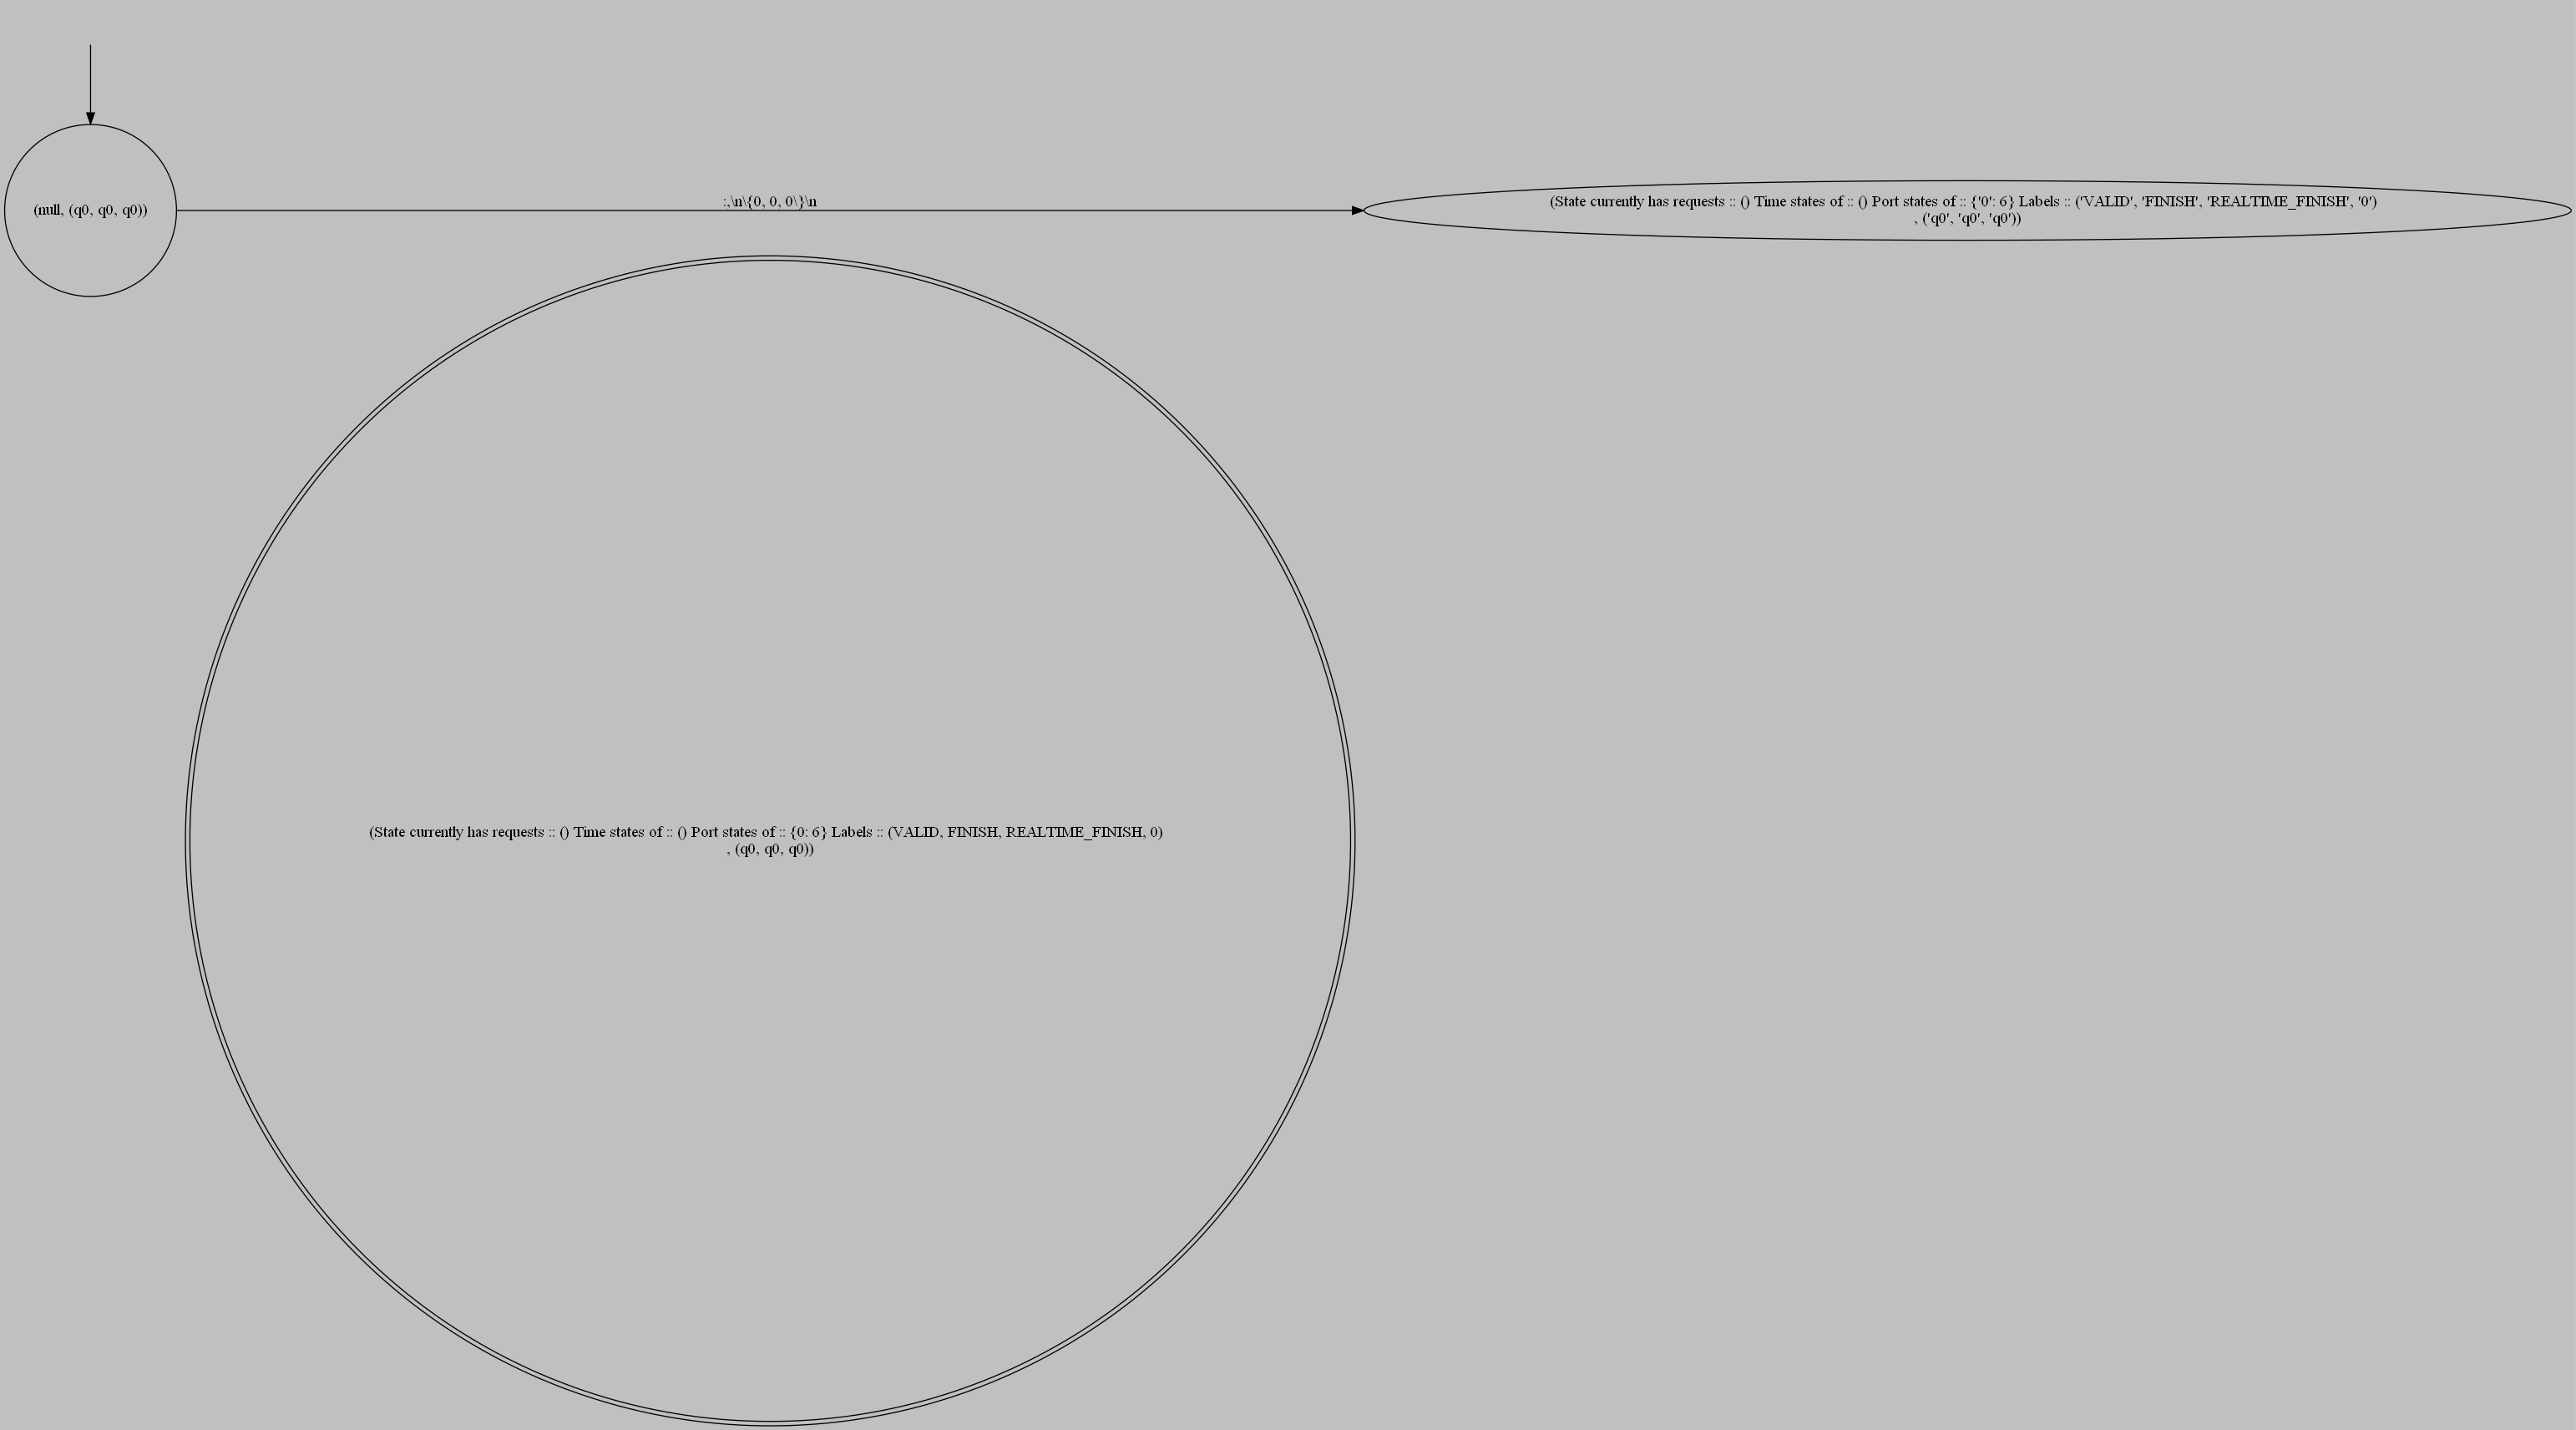

Path cost [0, 0, 0]


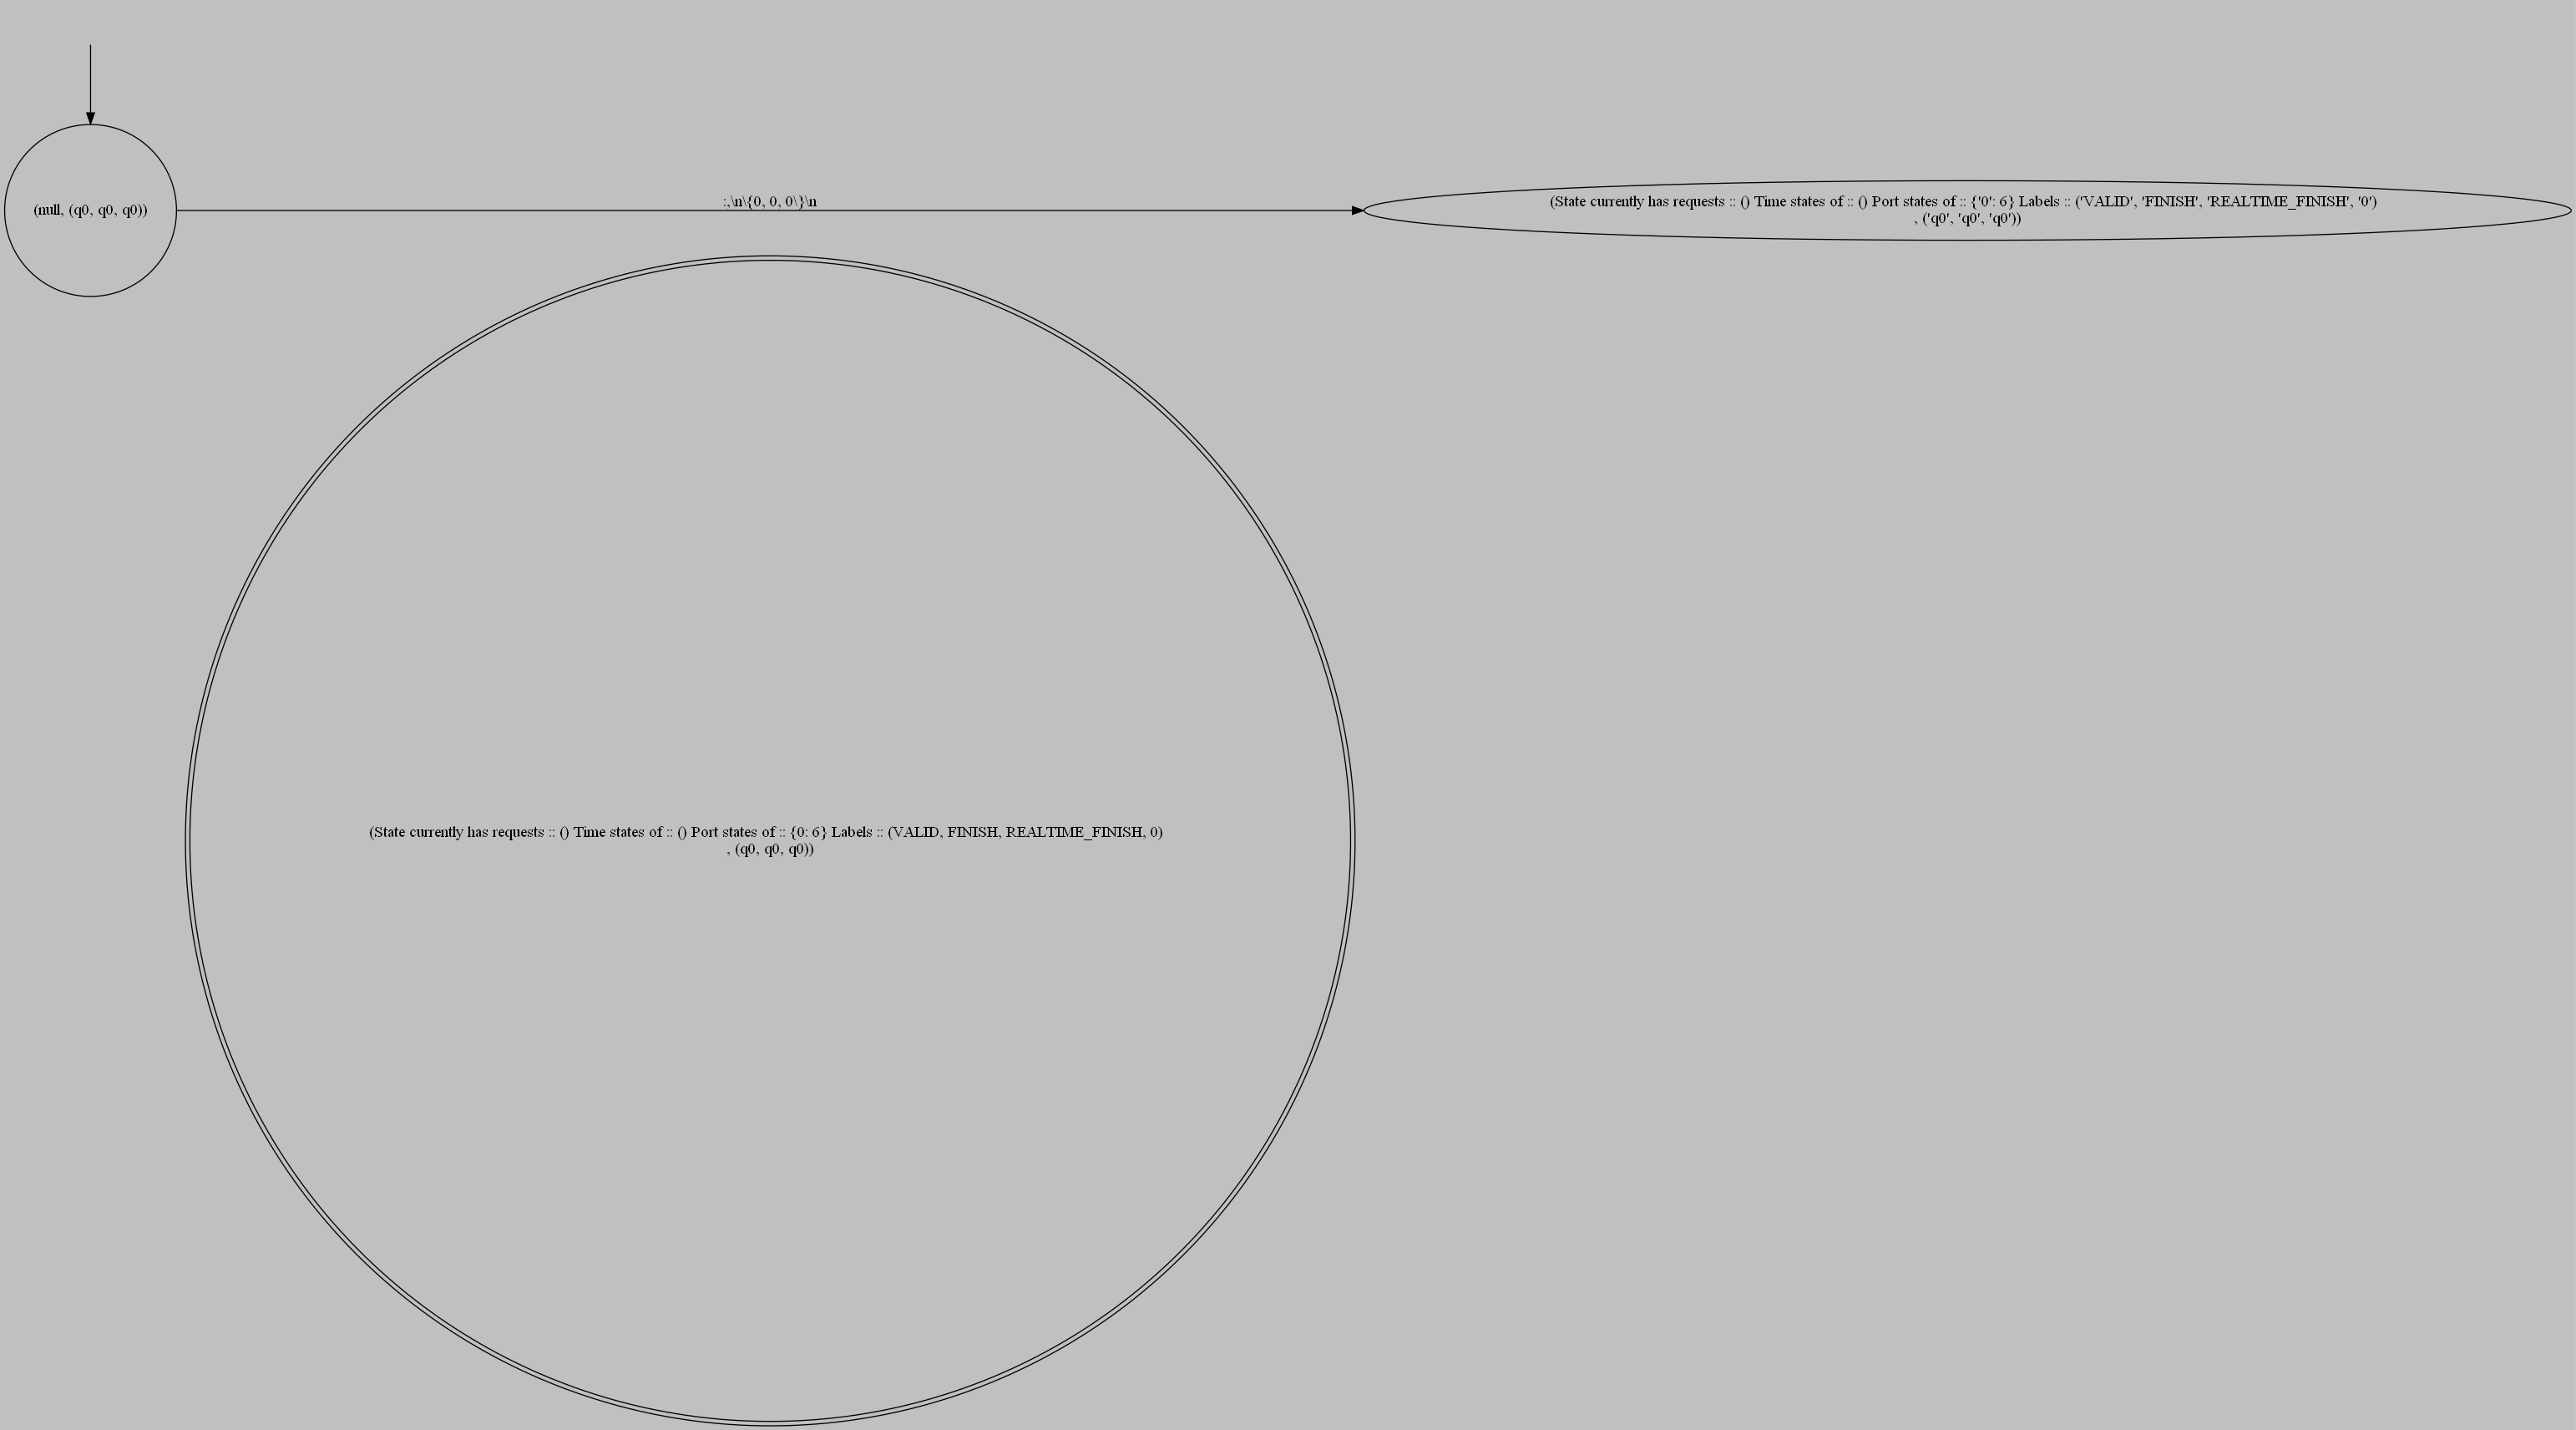

Path cost [0, 0, 0]


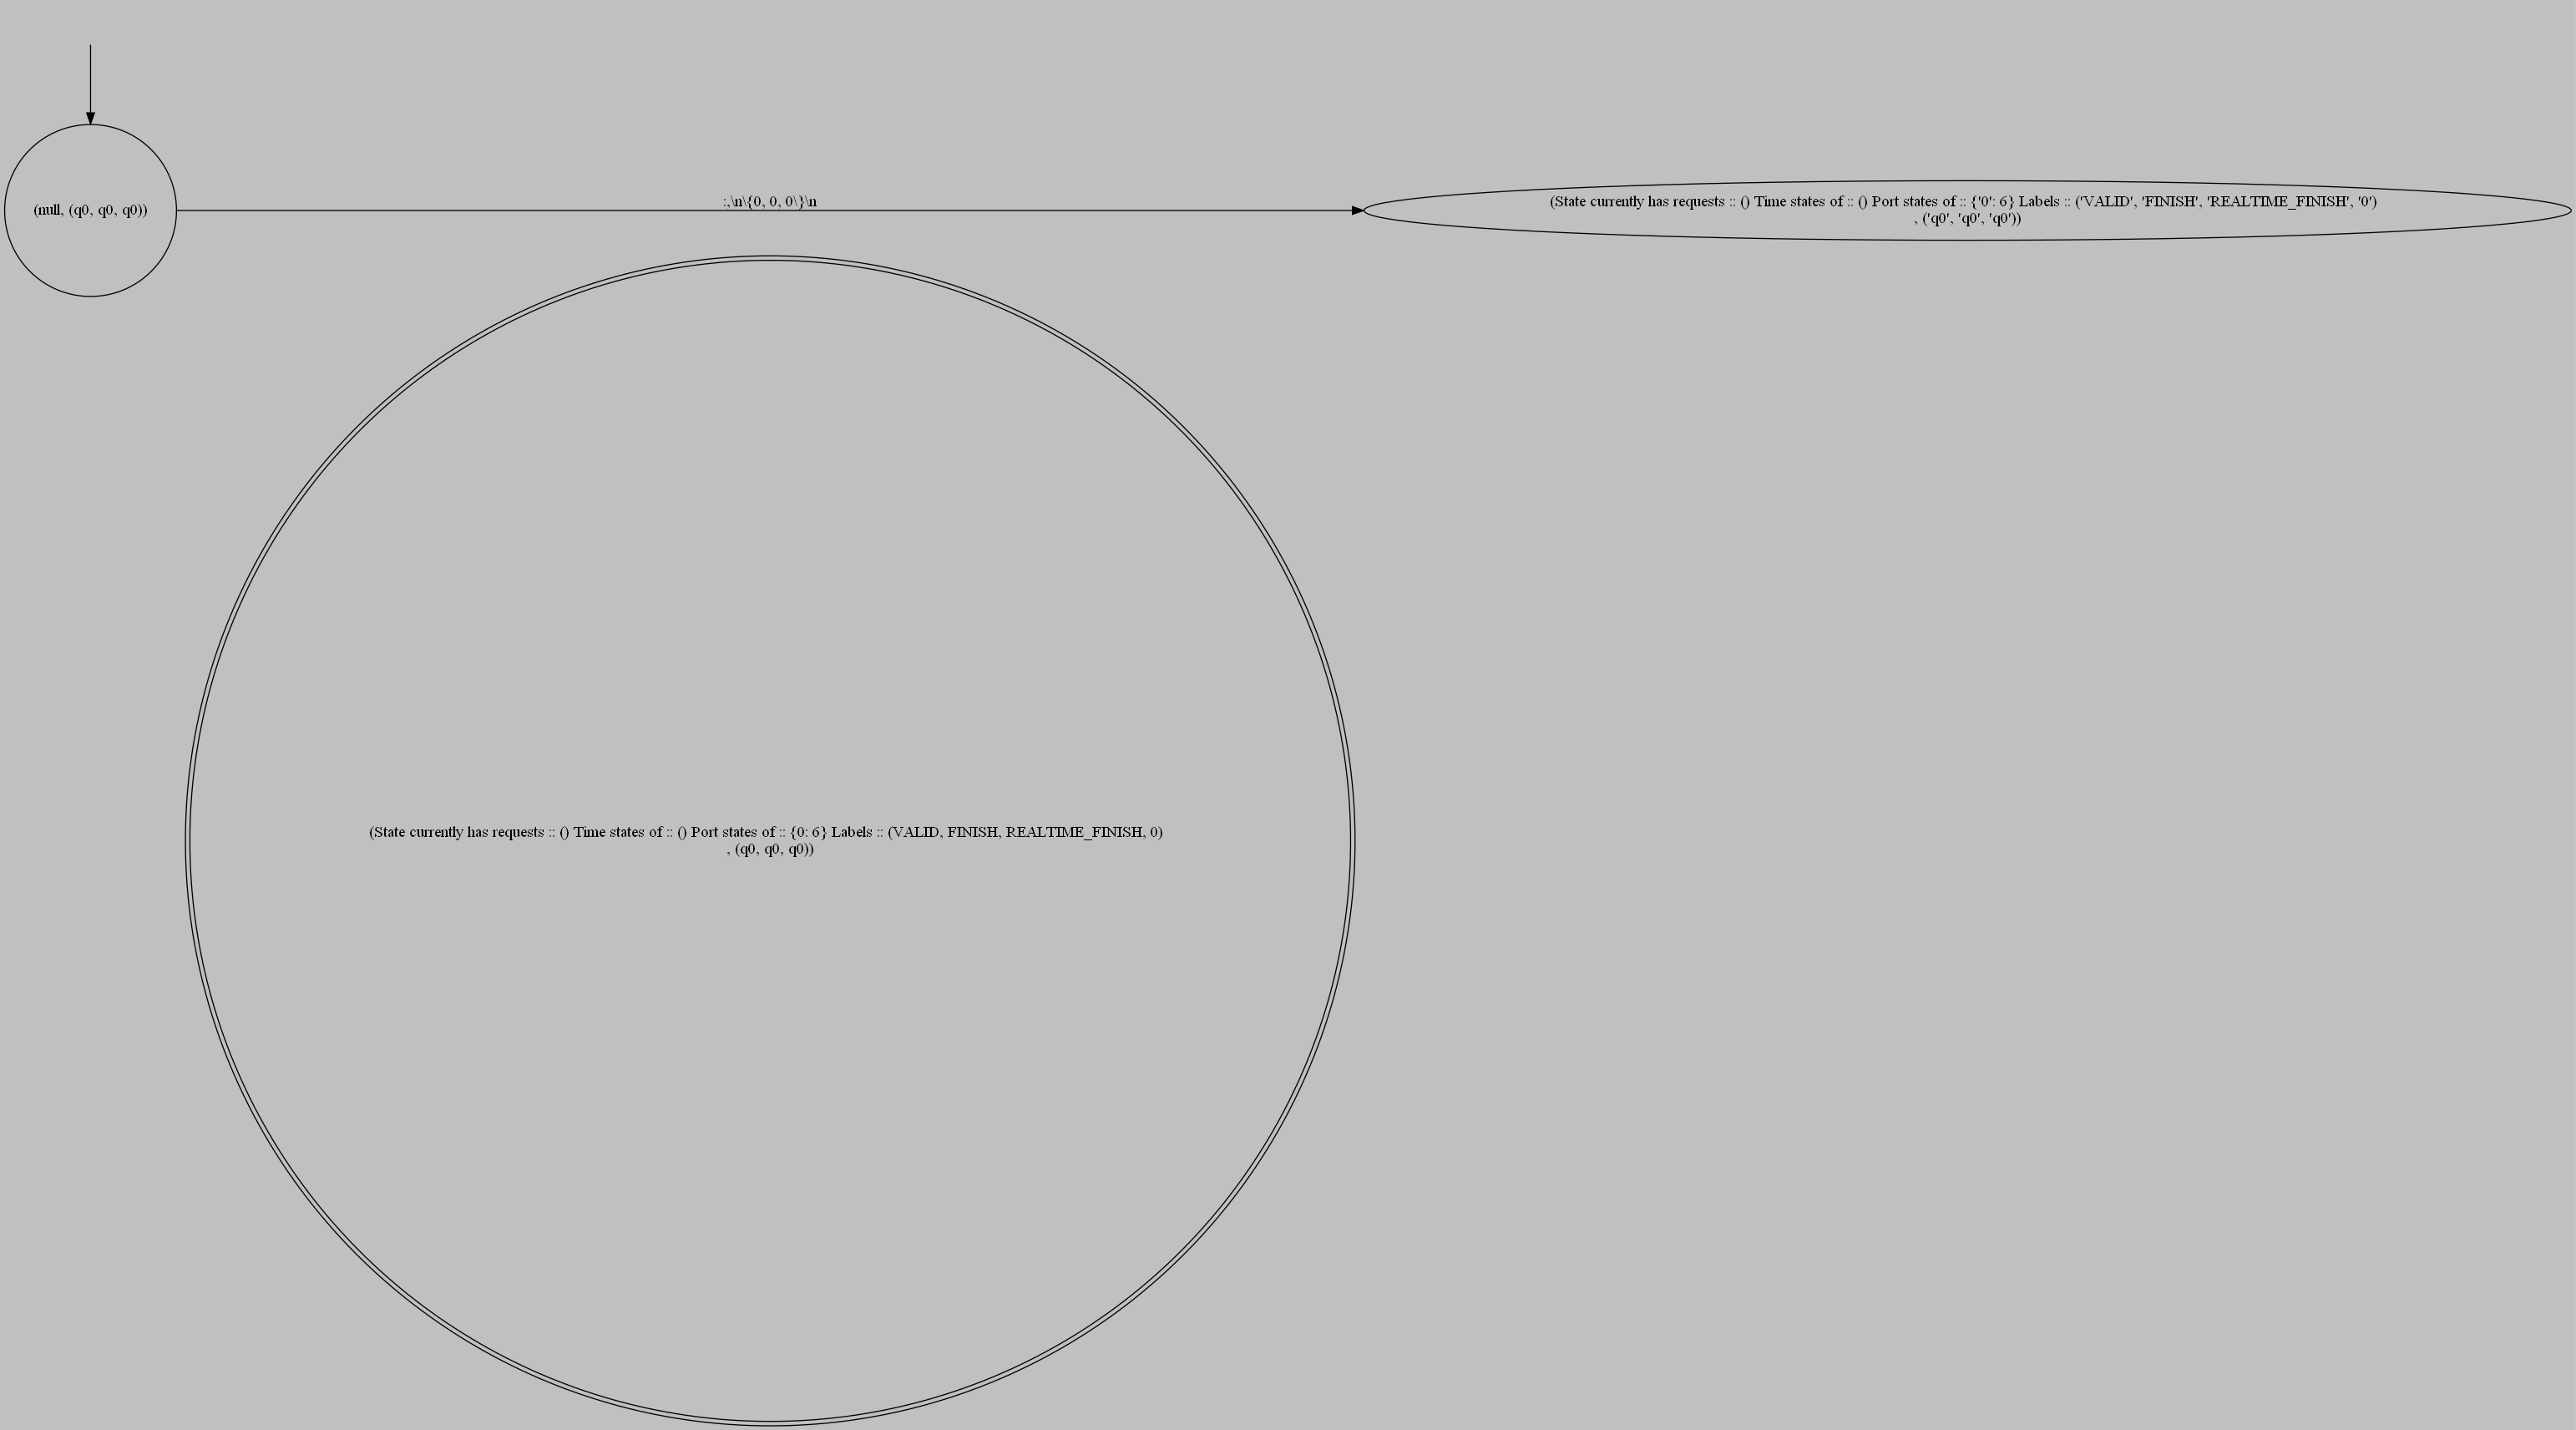

Path cost [0, 0, 0]


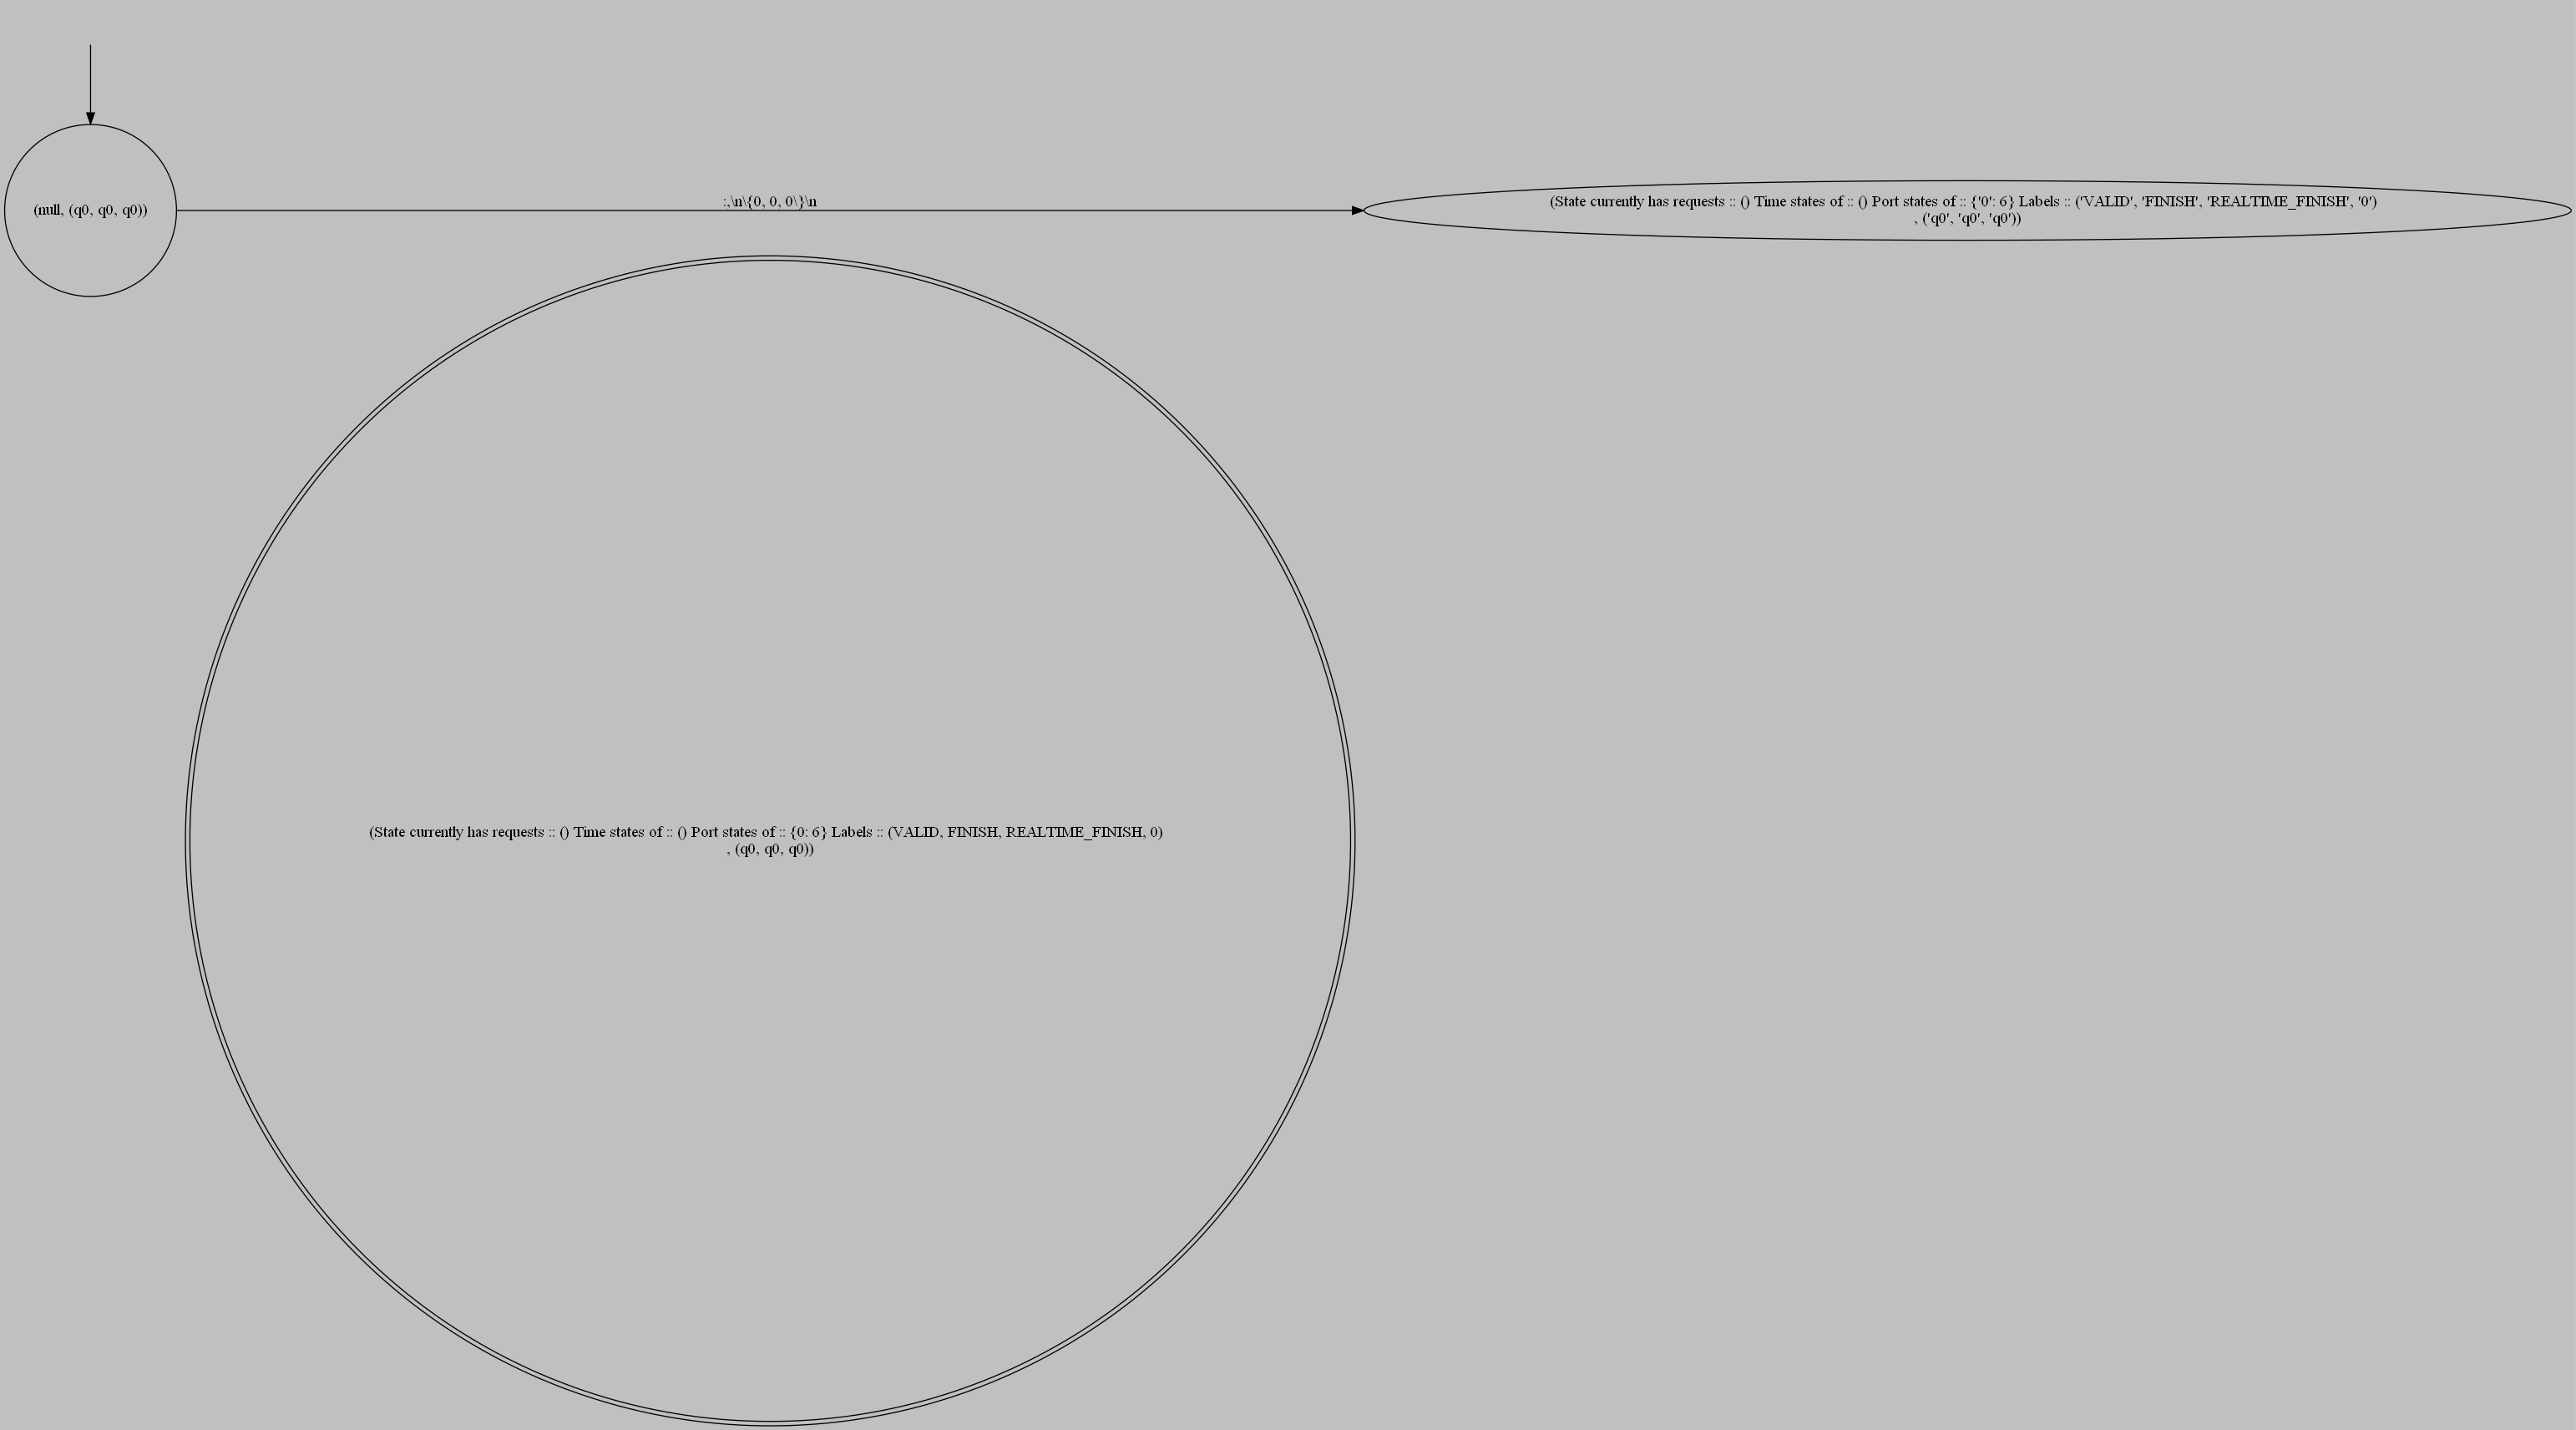

Path cost [0, 0, 0]


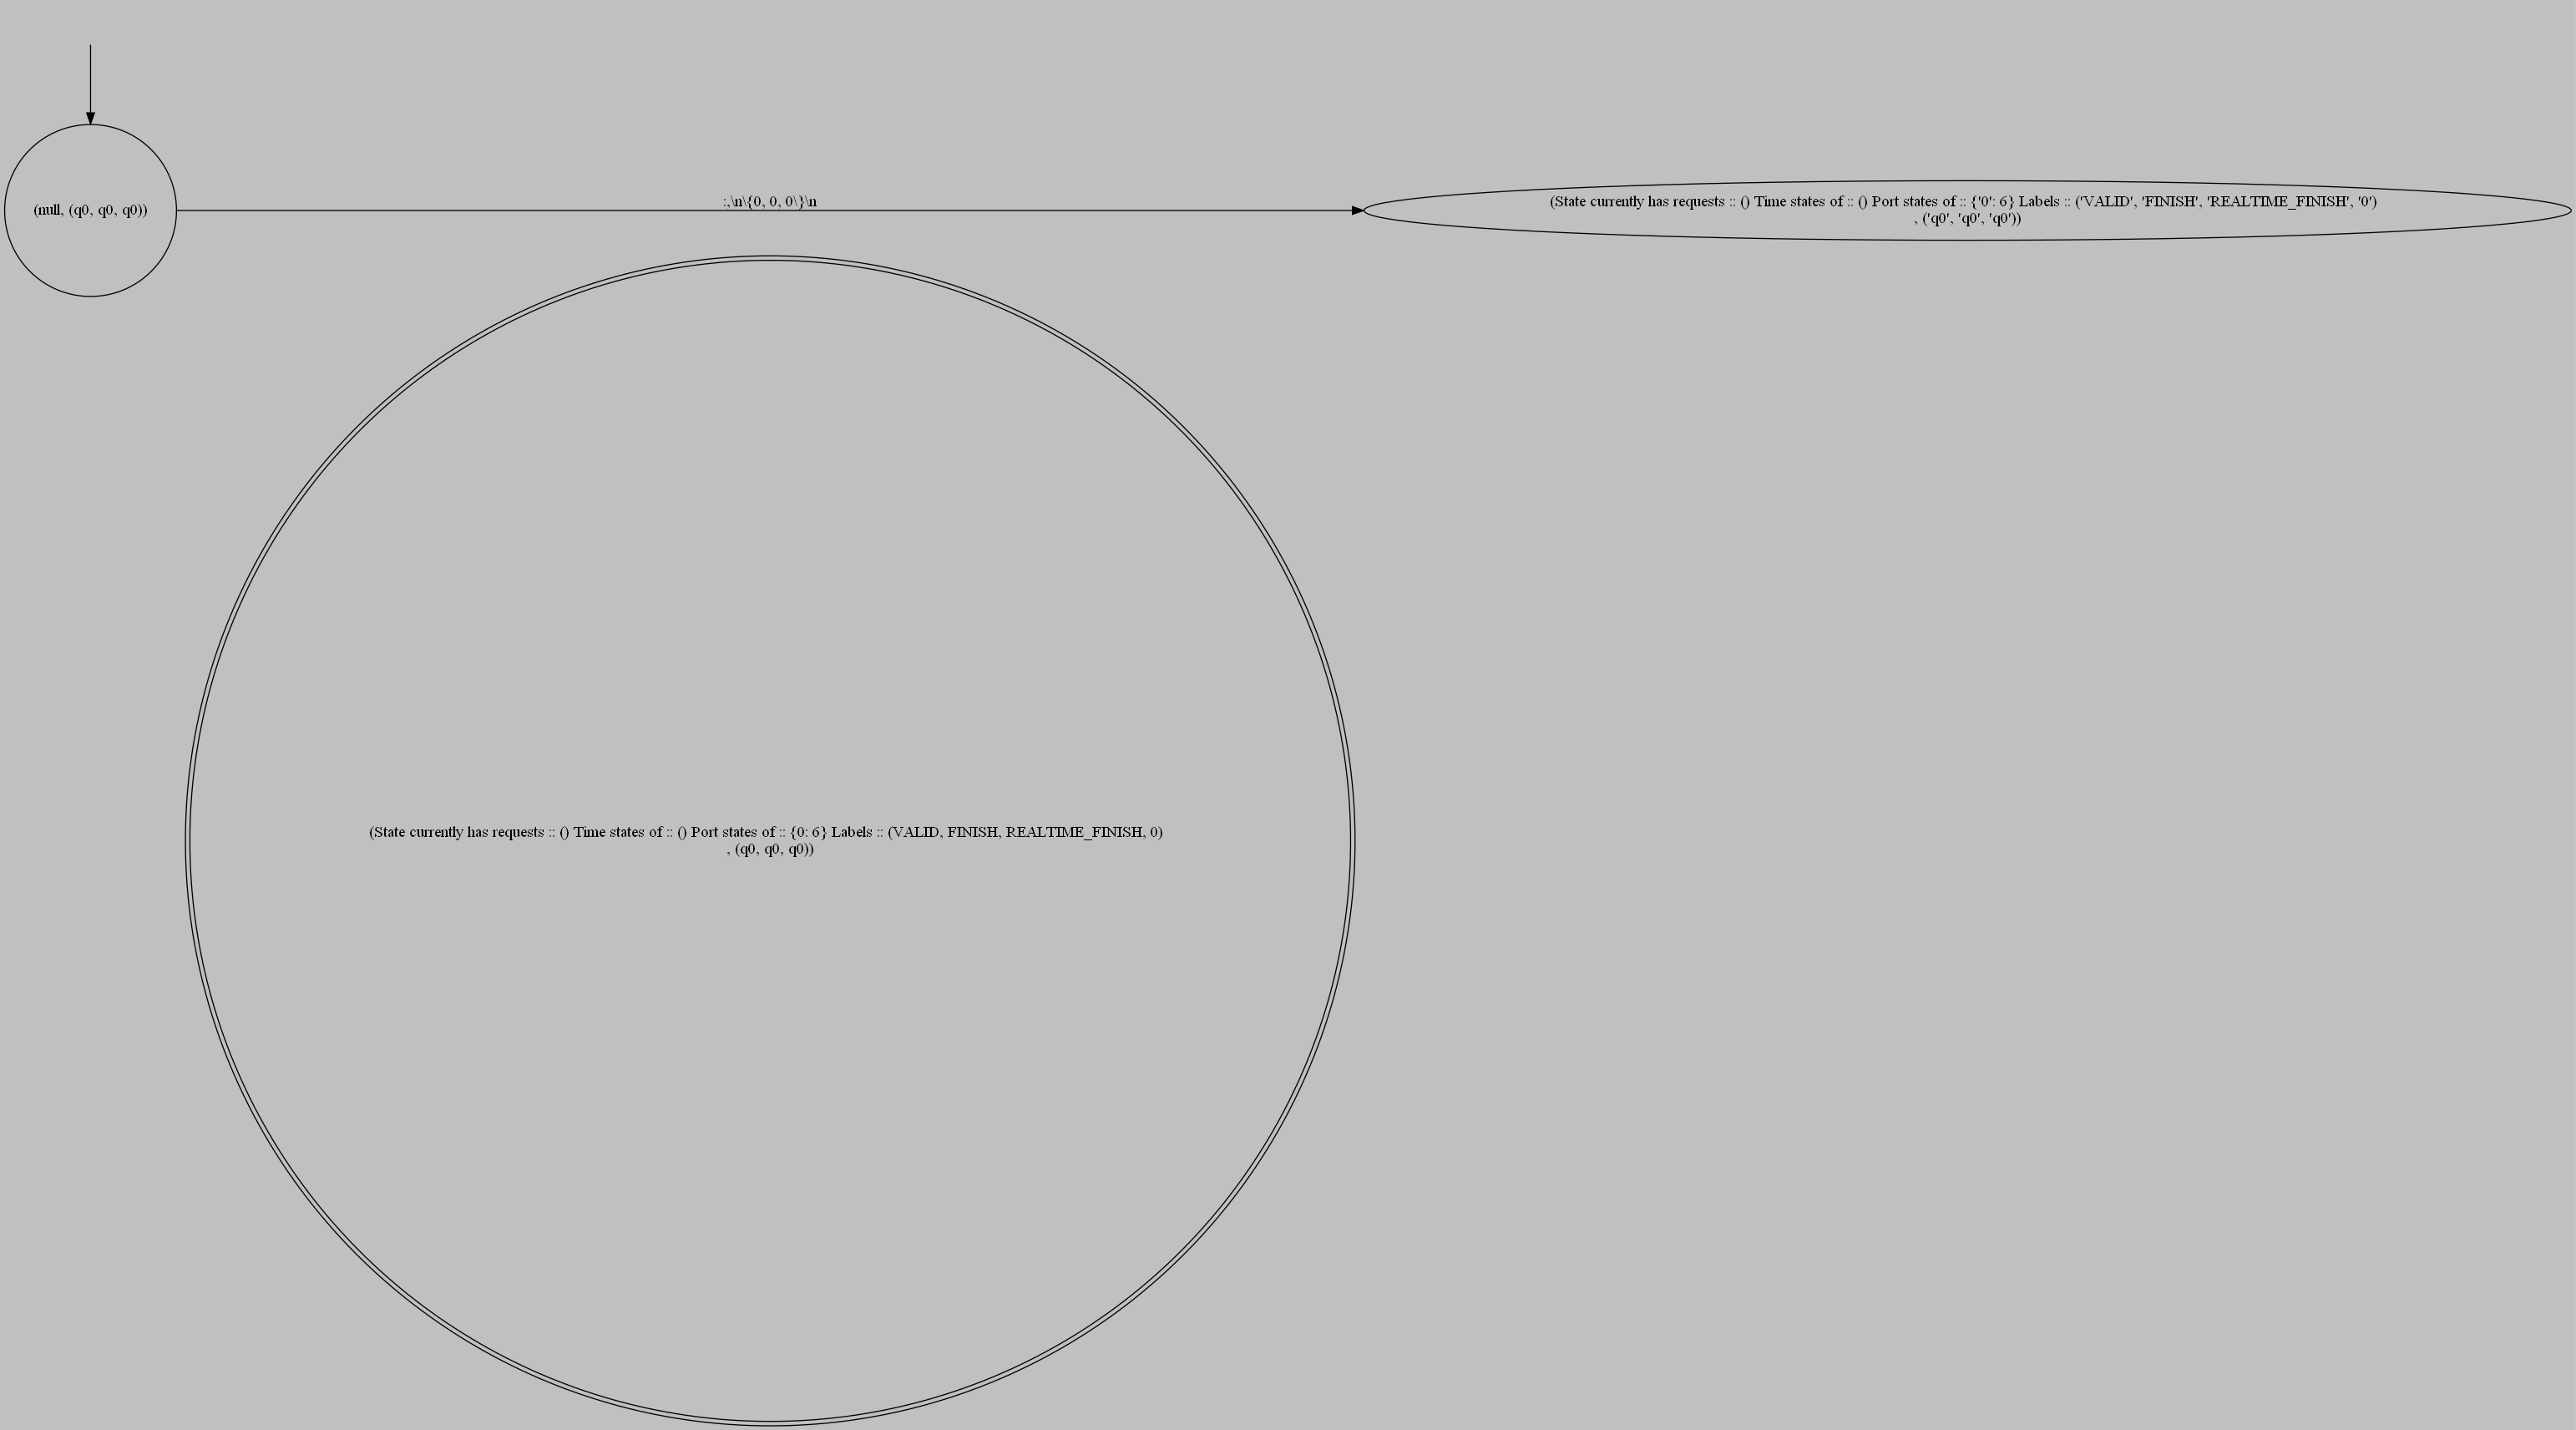

Path cost [0, 0, 0]


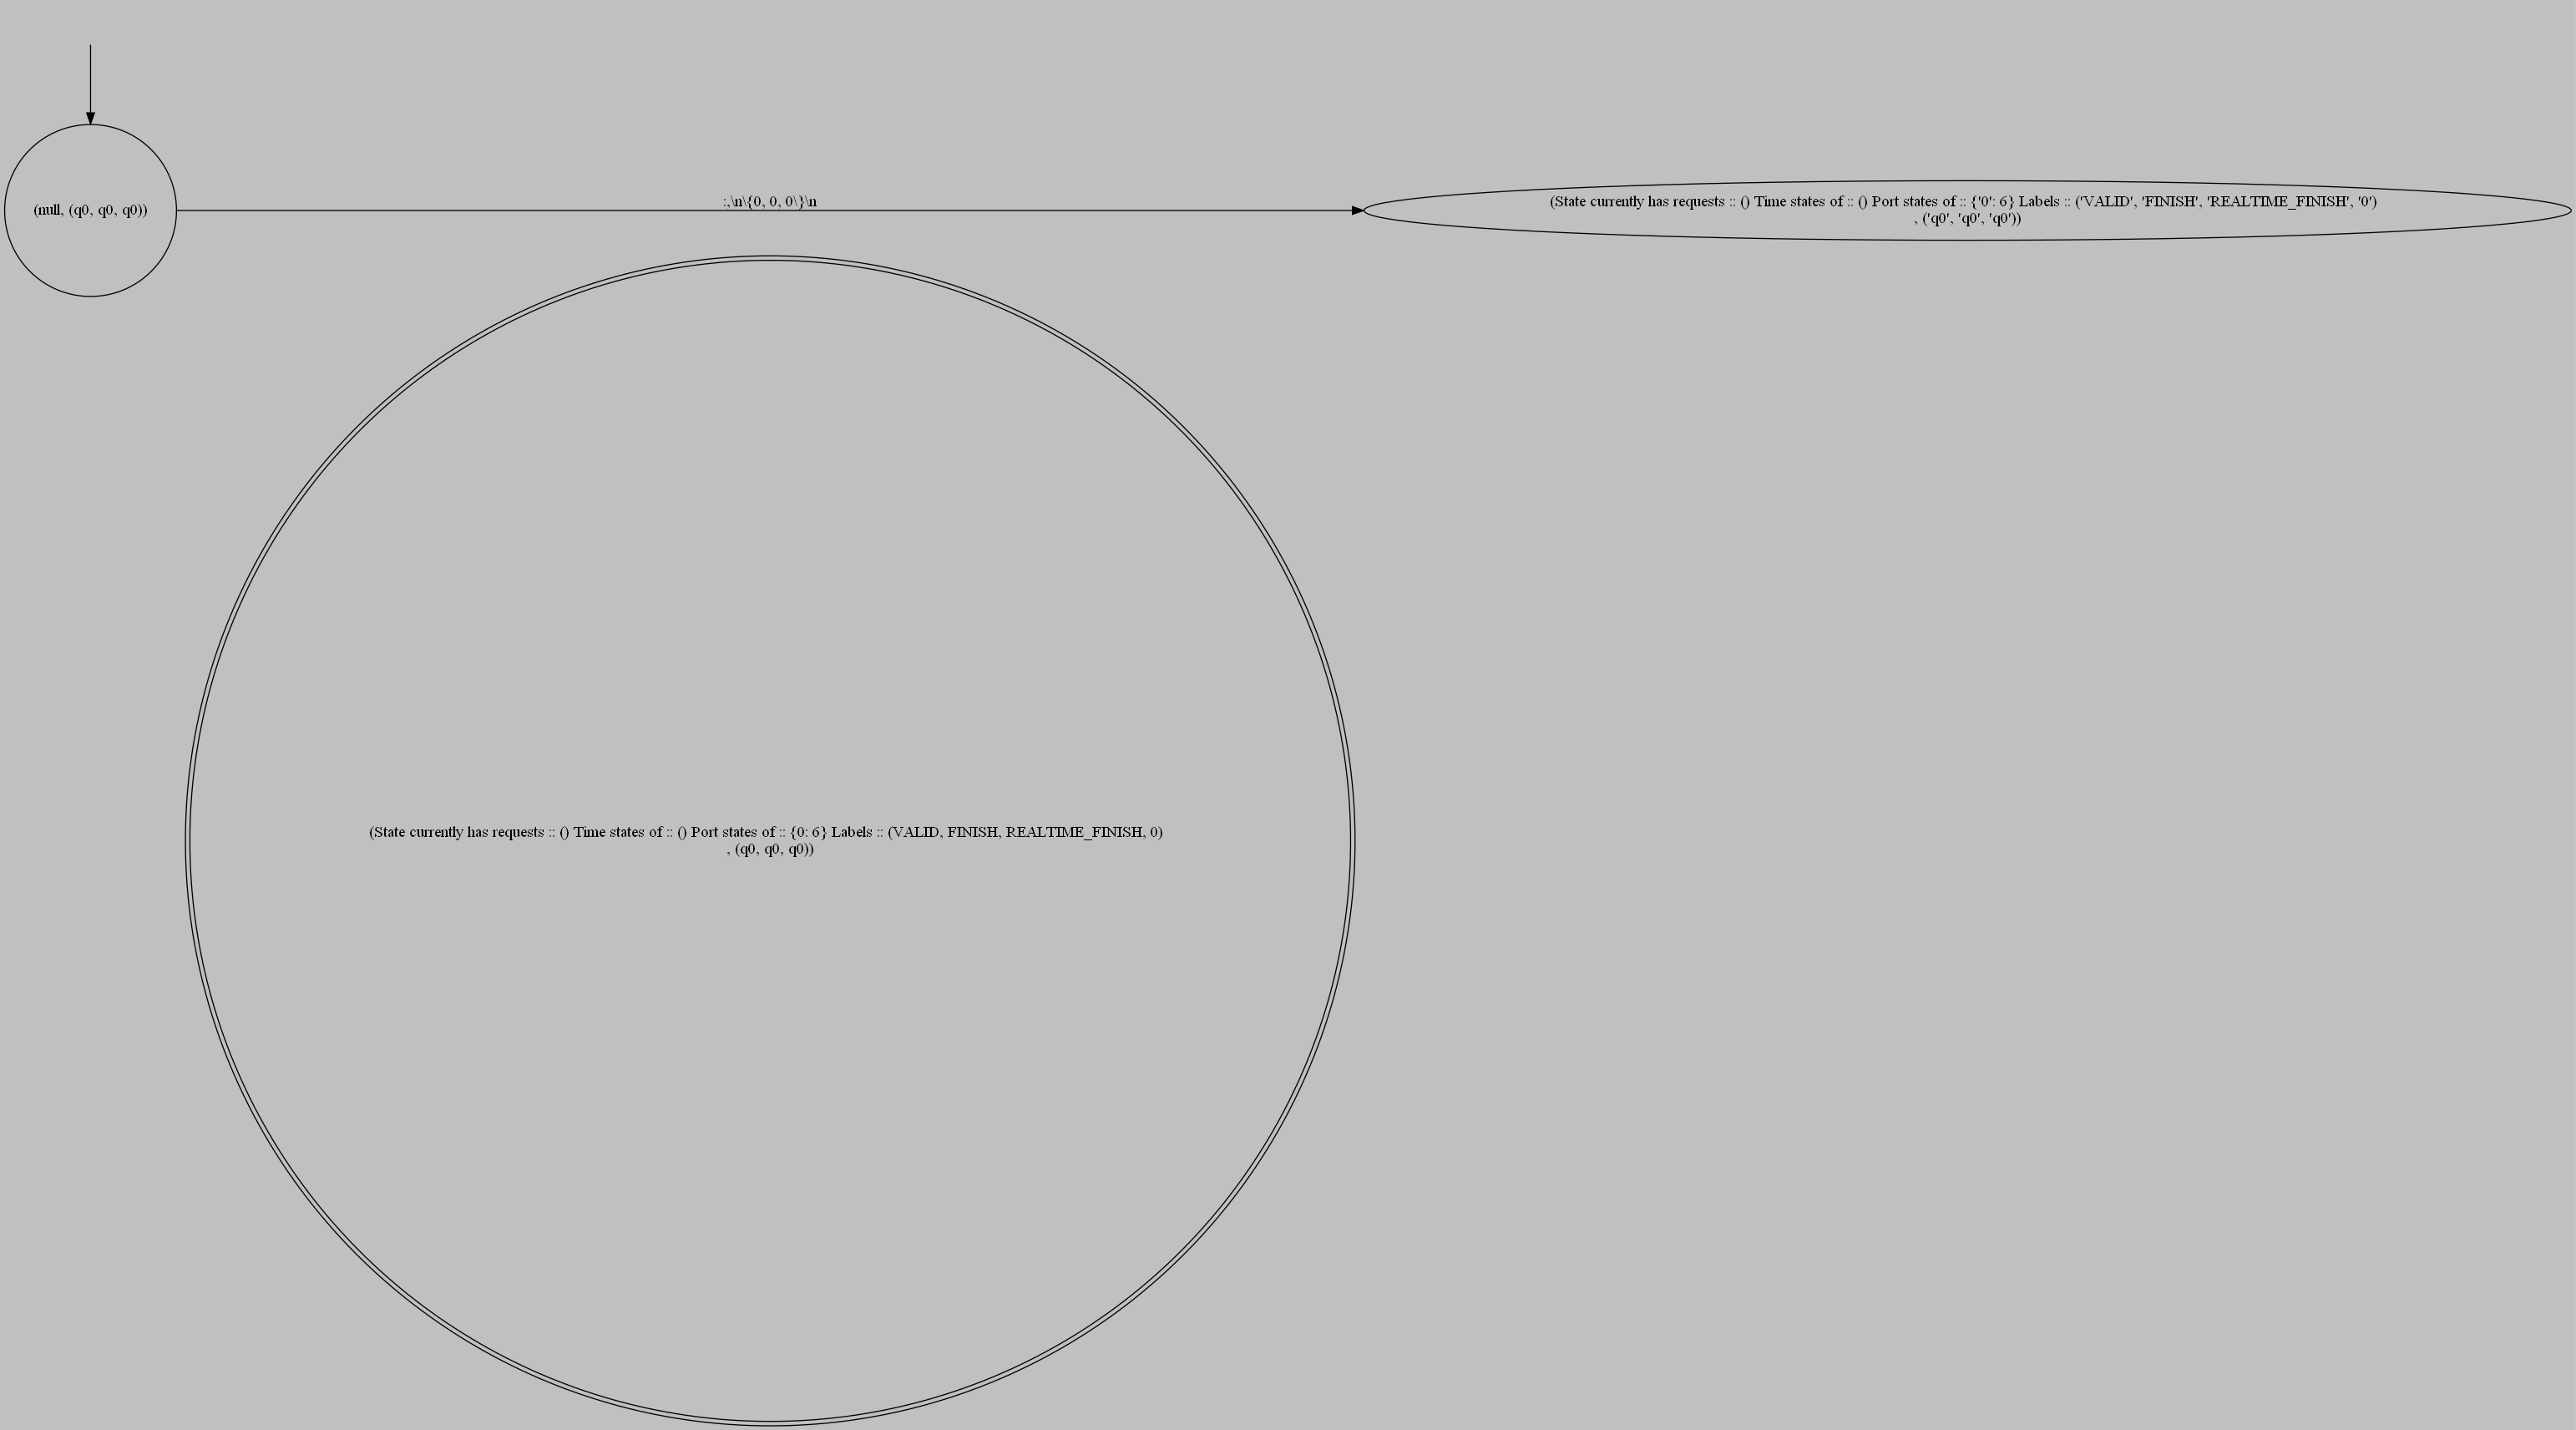

Path cost [0, 0, 0]


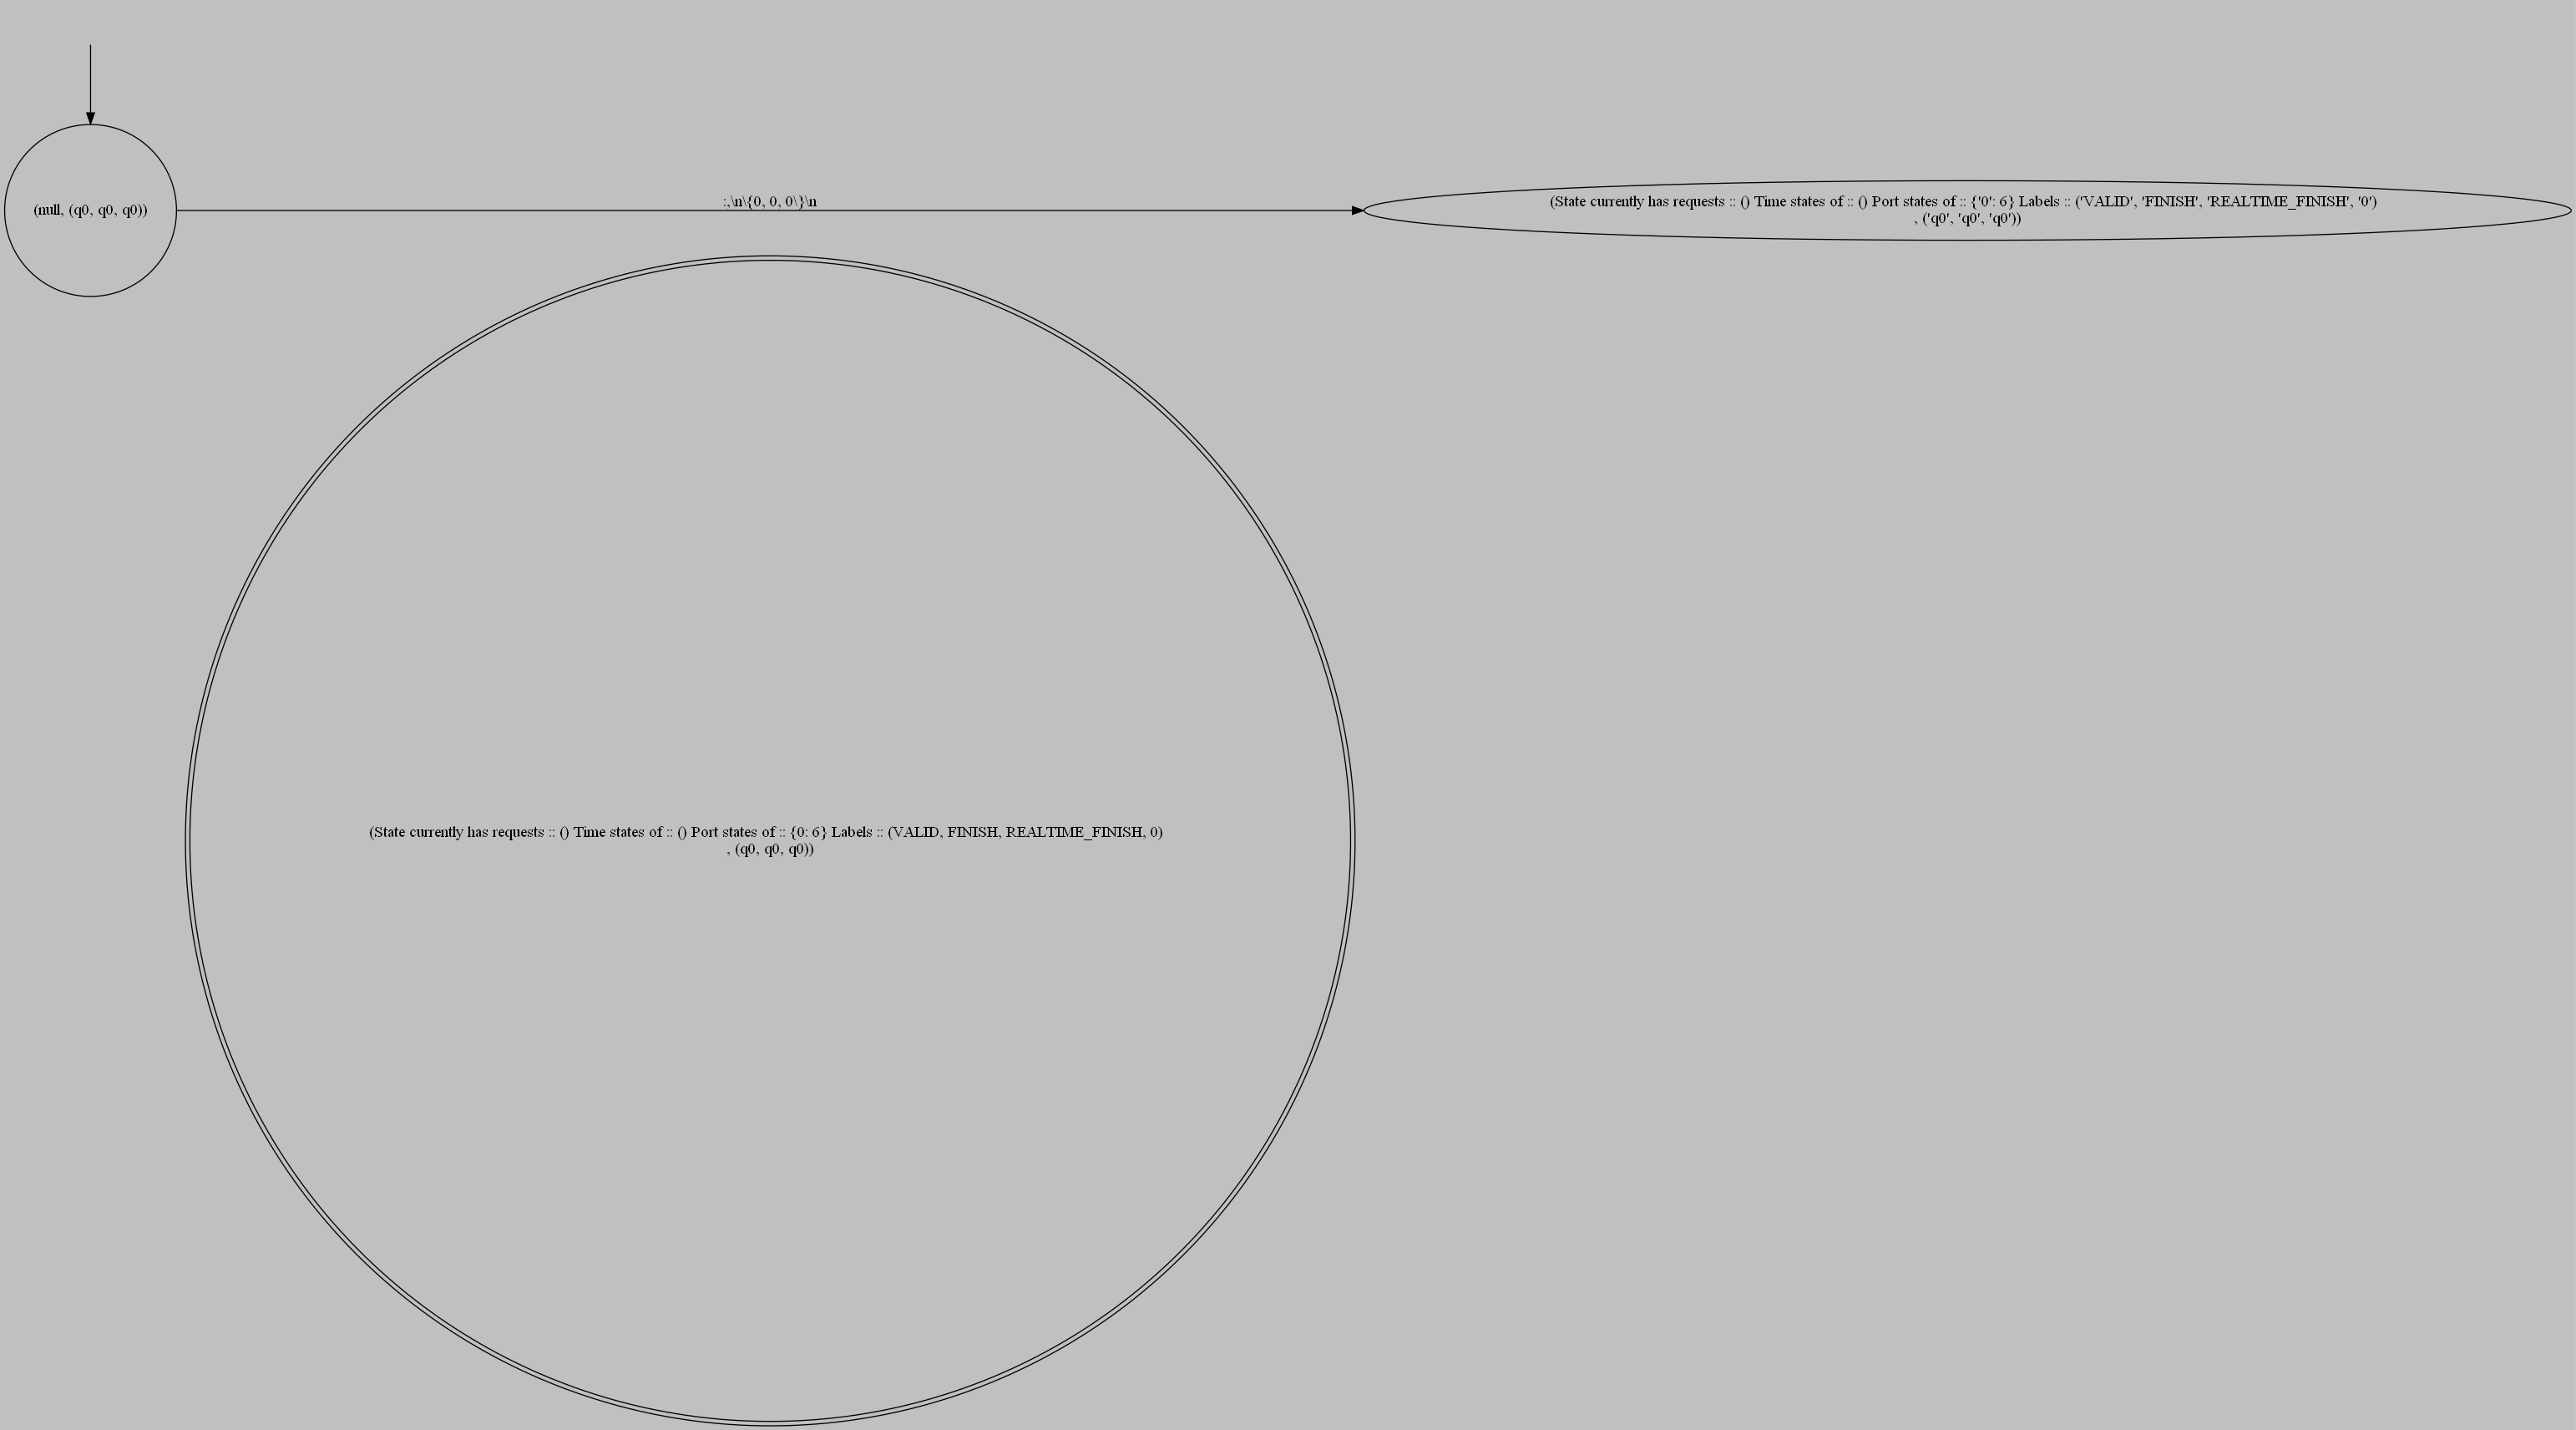

Path cost [0, 0, 0]


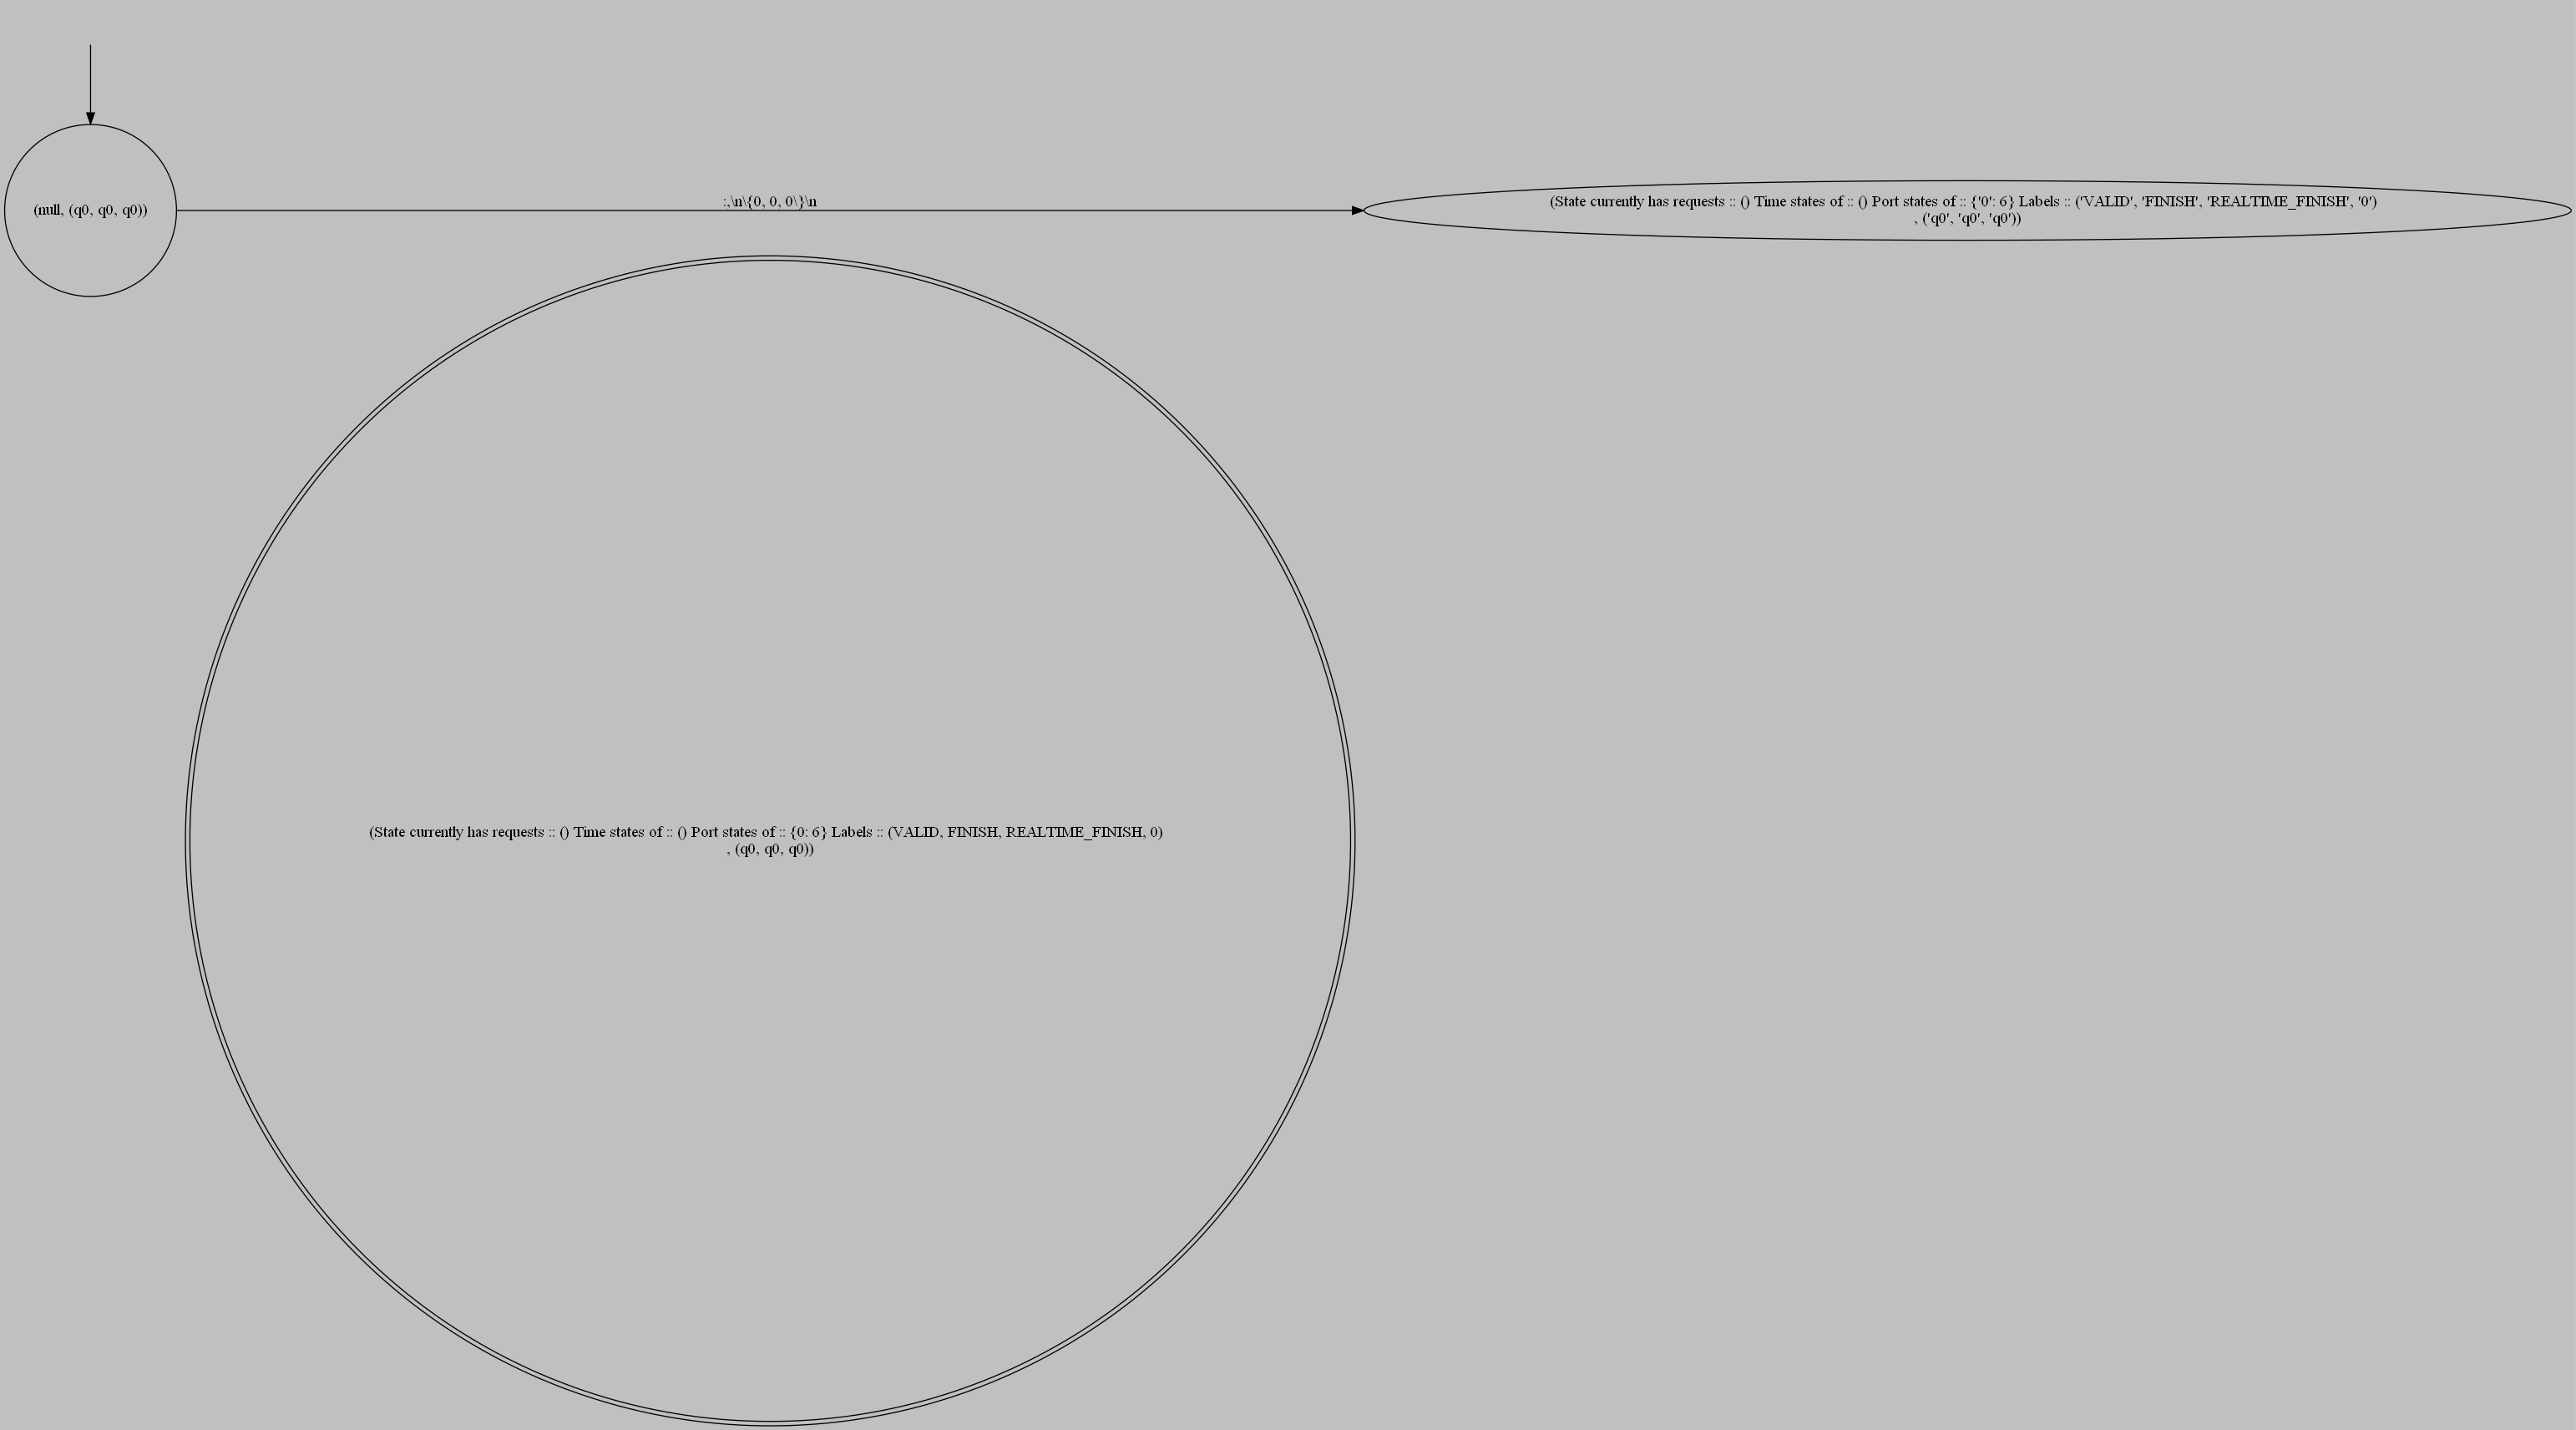

Path cost [0, 0, 0]


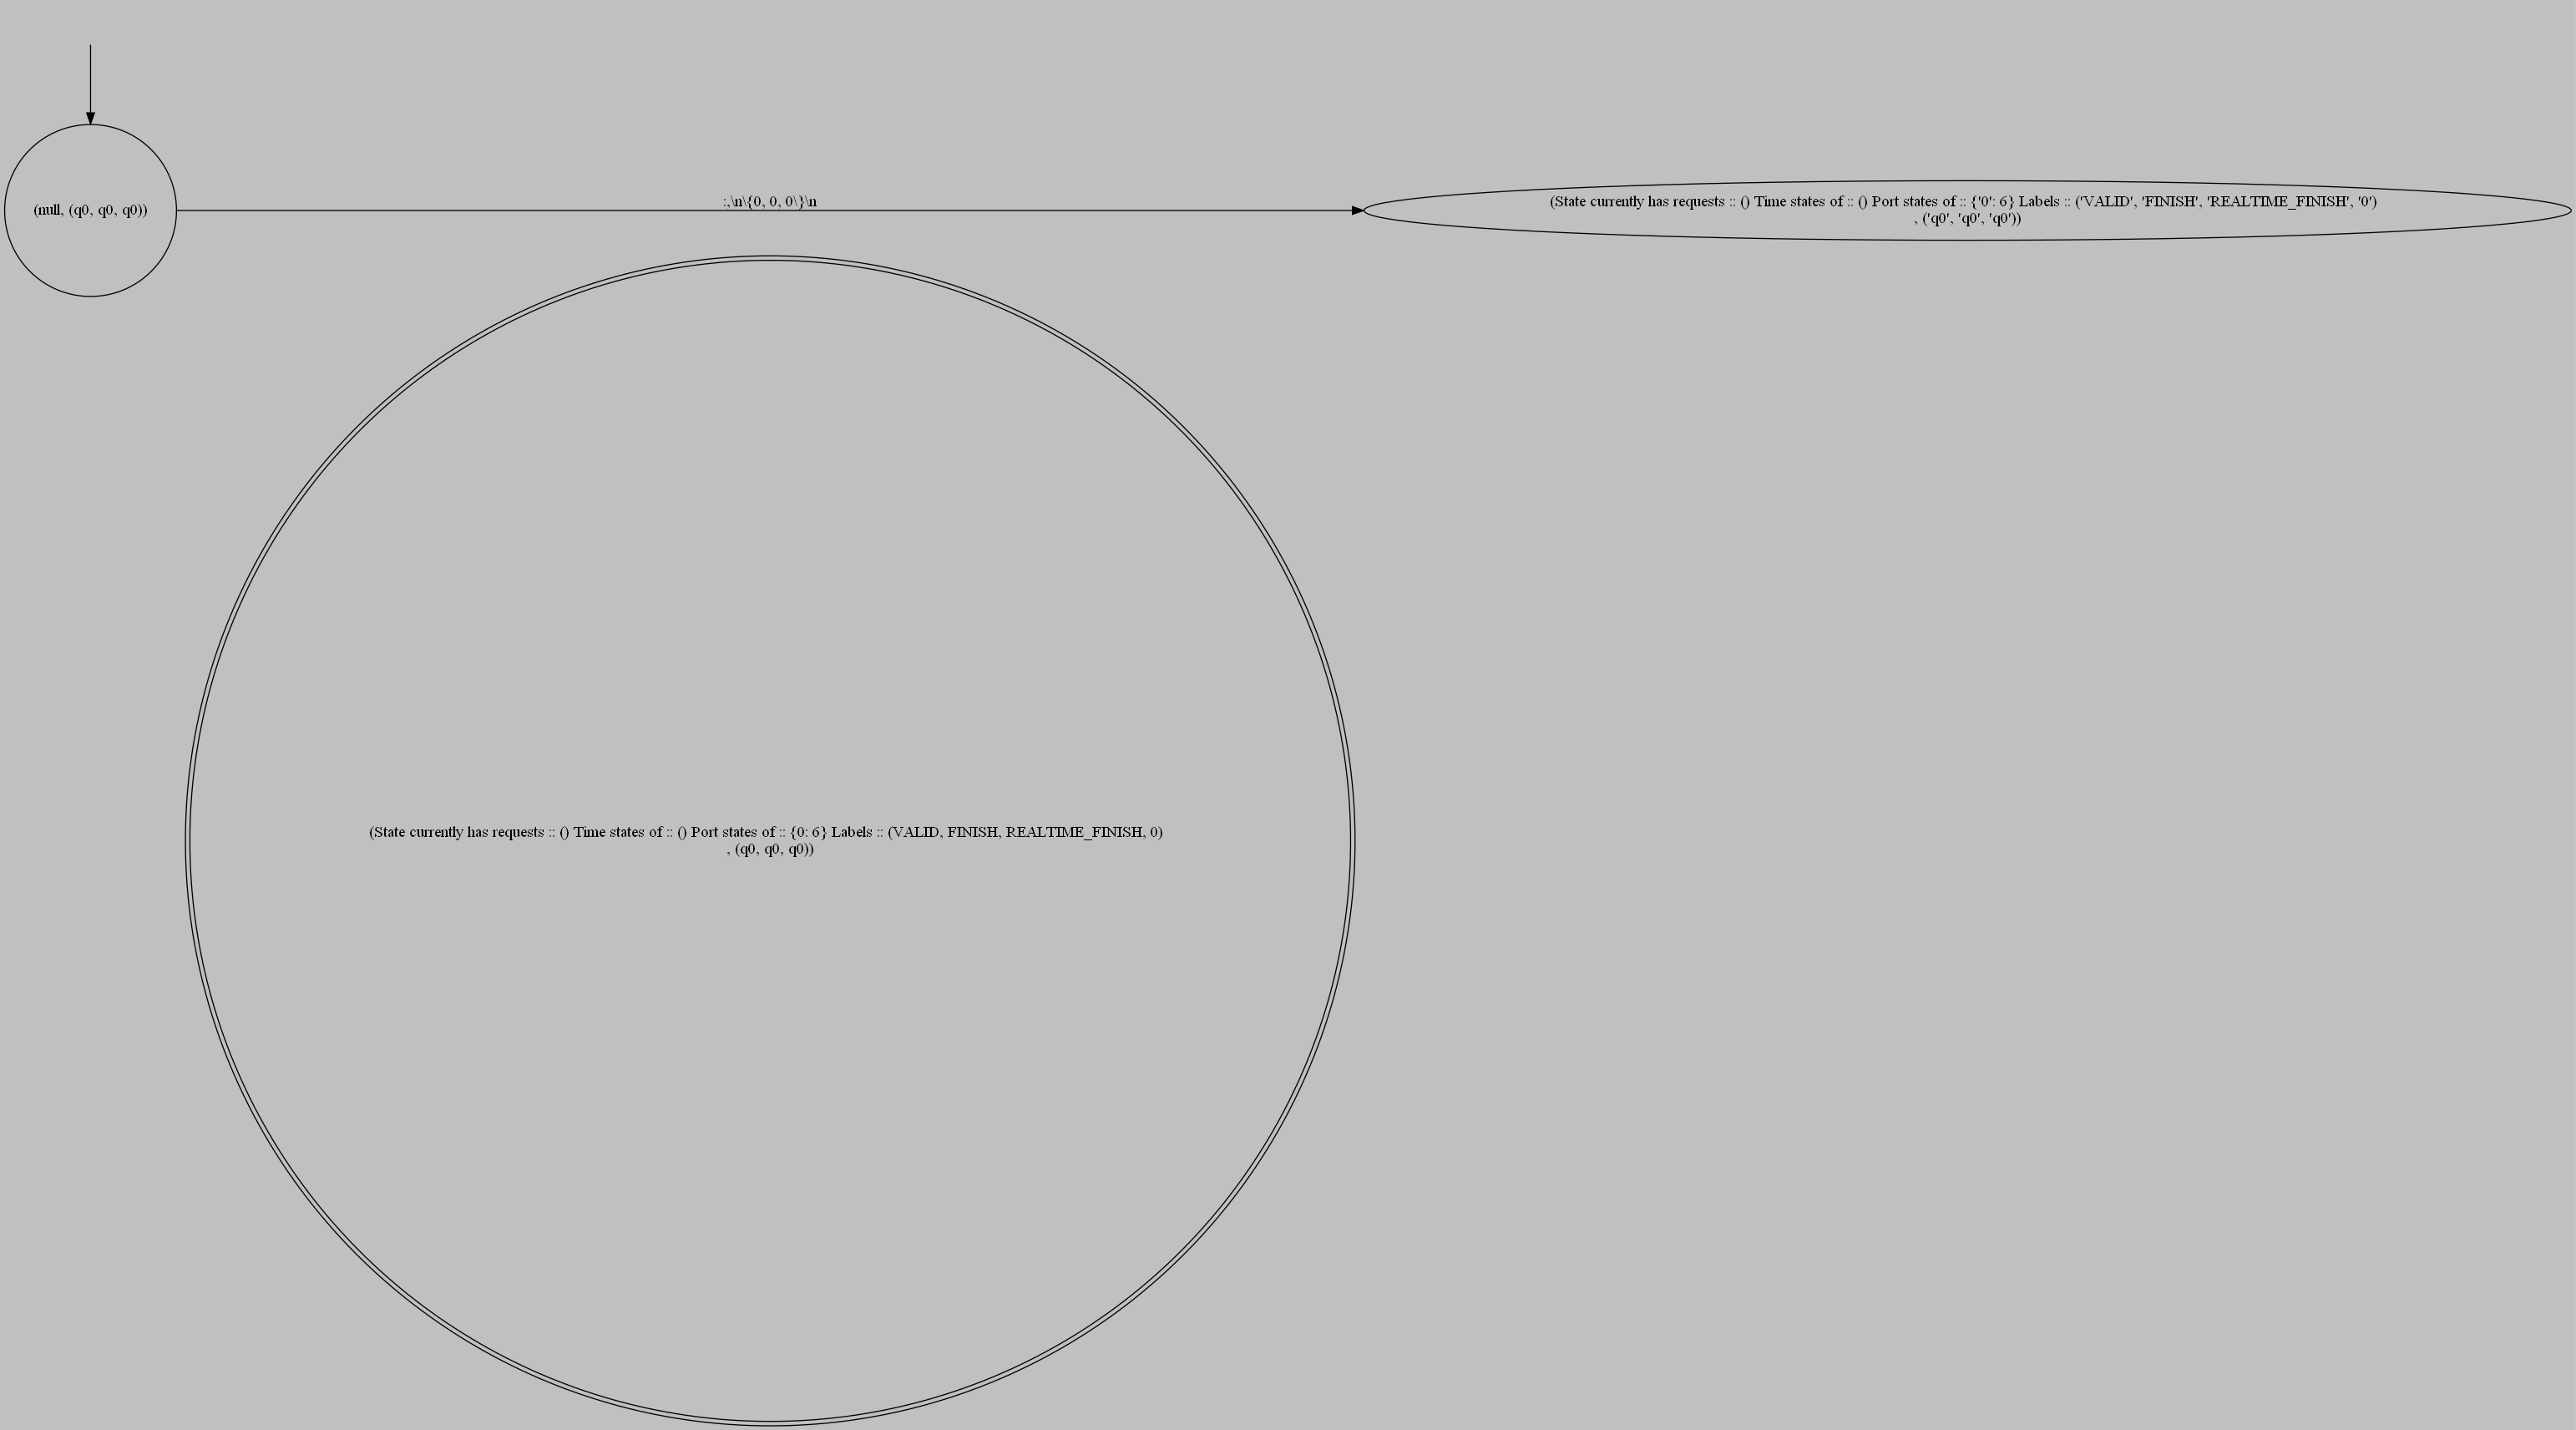

Path cost [0, 0, 0]


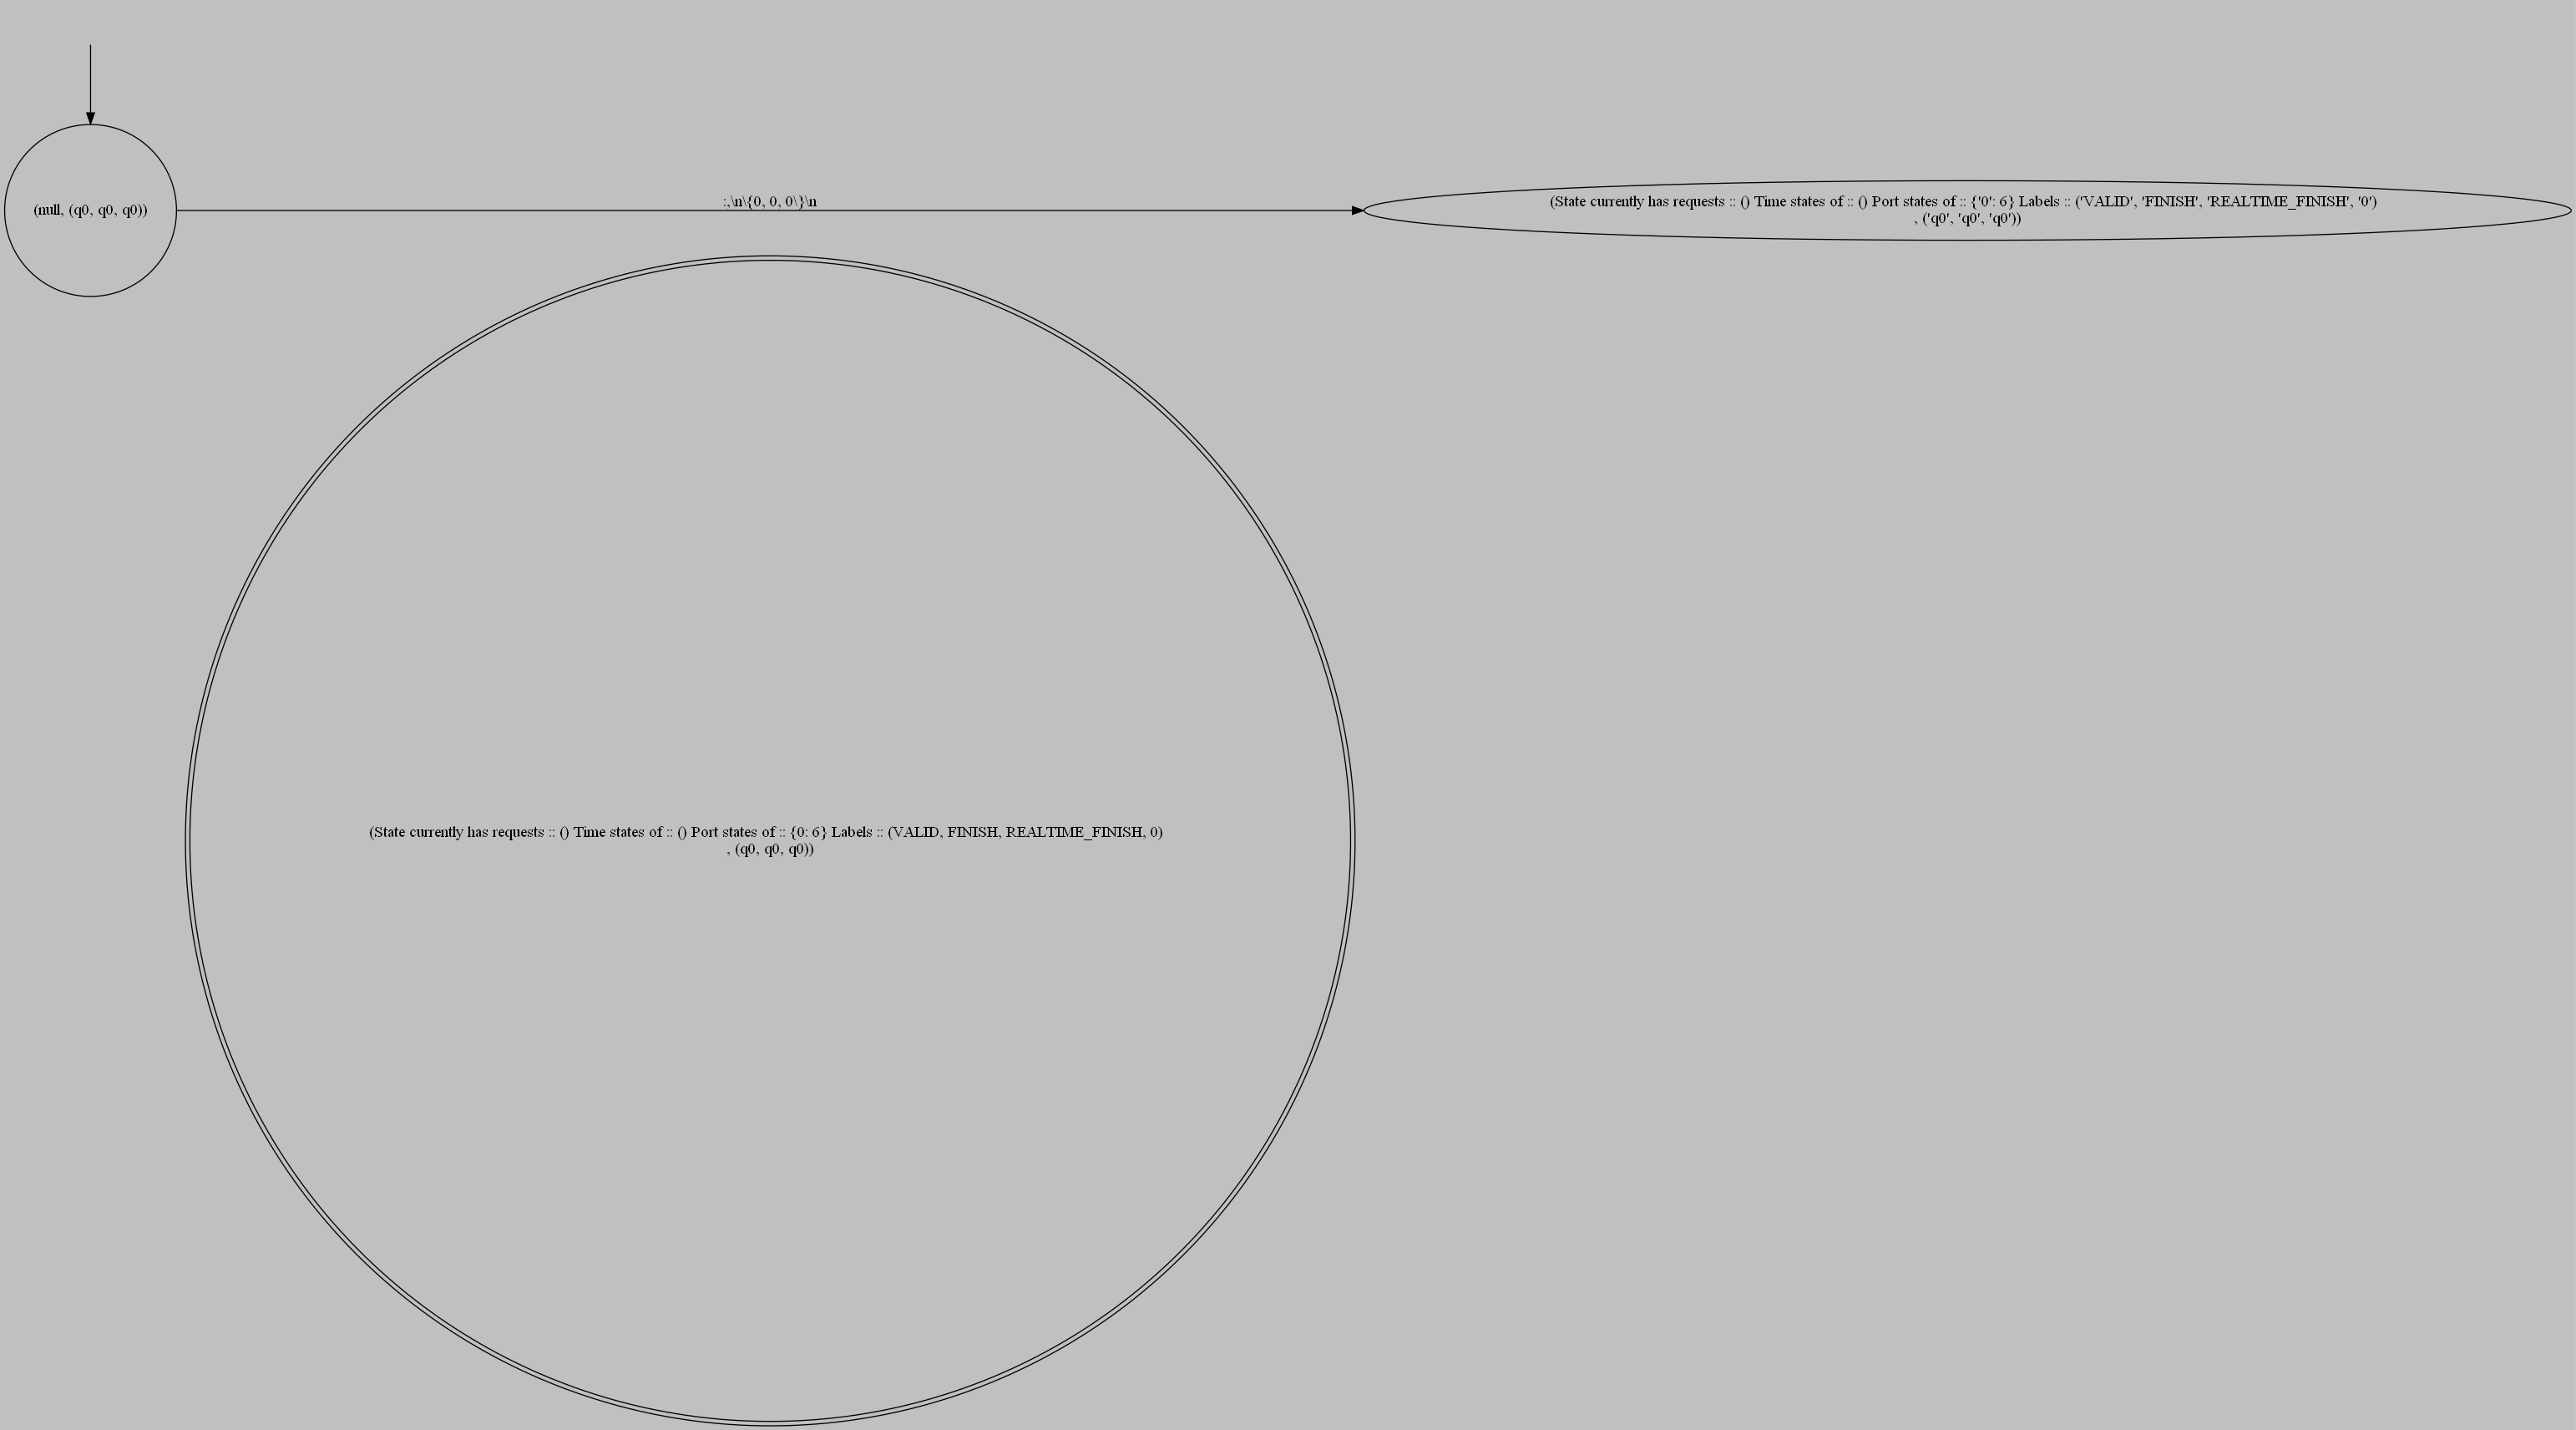

Path cost [0, 0, 0]


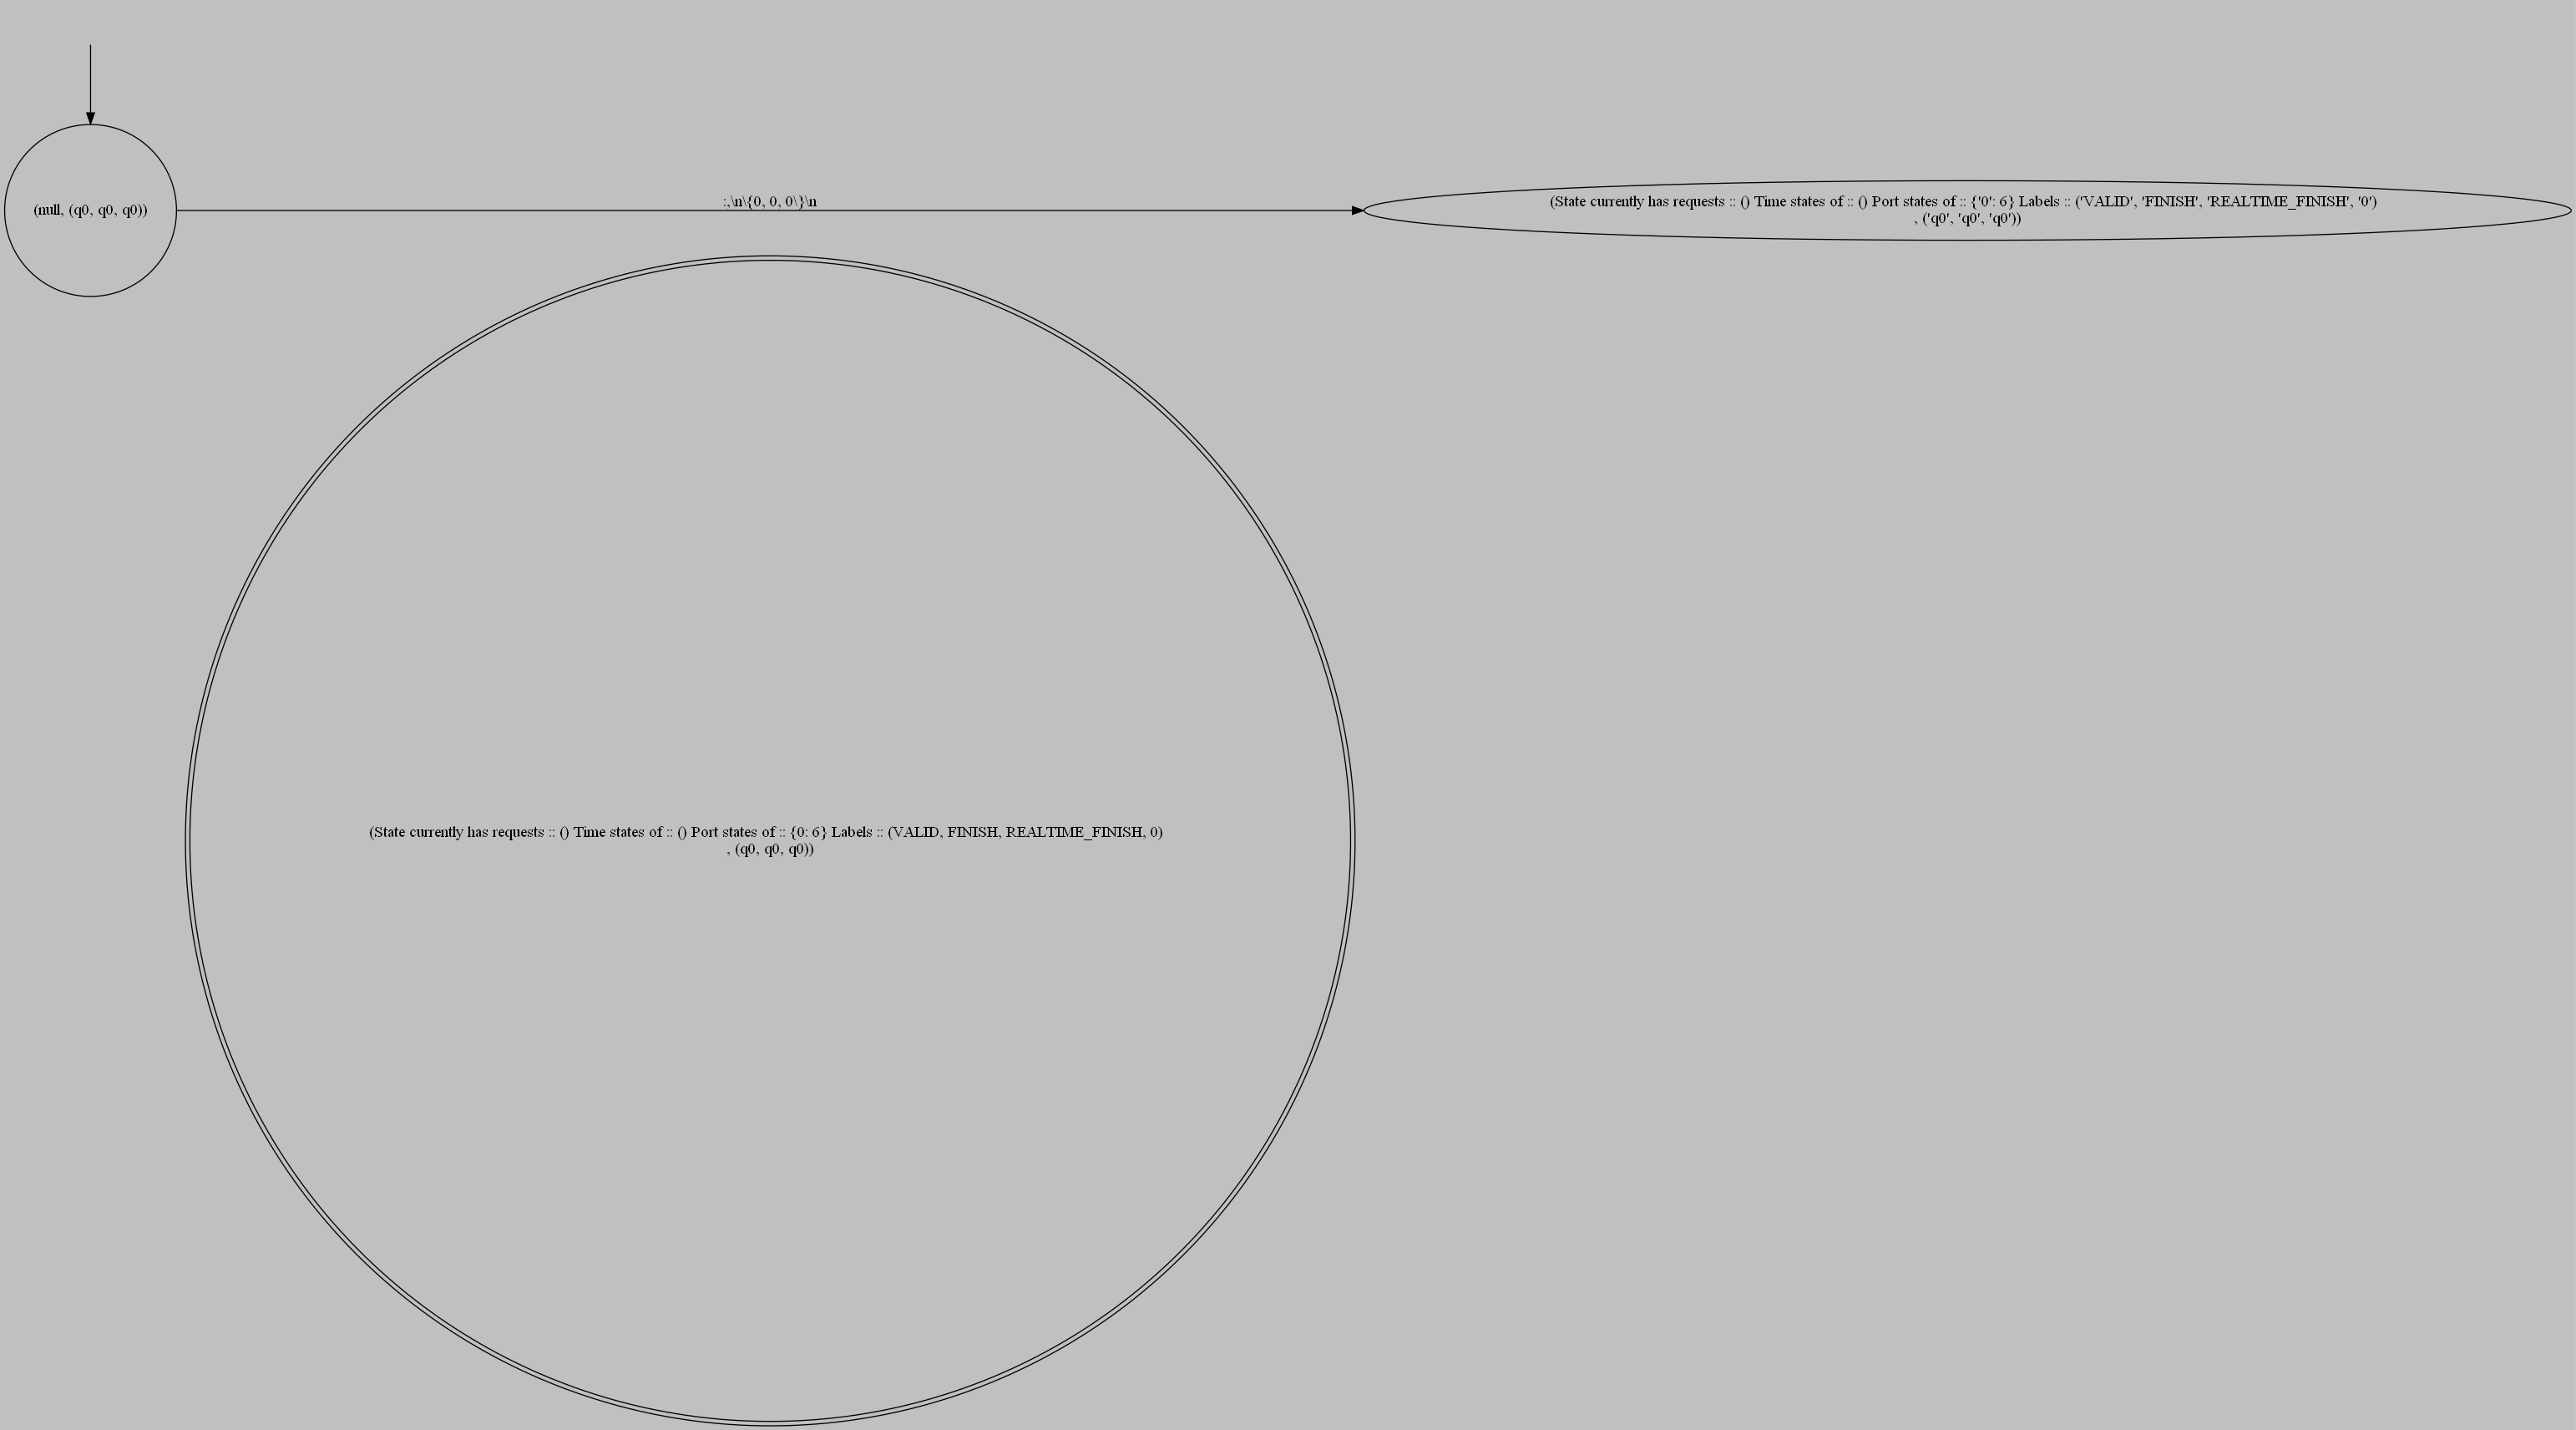

Path cost [0, 0, 0]


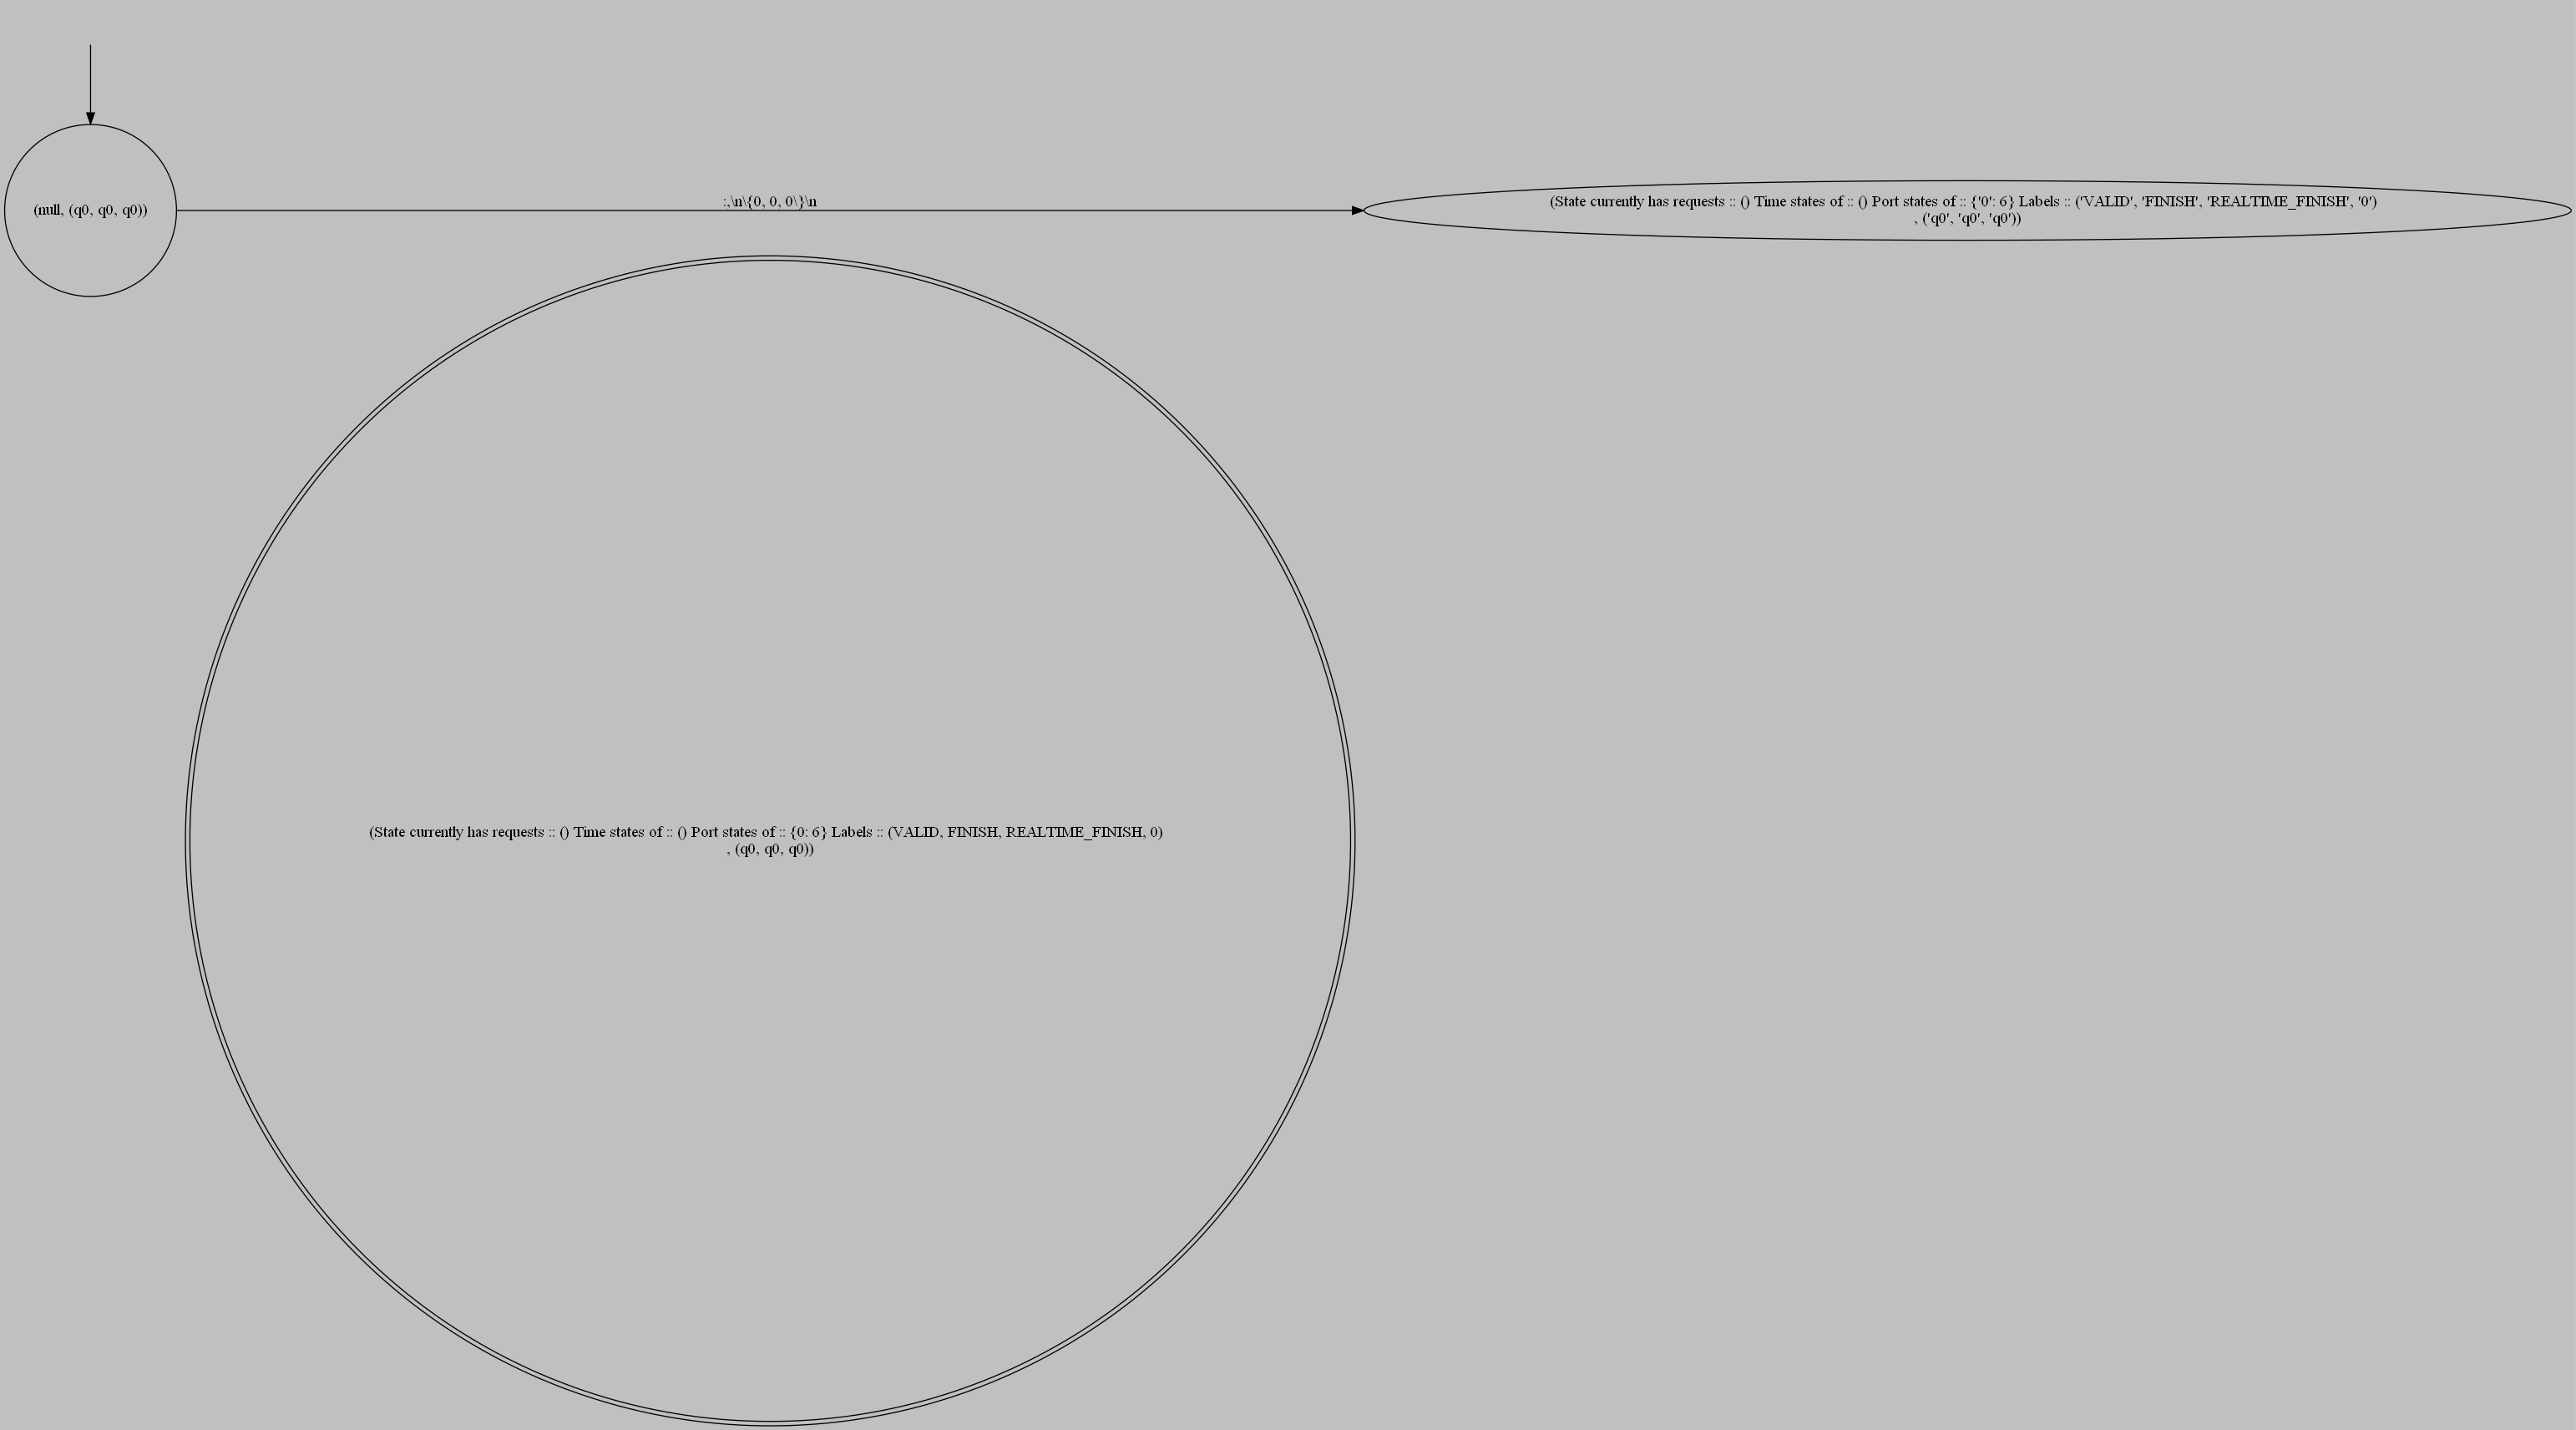

Path cost [0, 0, 0]


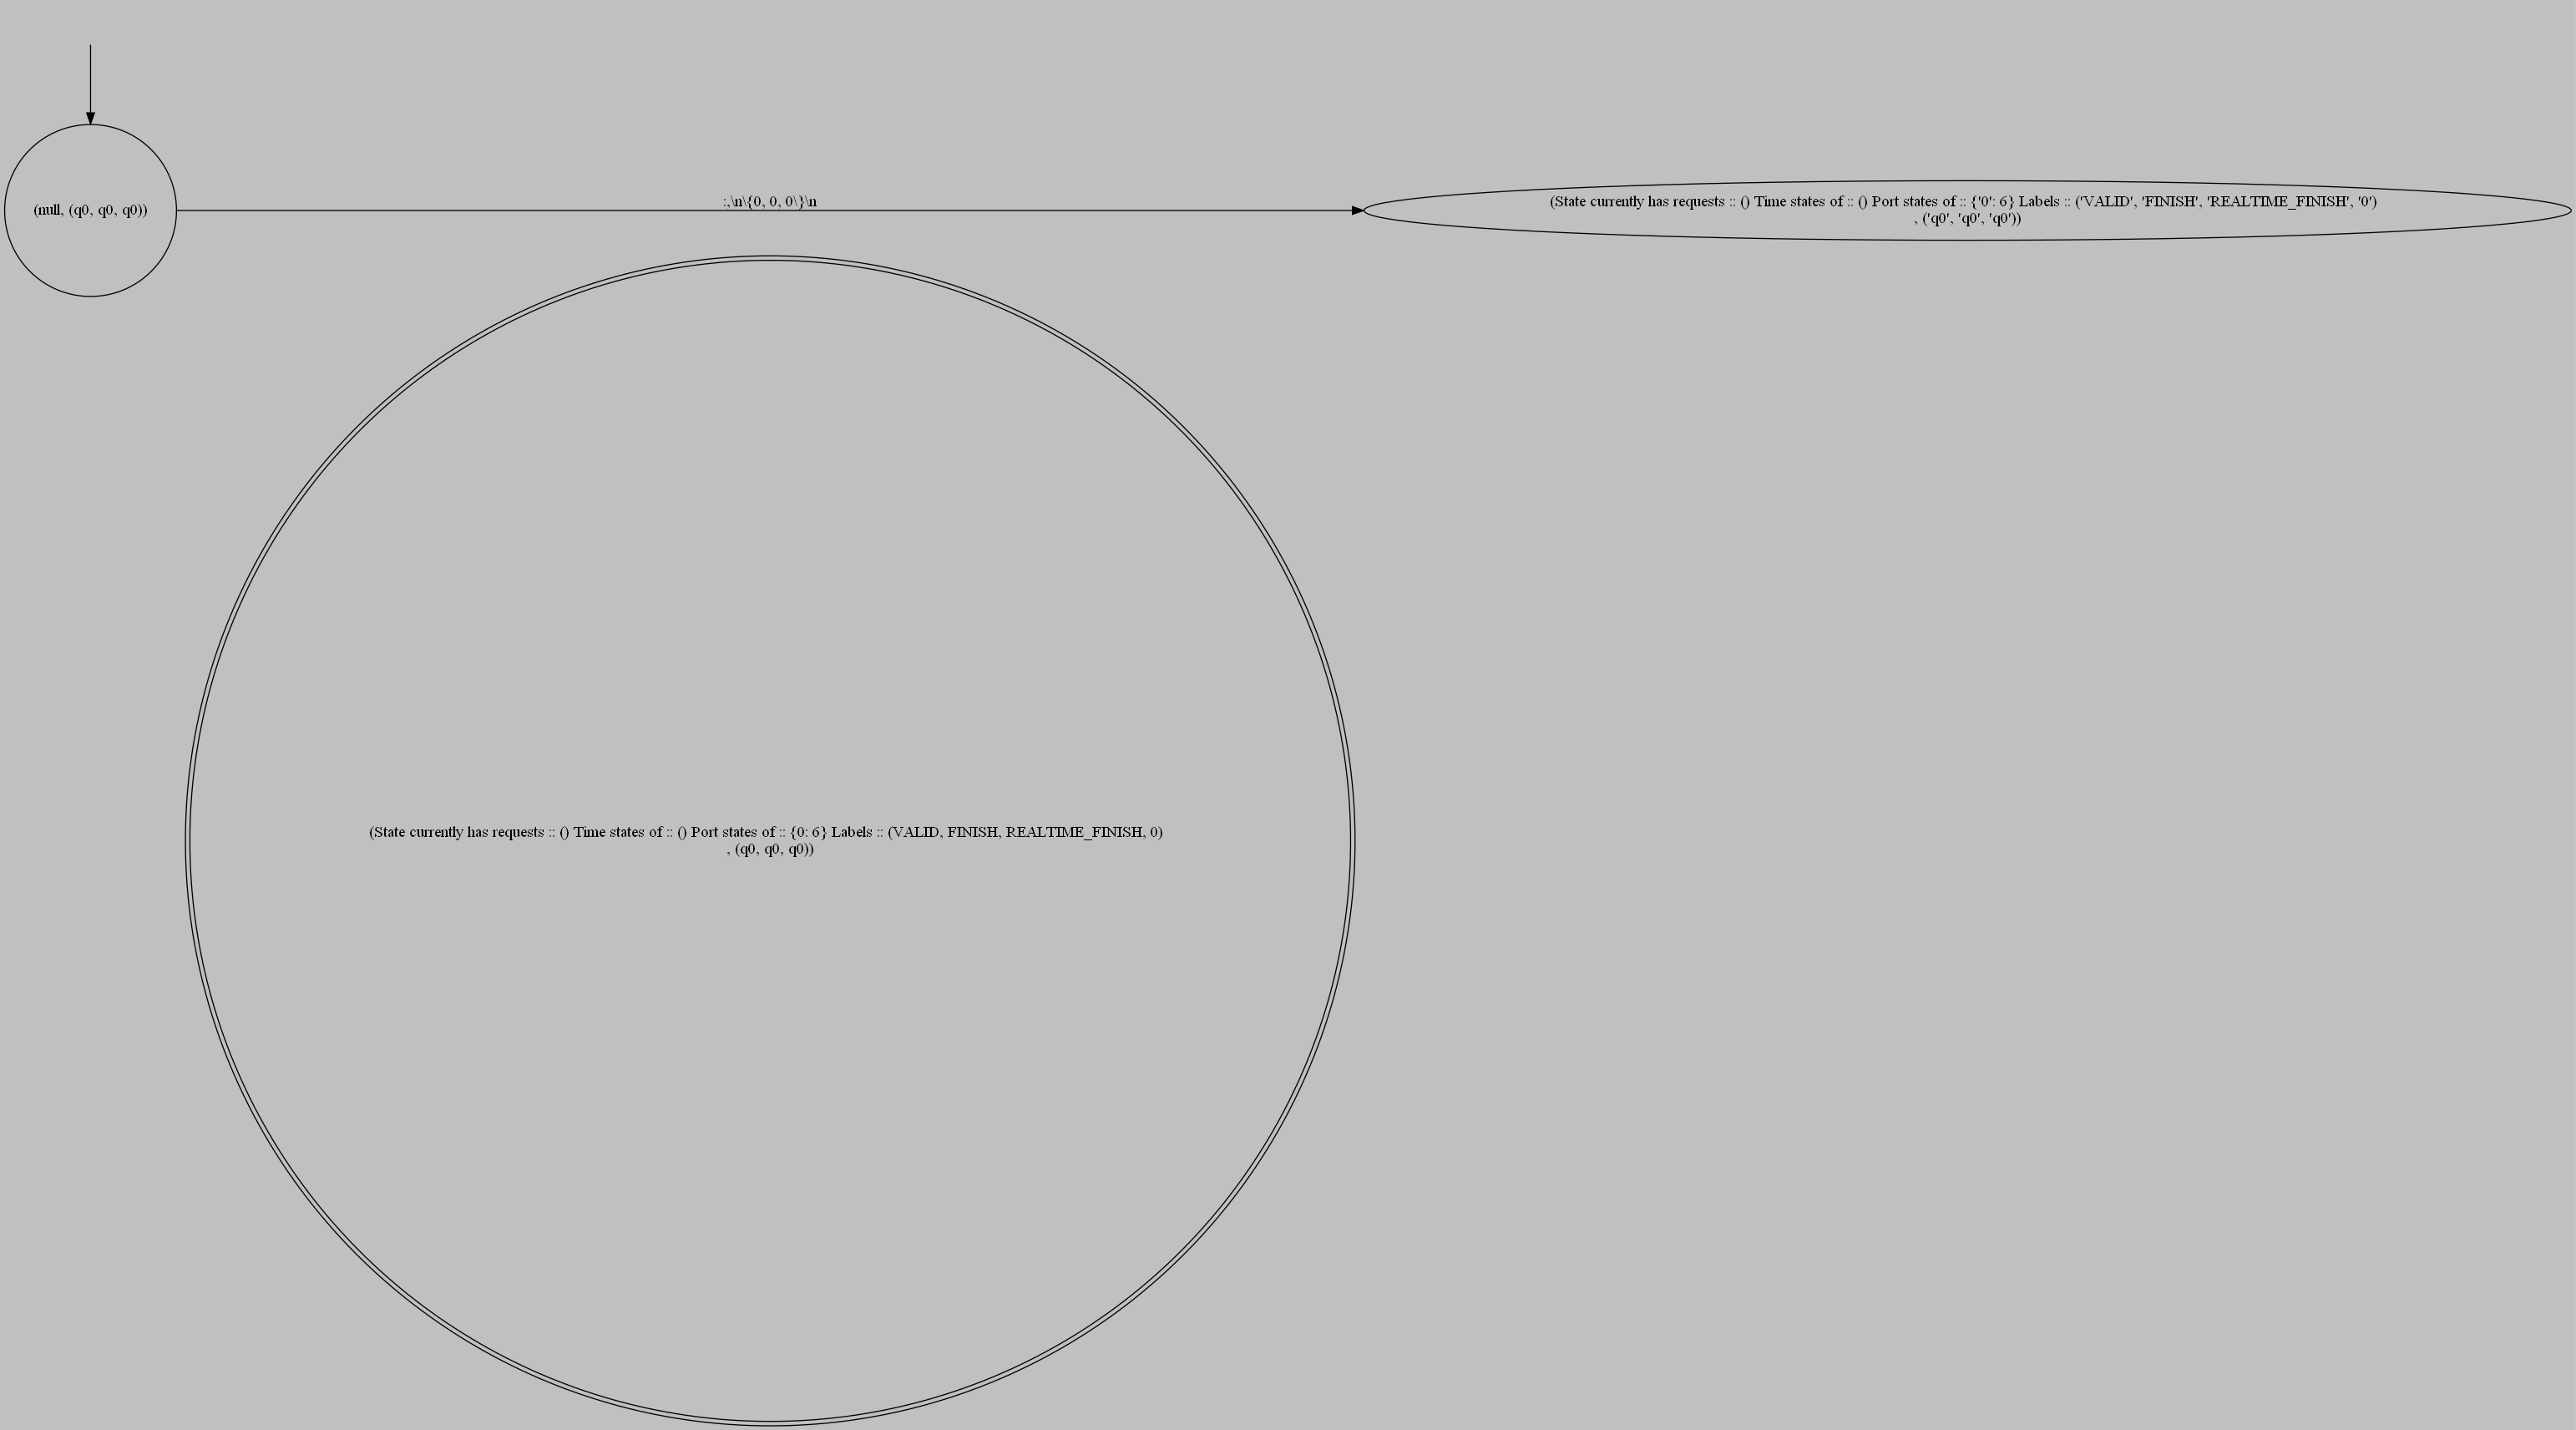

Path cost [0, 0, 0]


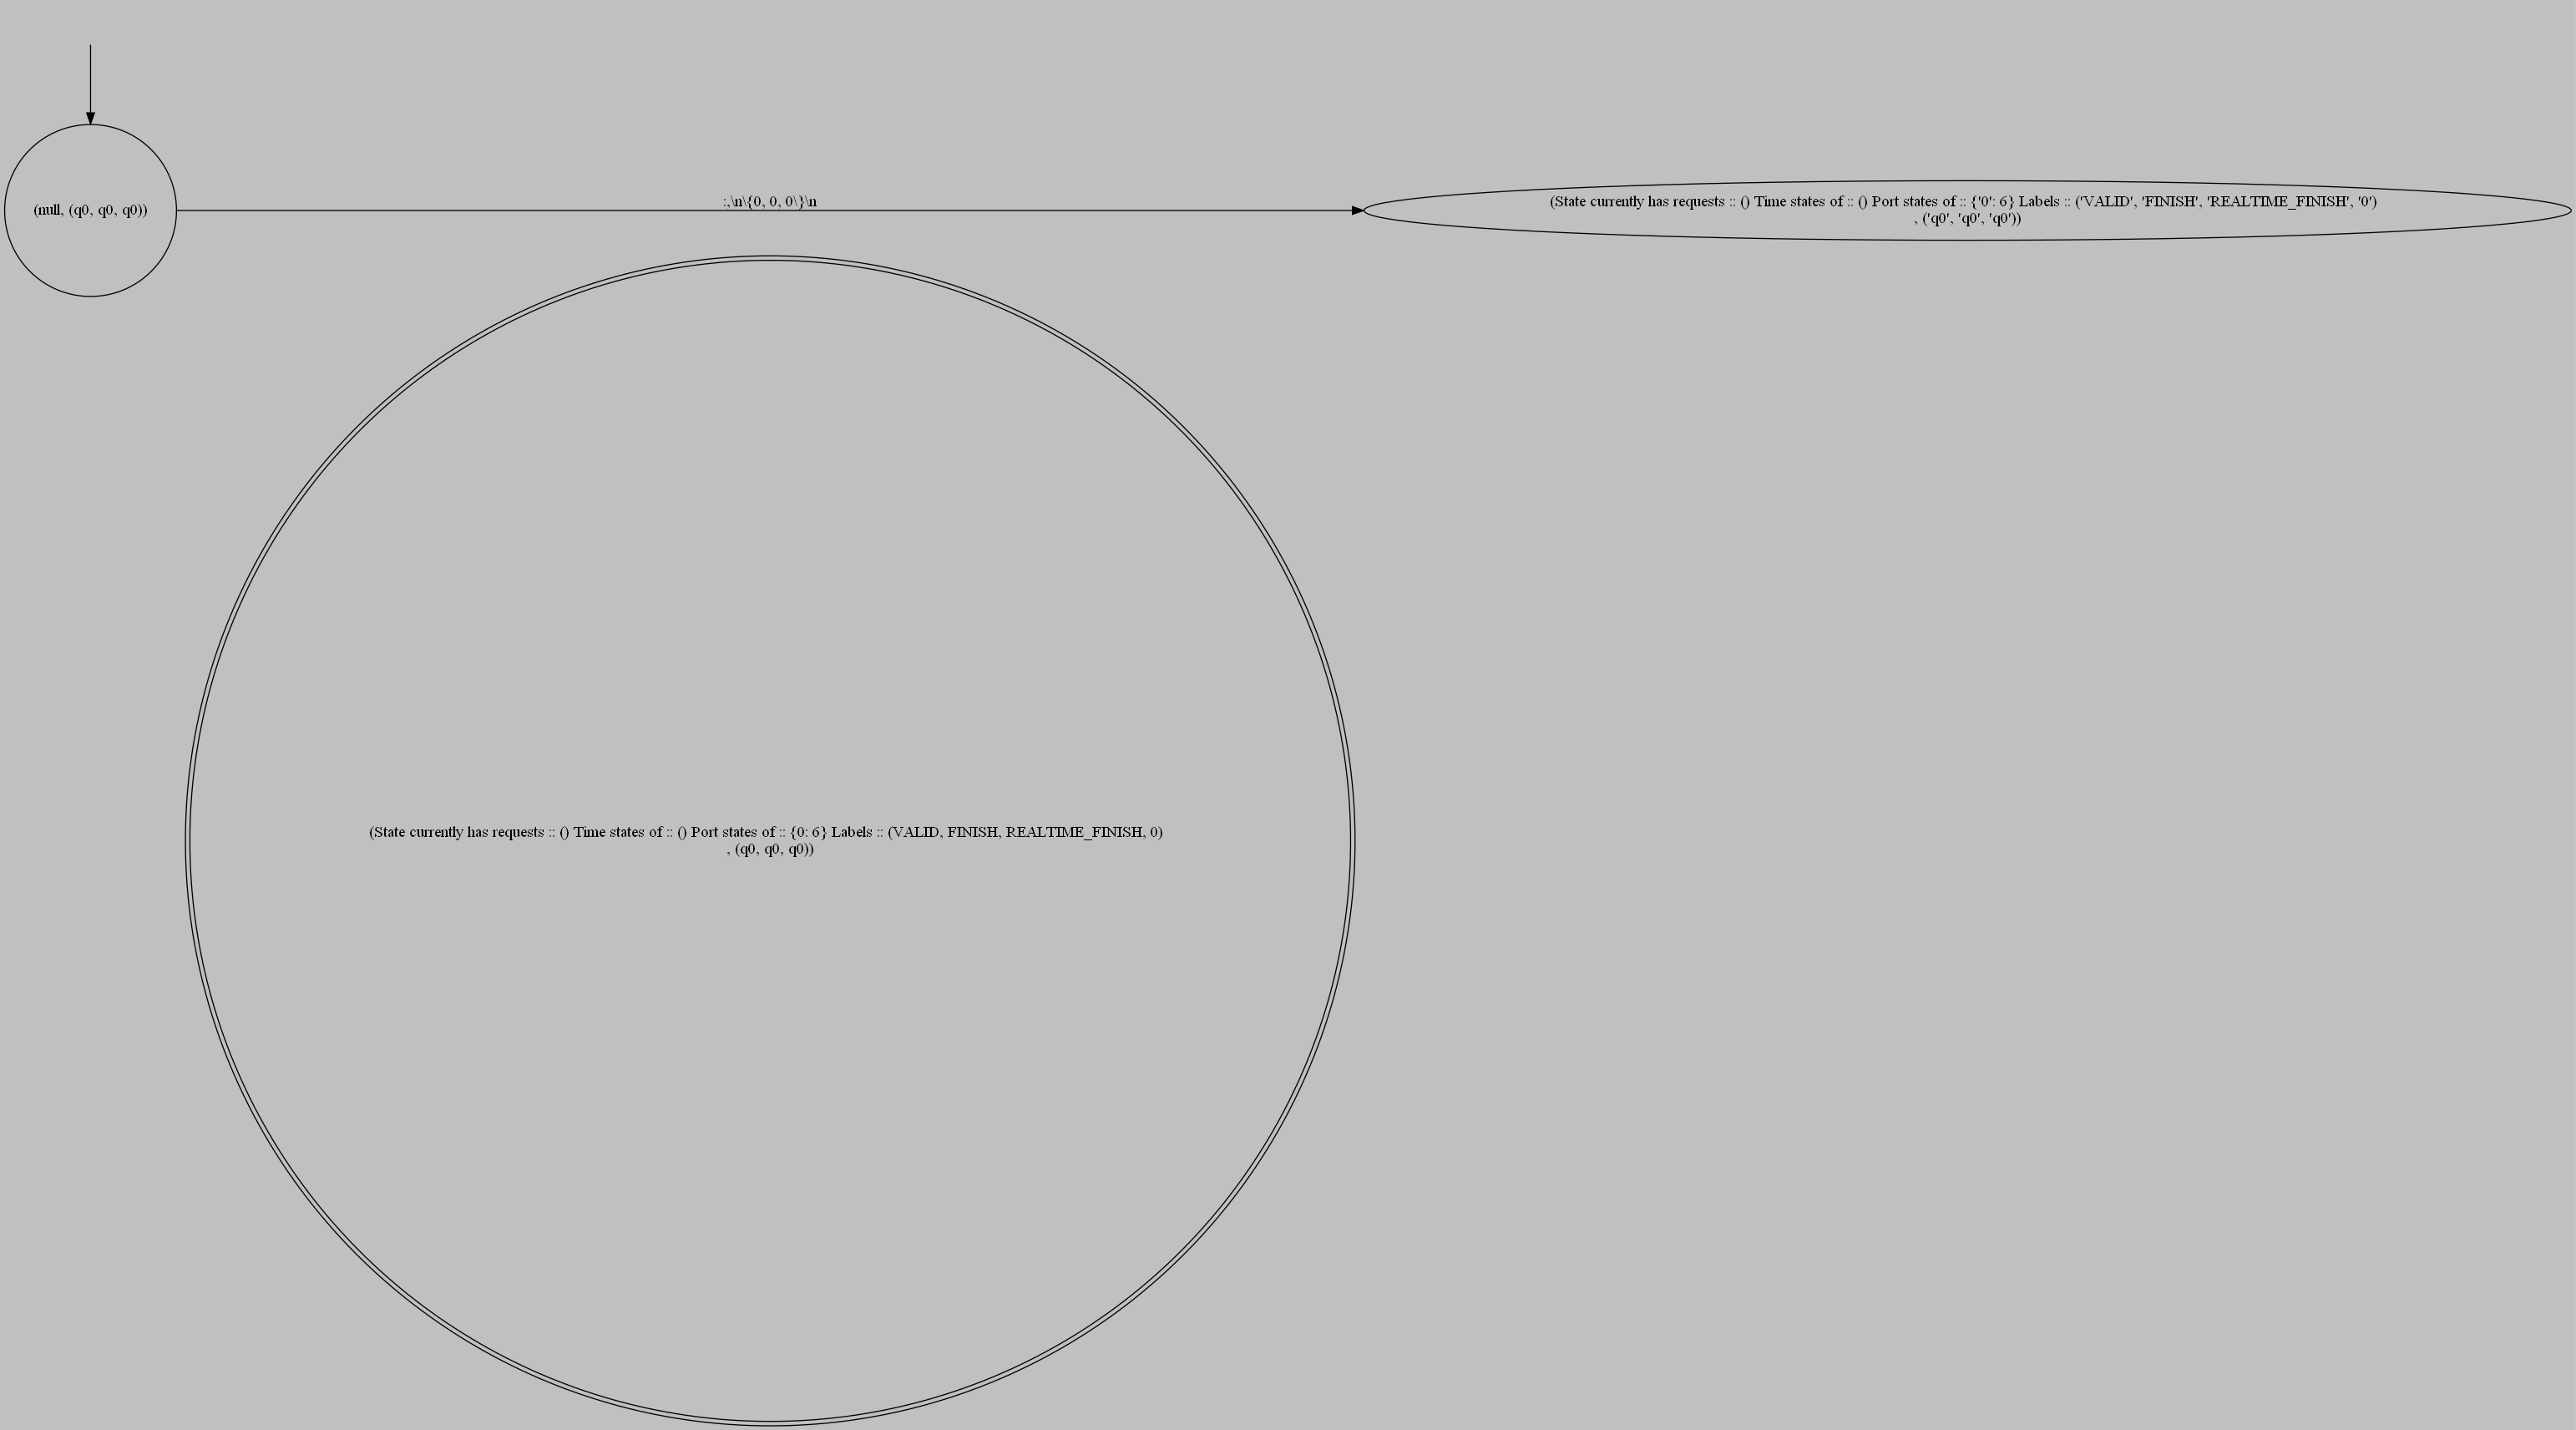

Path cost [0, 0, 0]


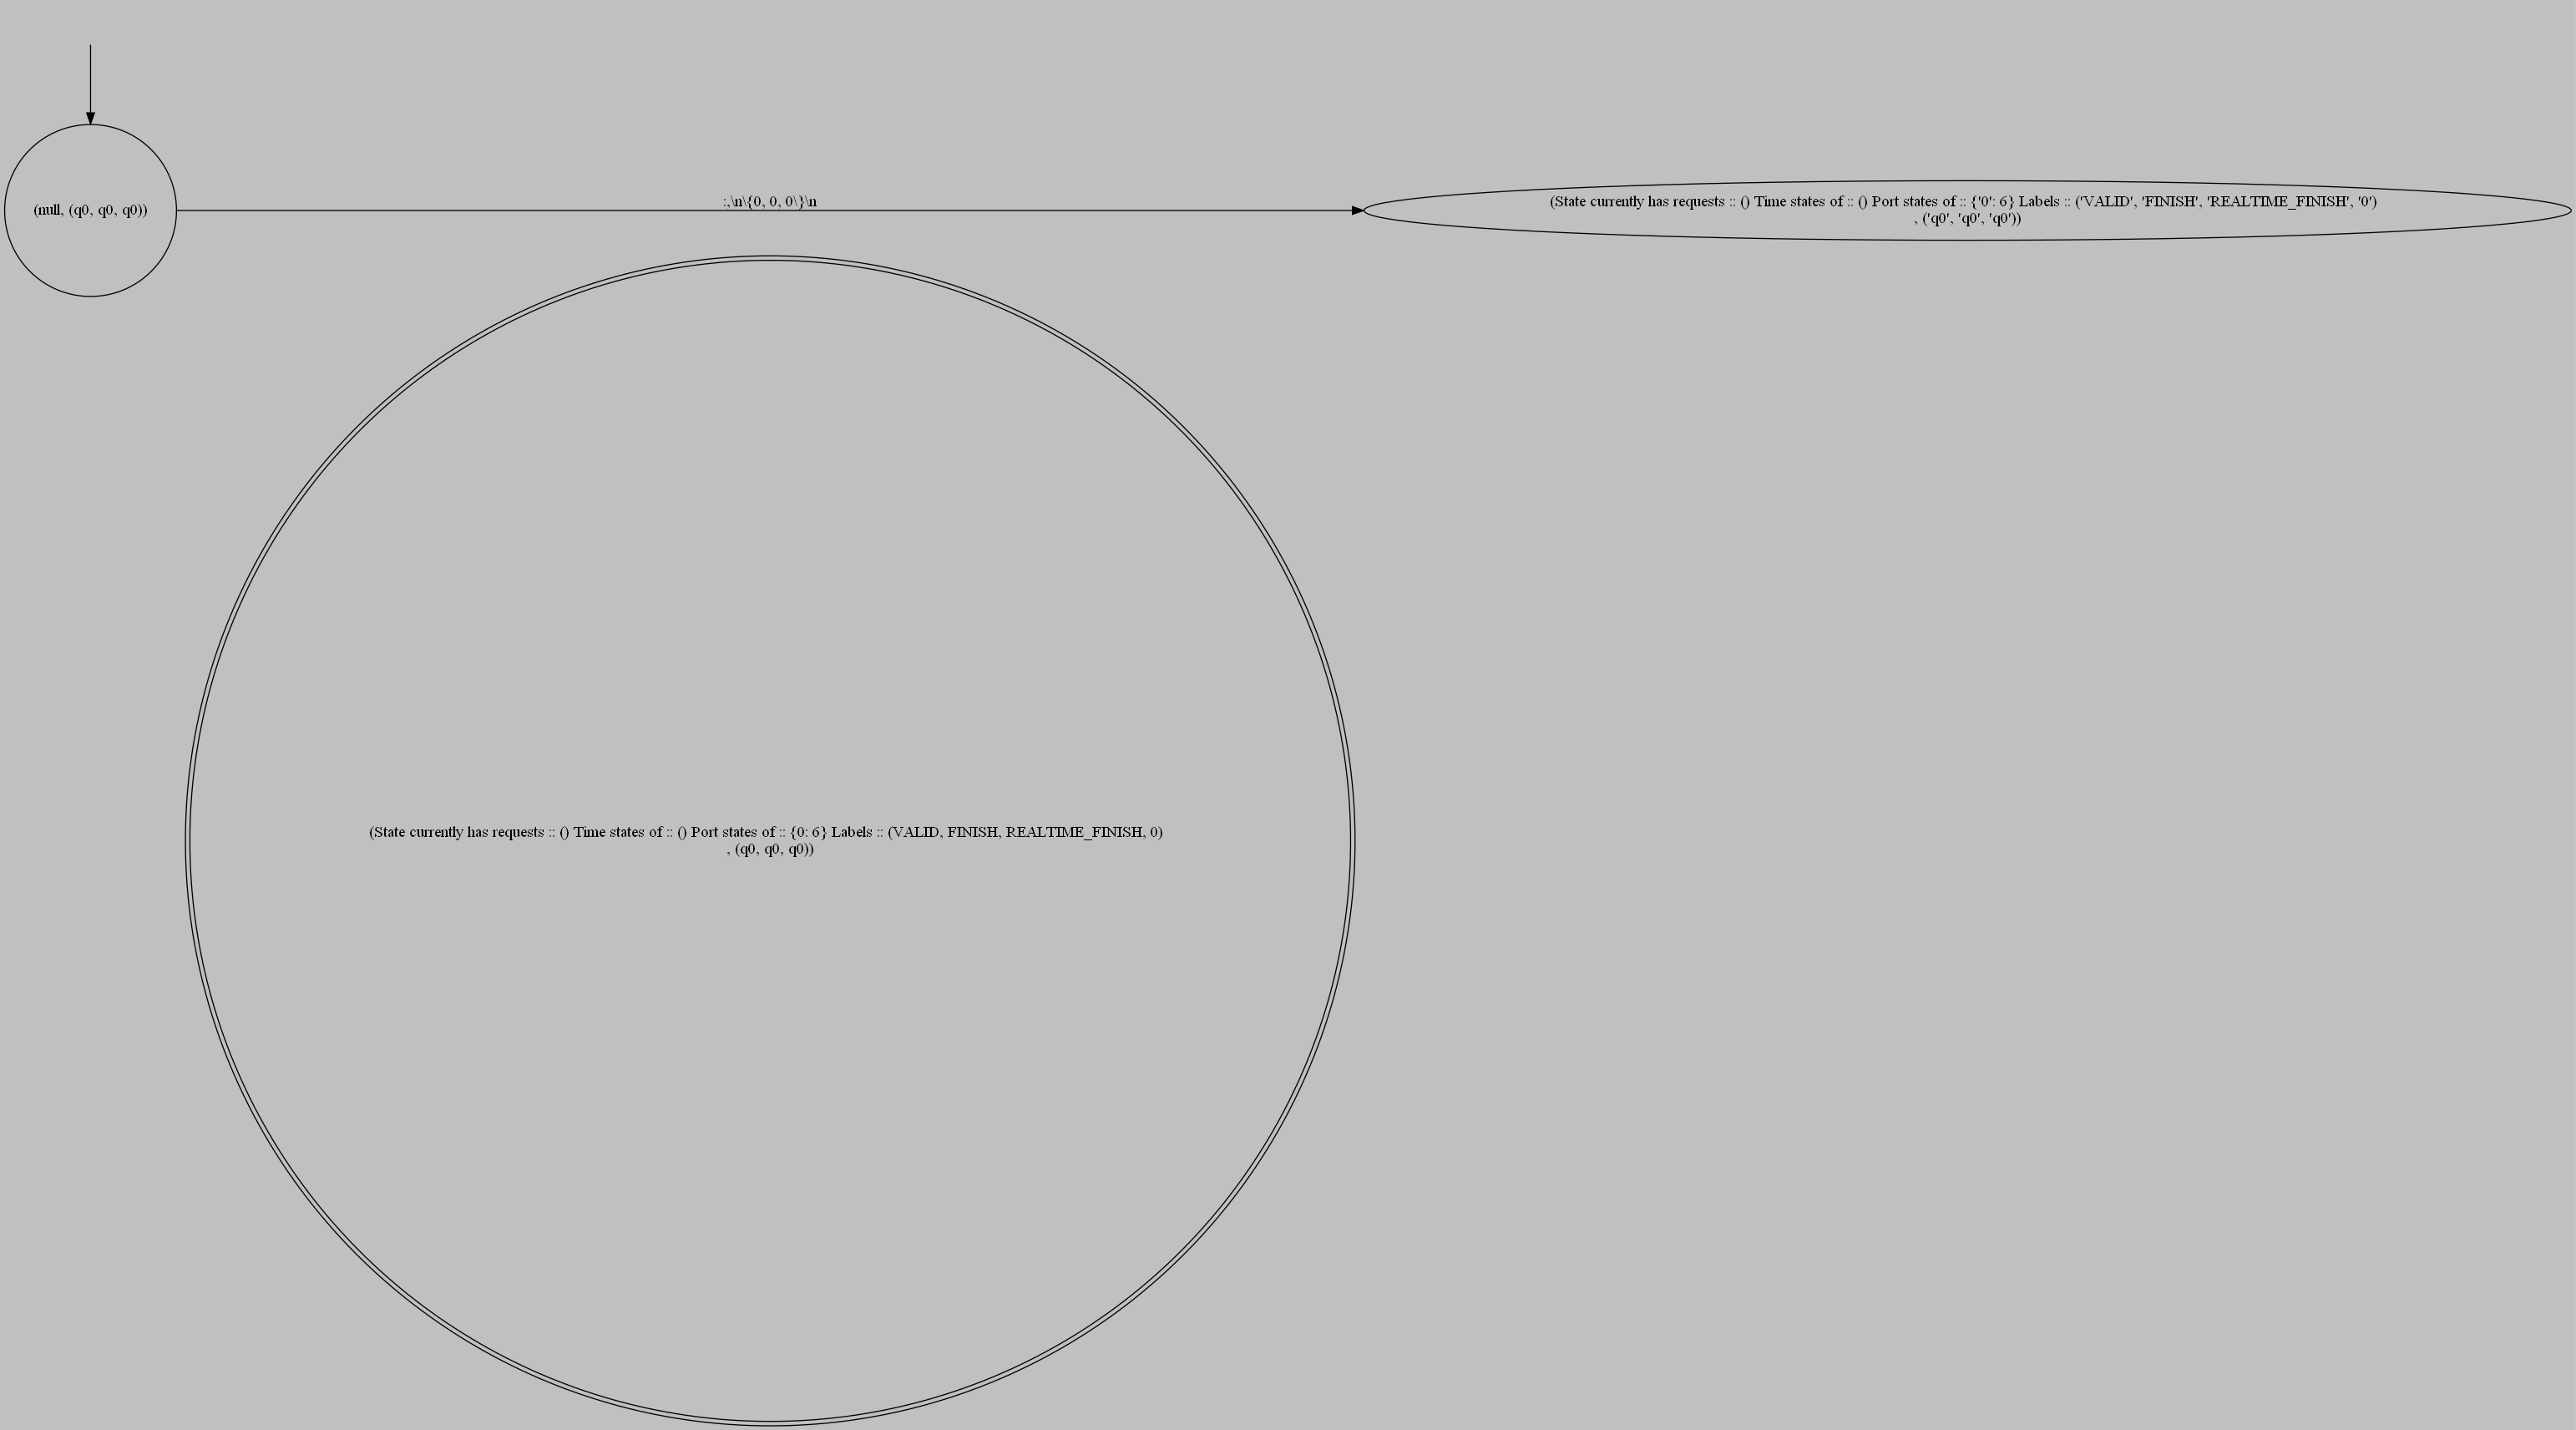

Path cost [0, 0, 0]


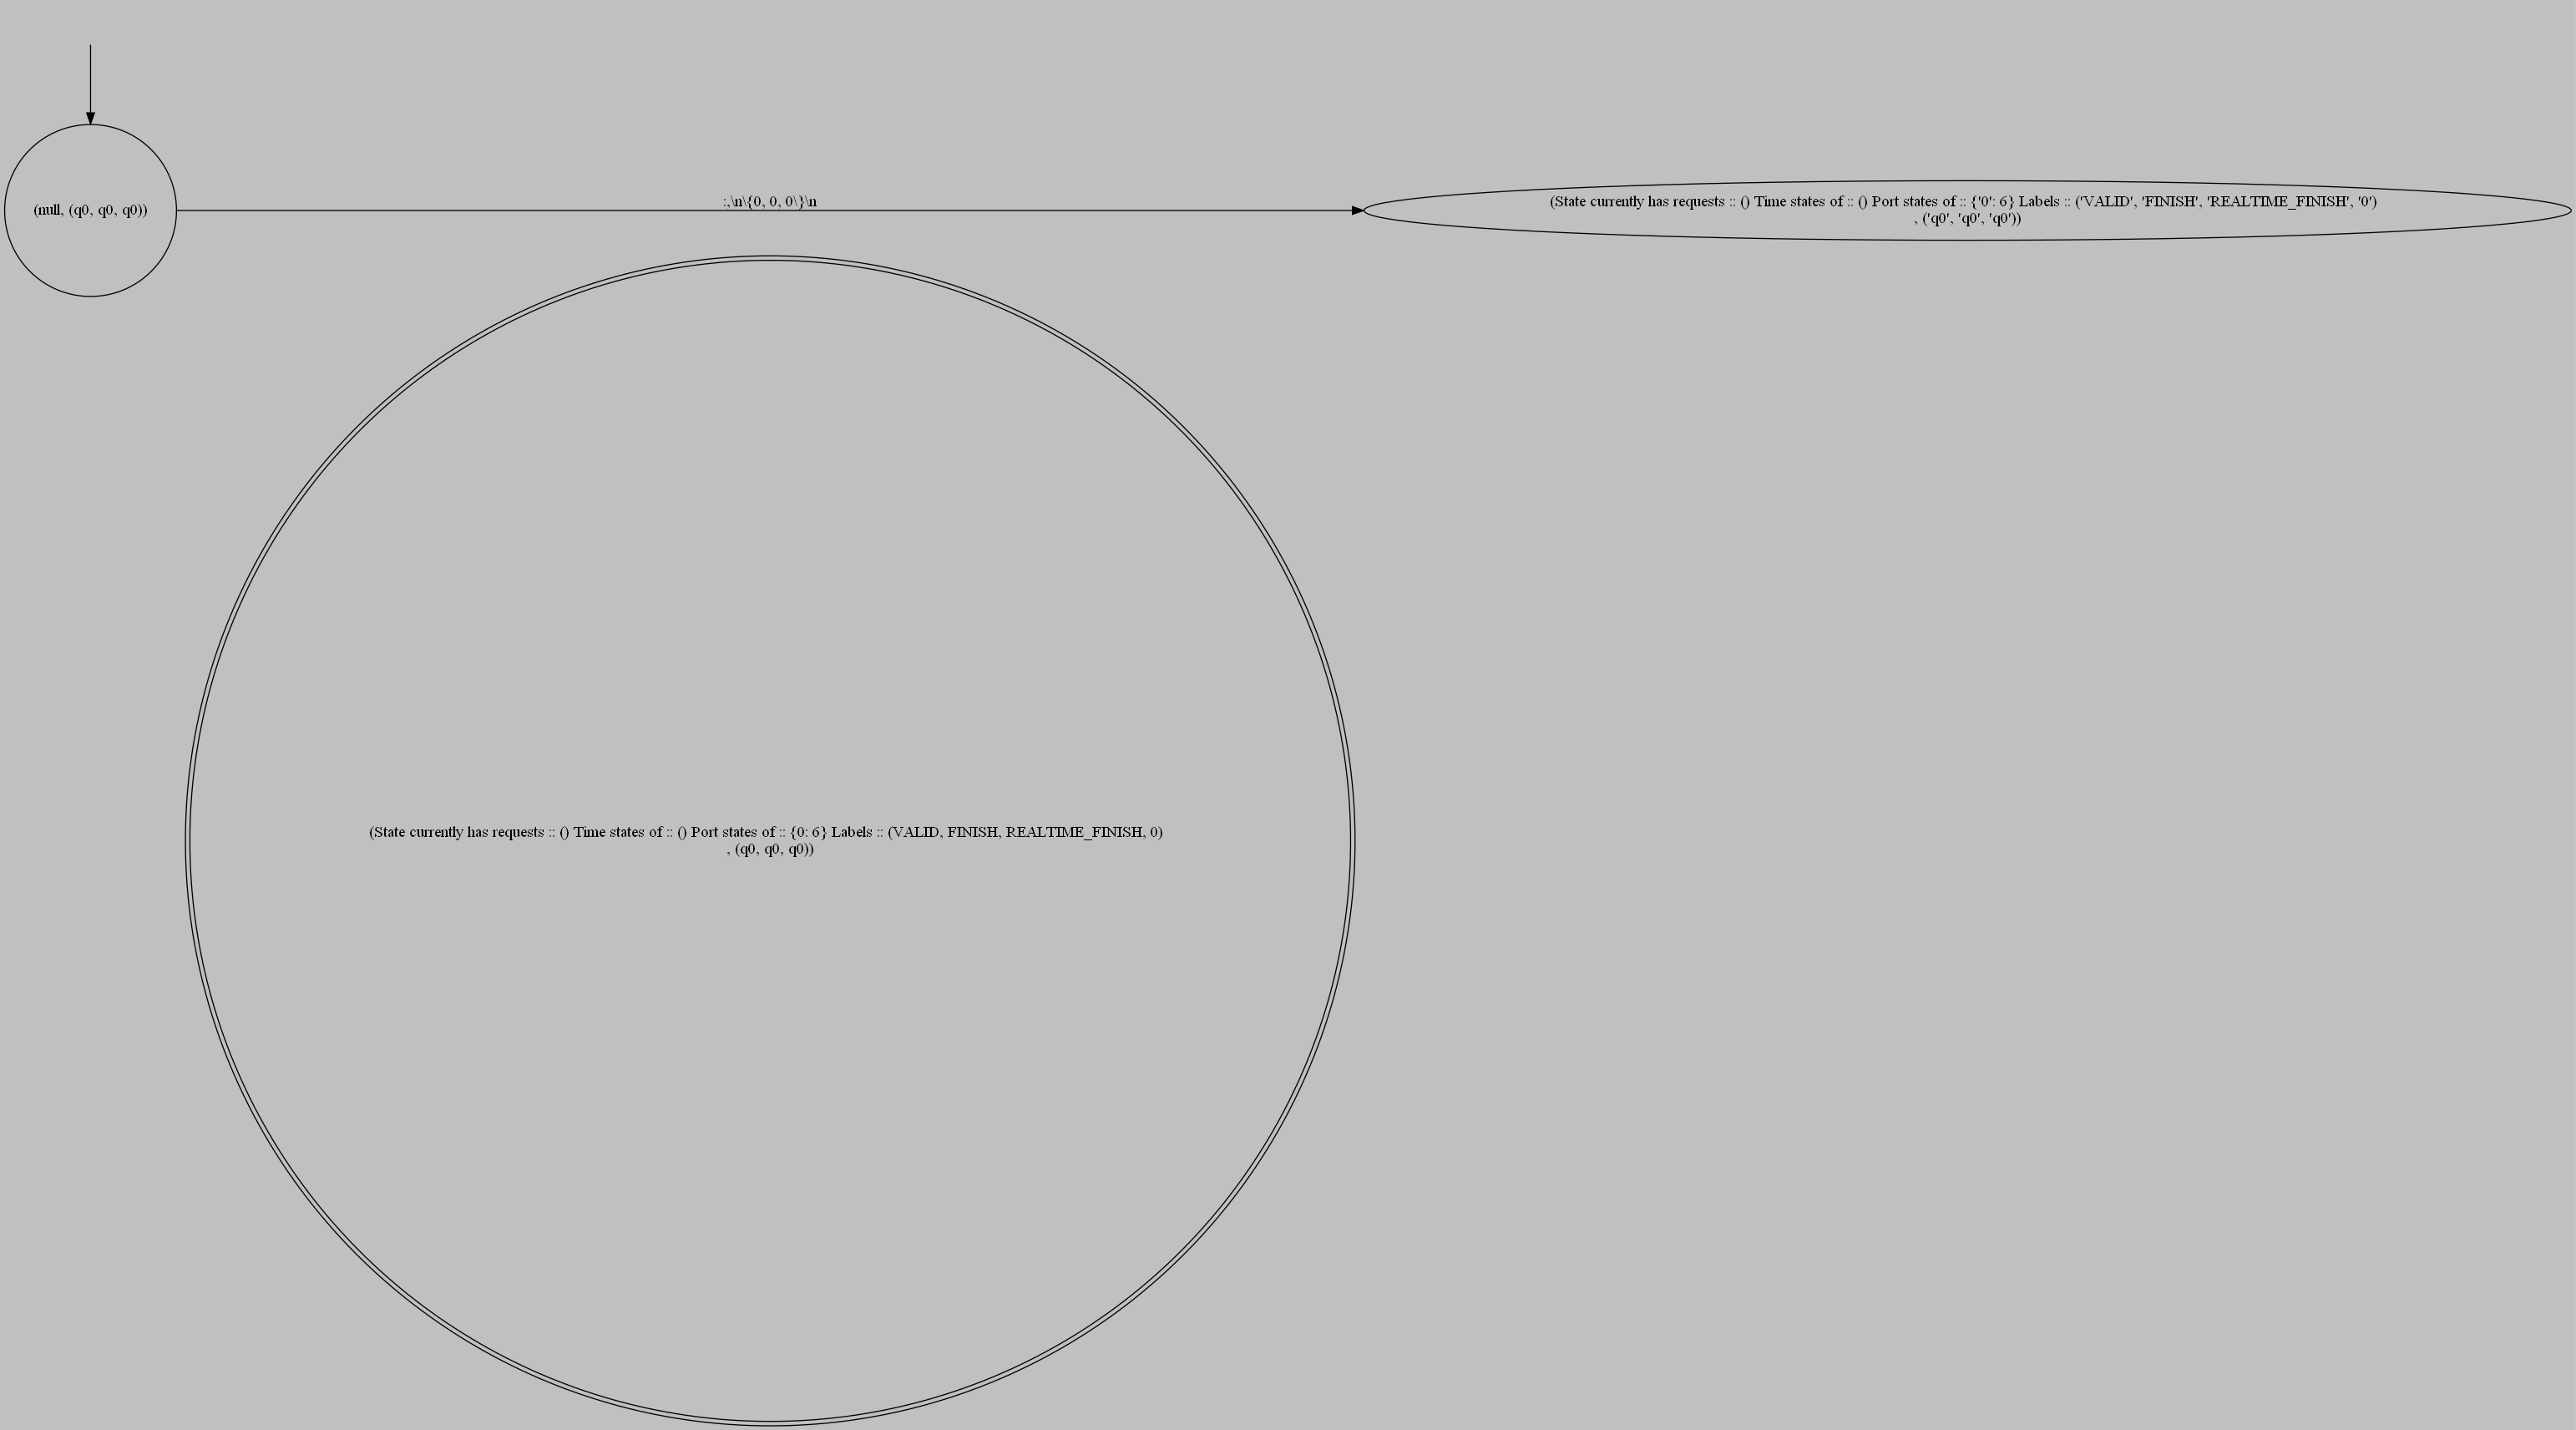

Path cost [0, 0, 0]


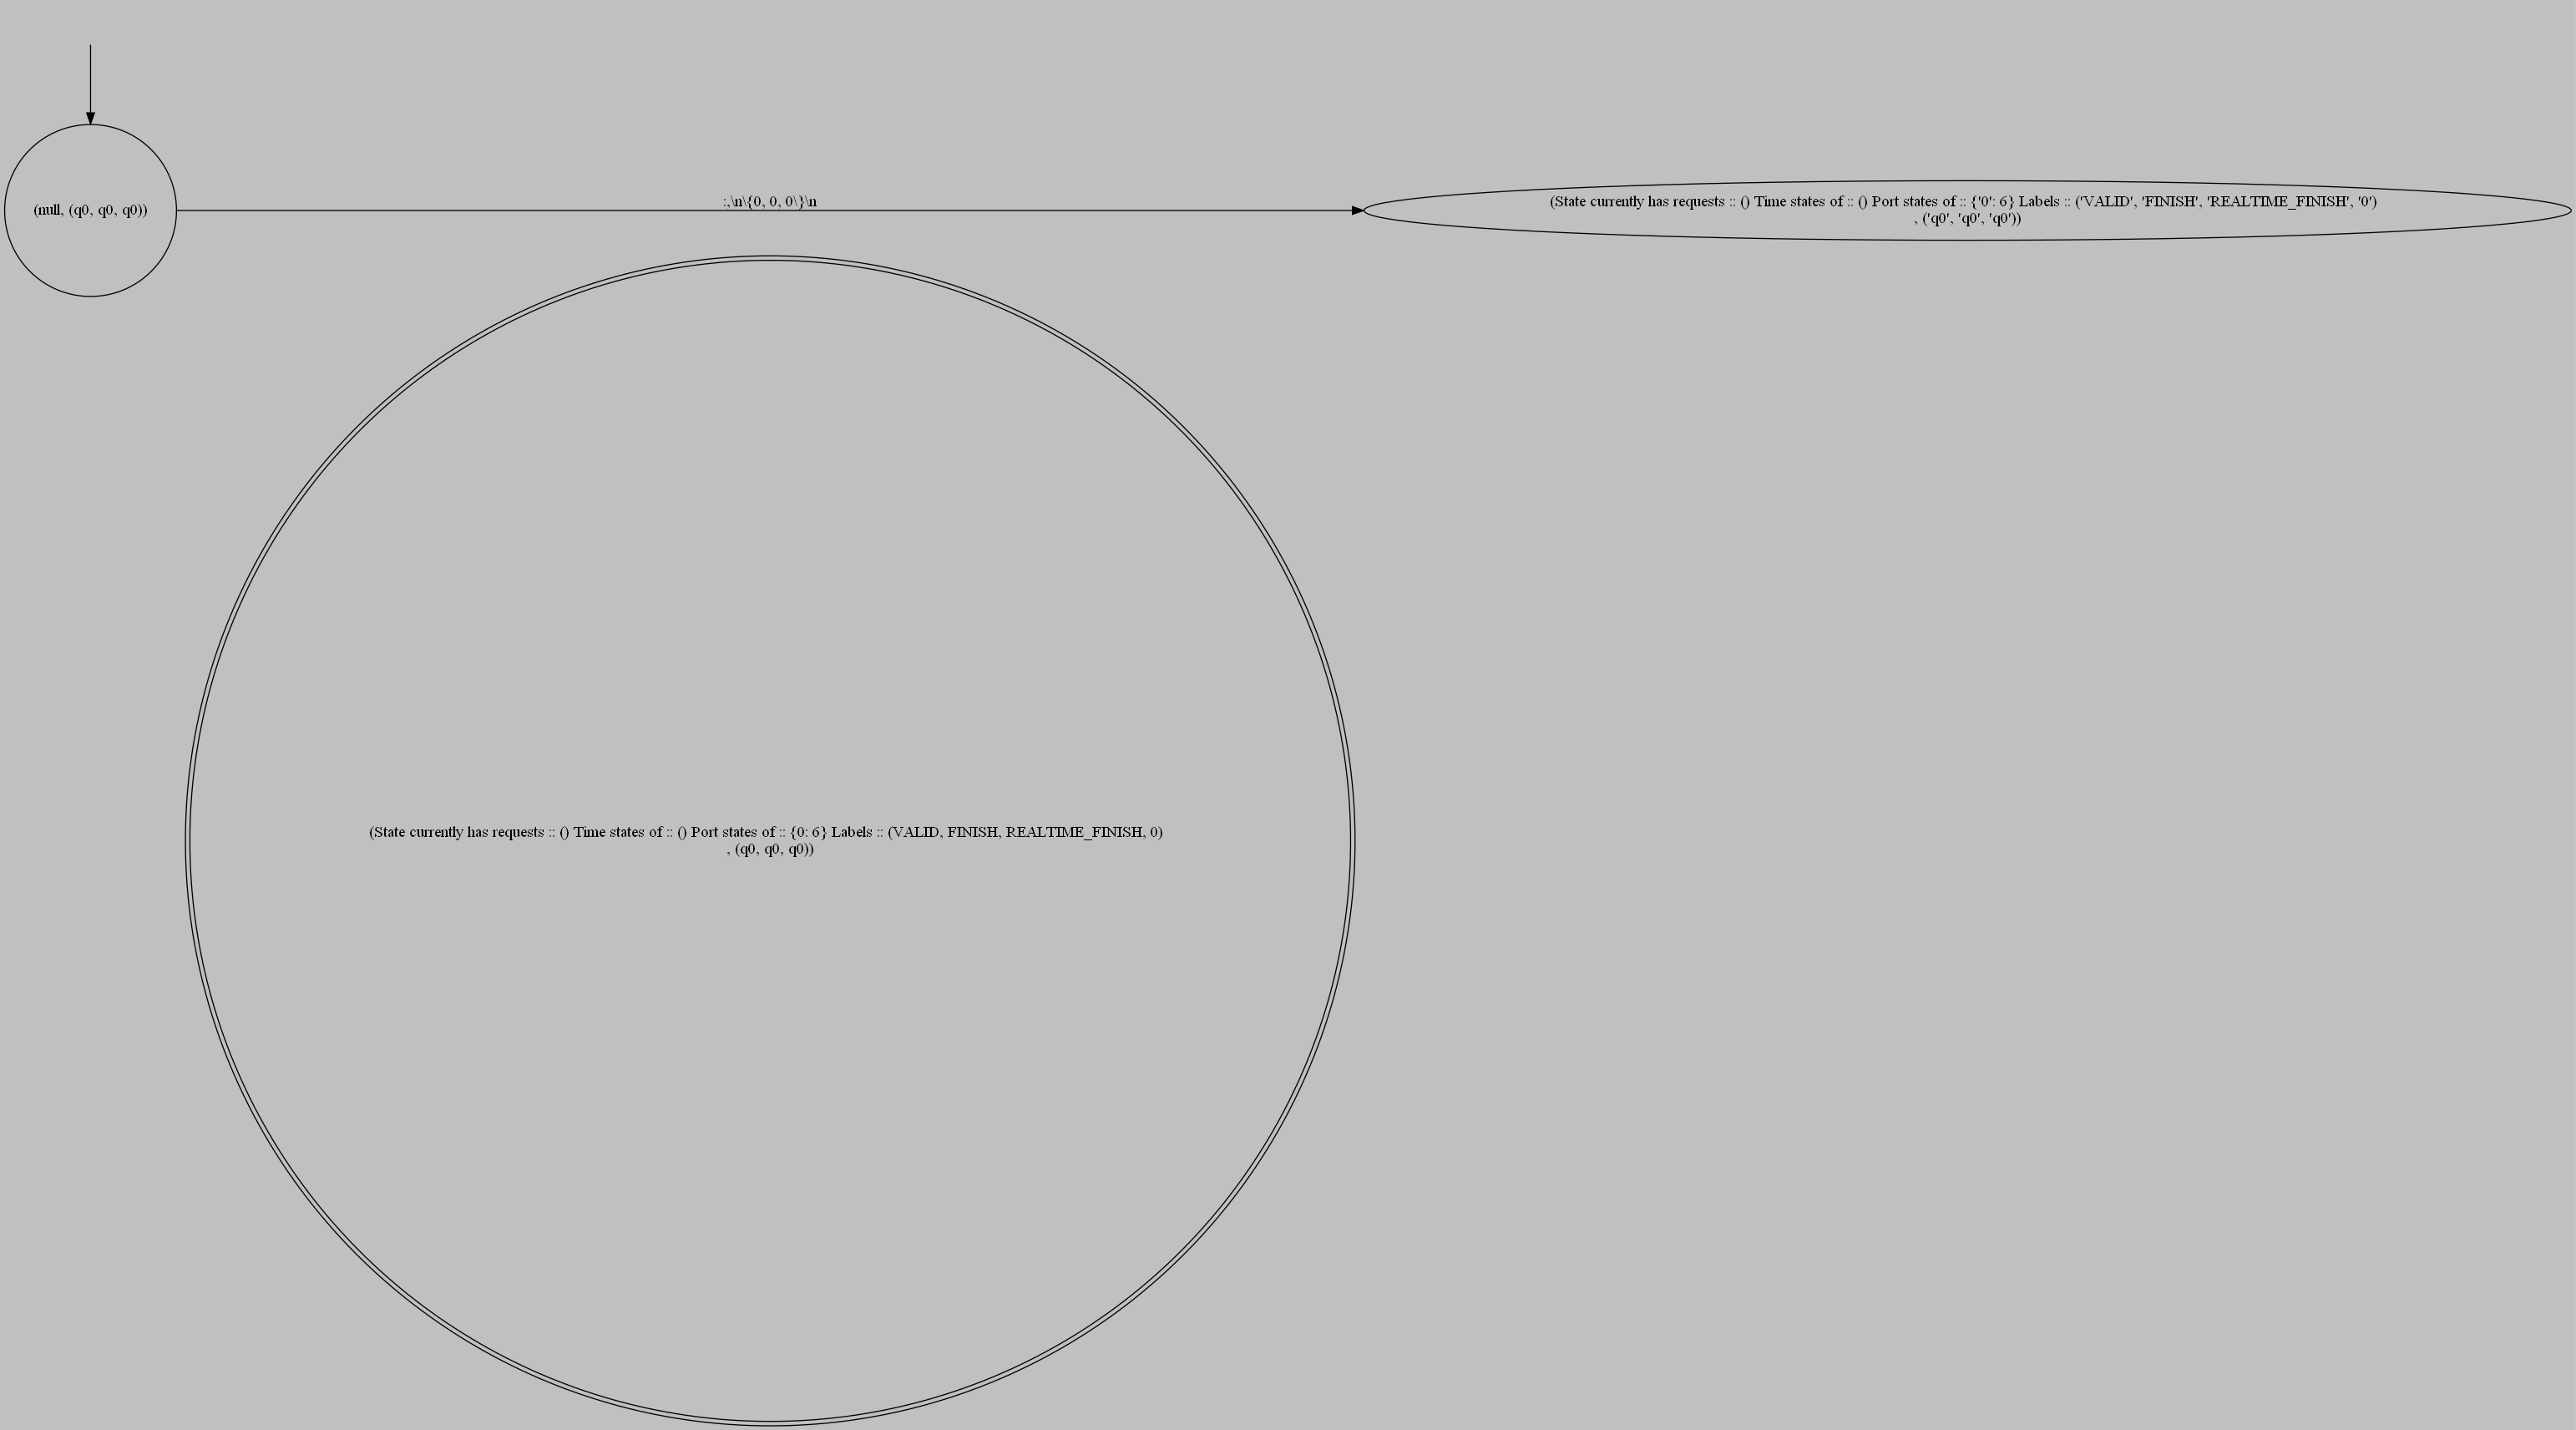

Path cost [0, 0, 0]


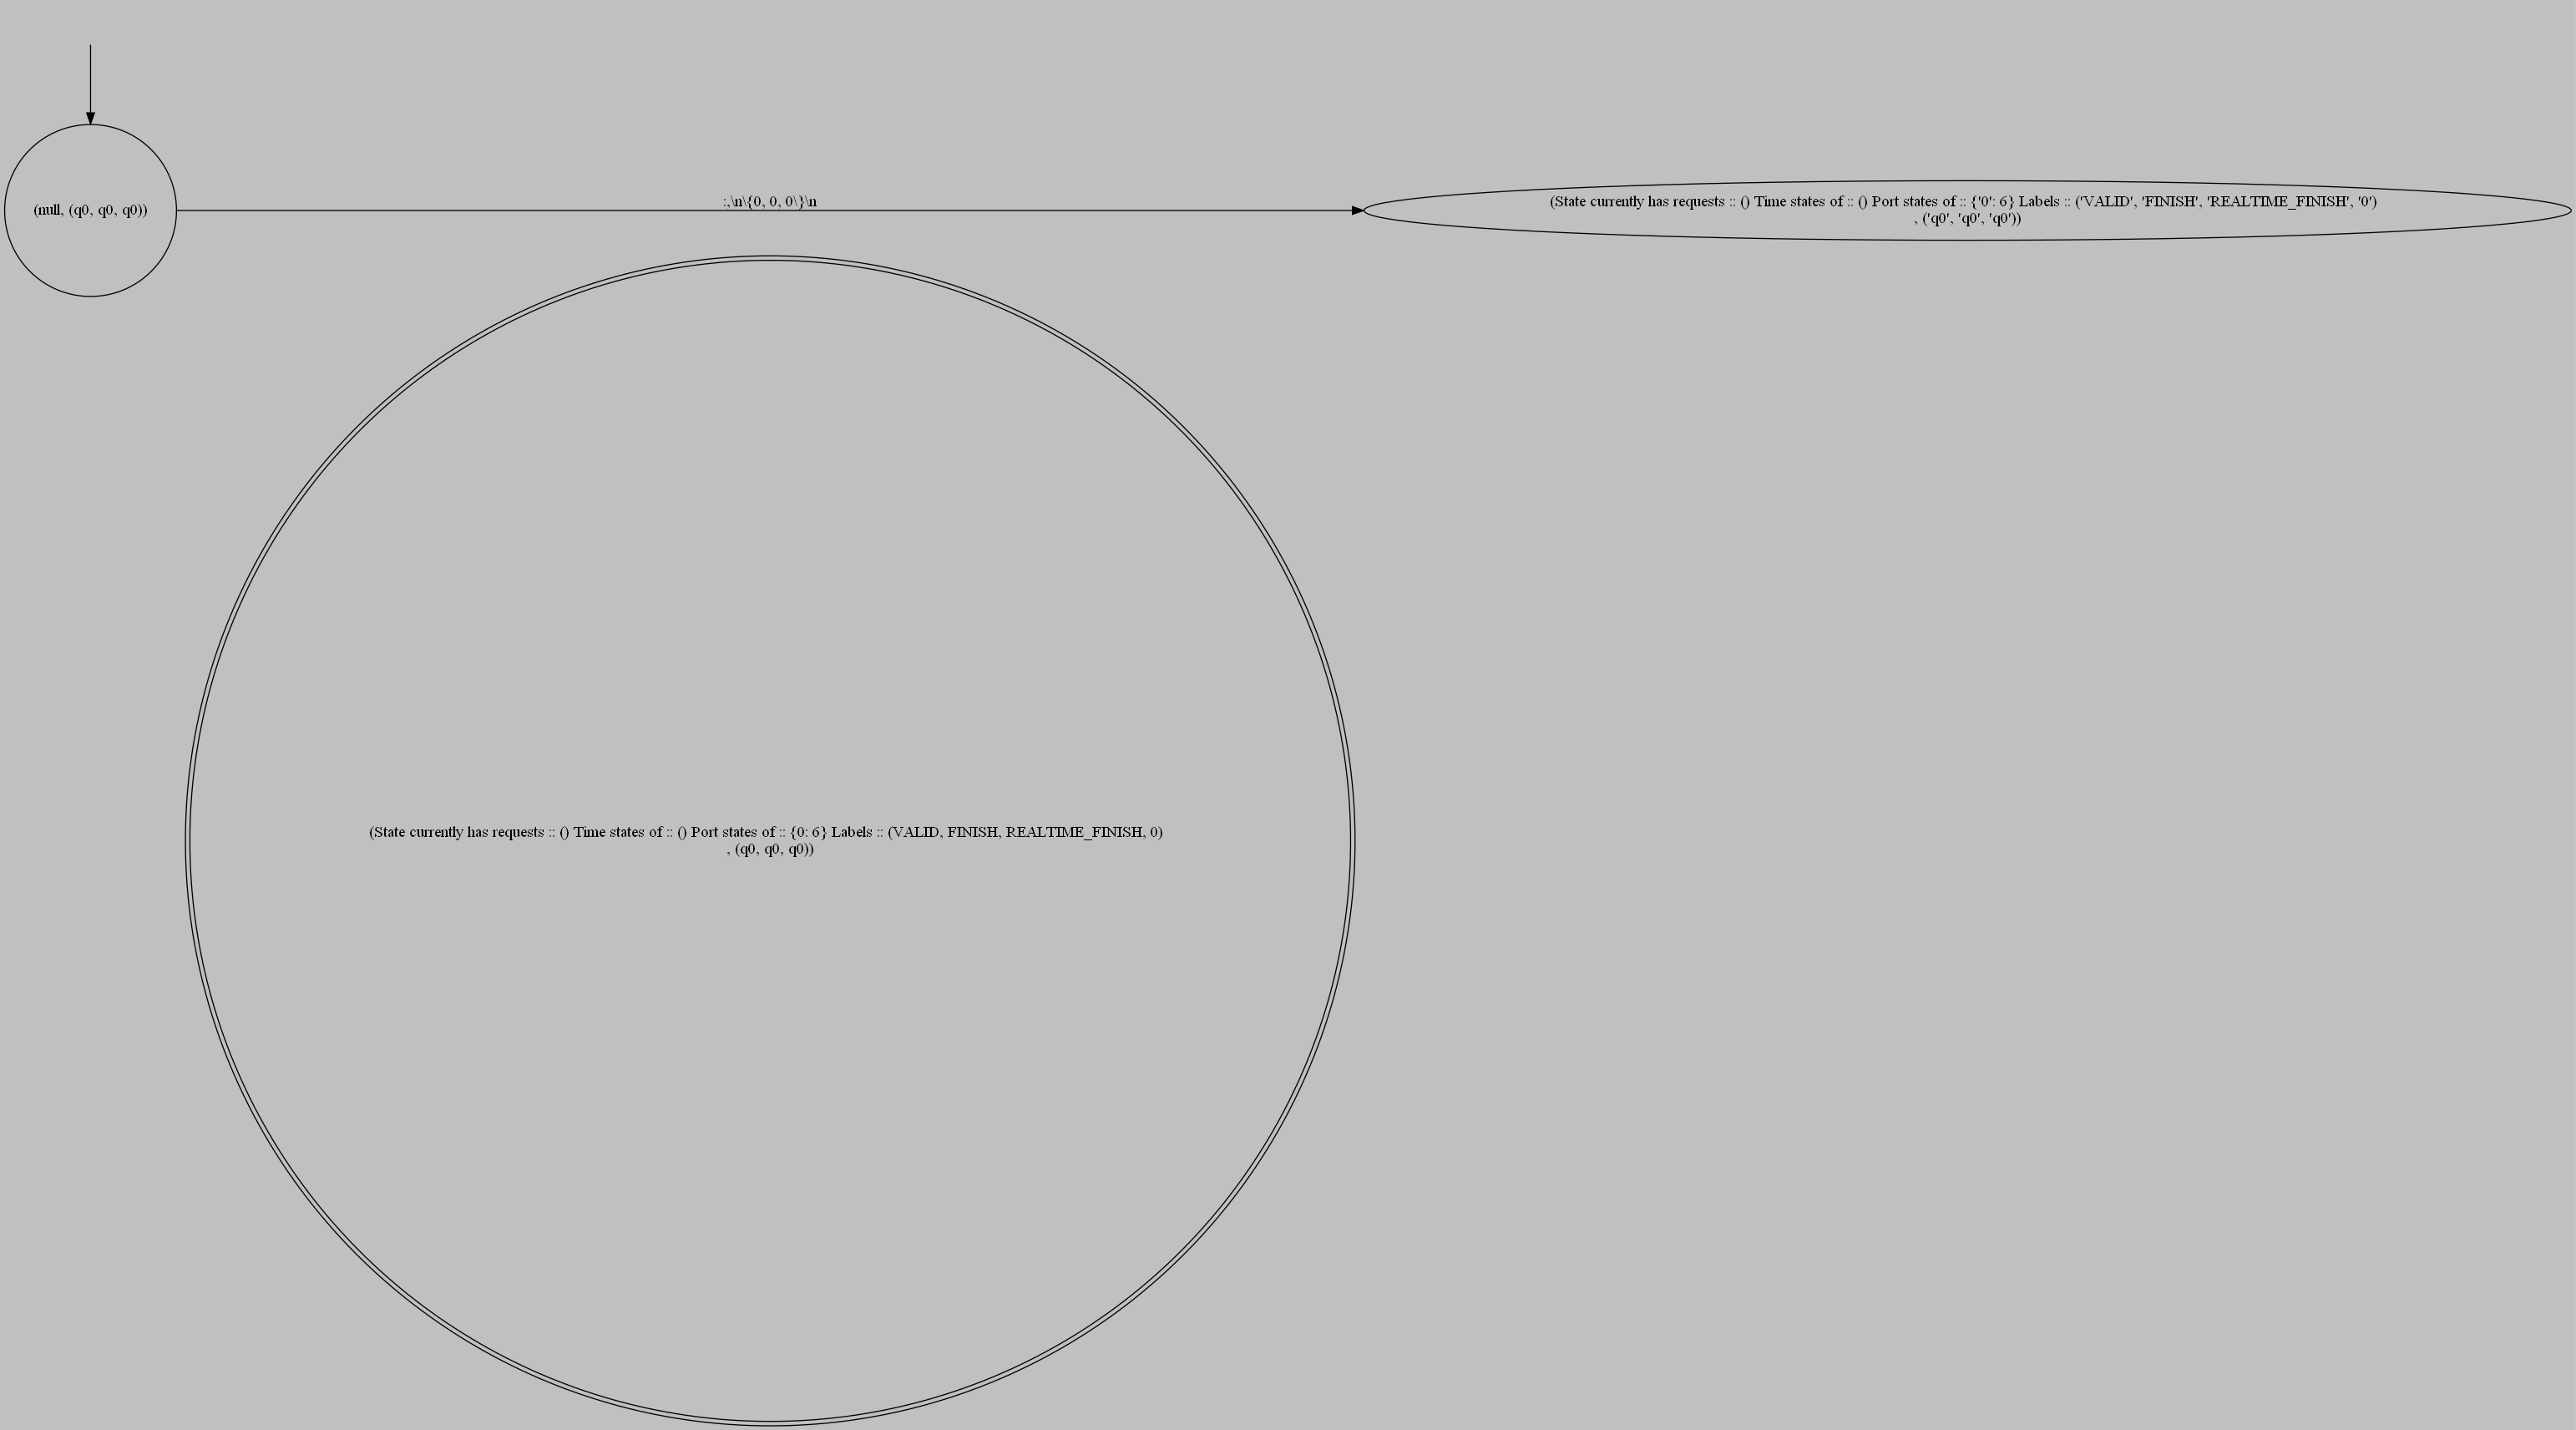

Path cost [0, 0, 0]


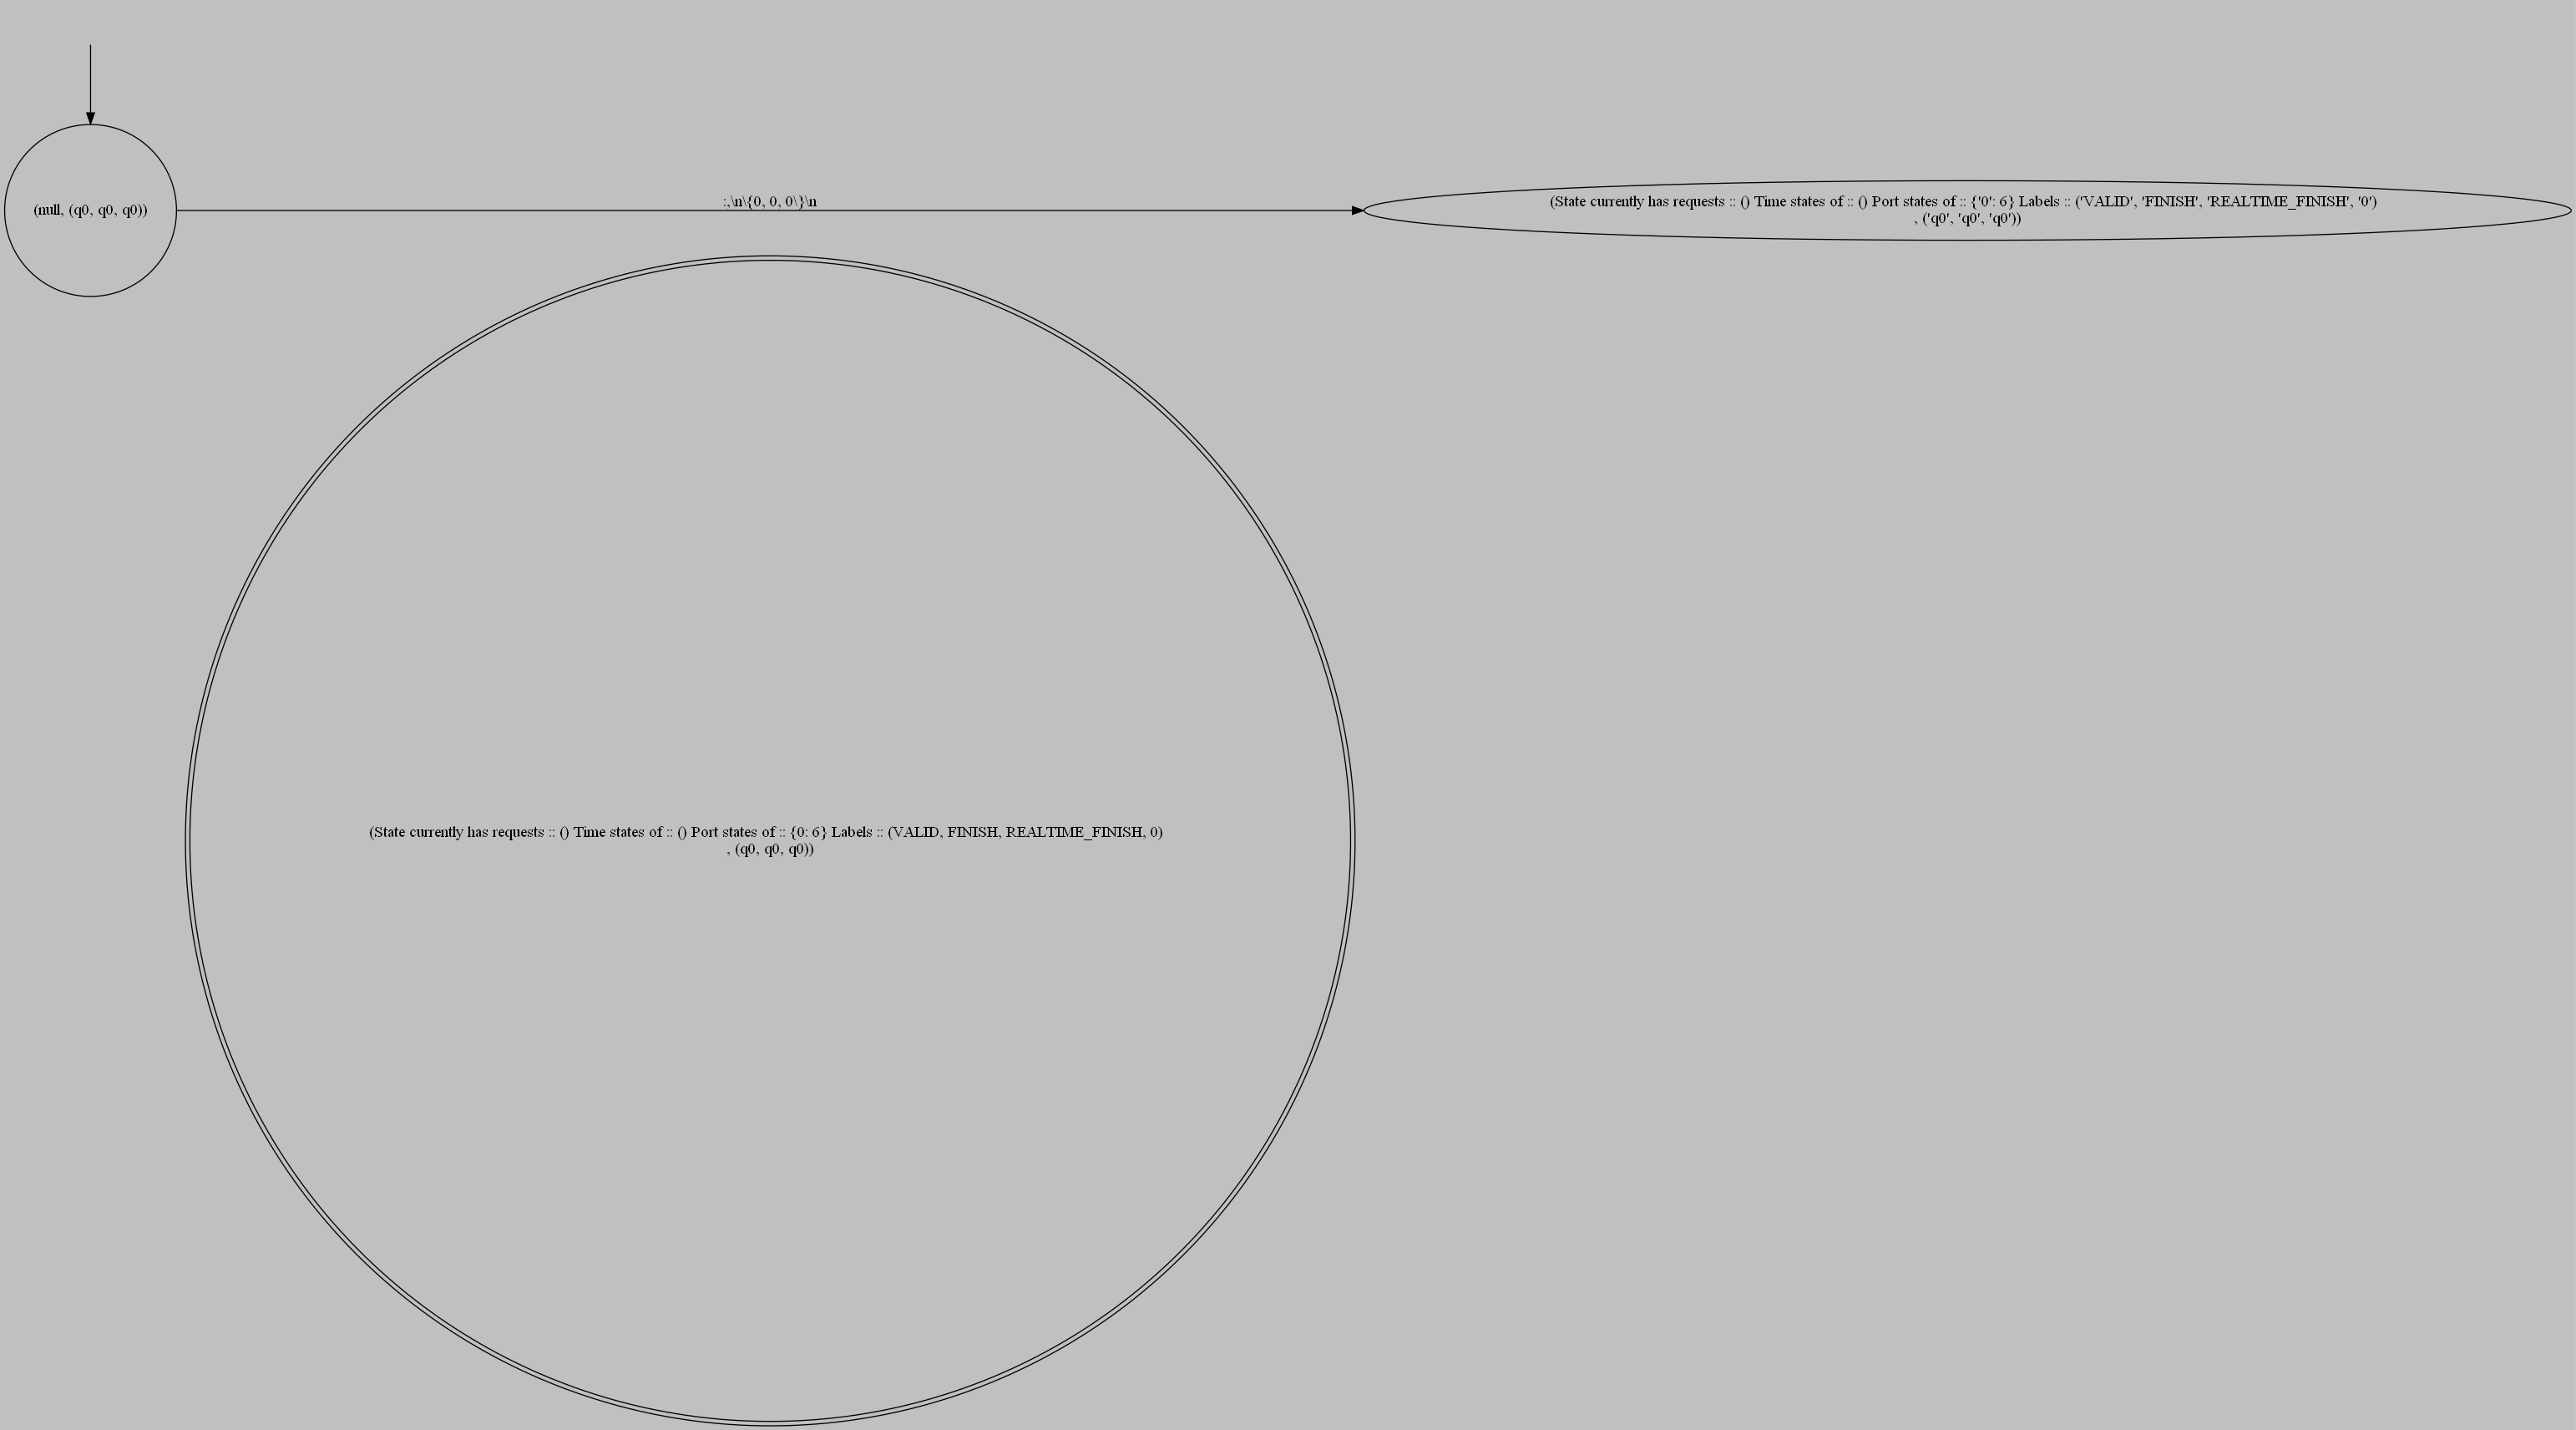

Path cost [0, 0, 0]


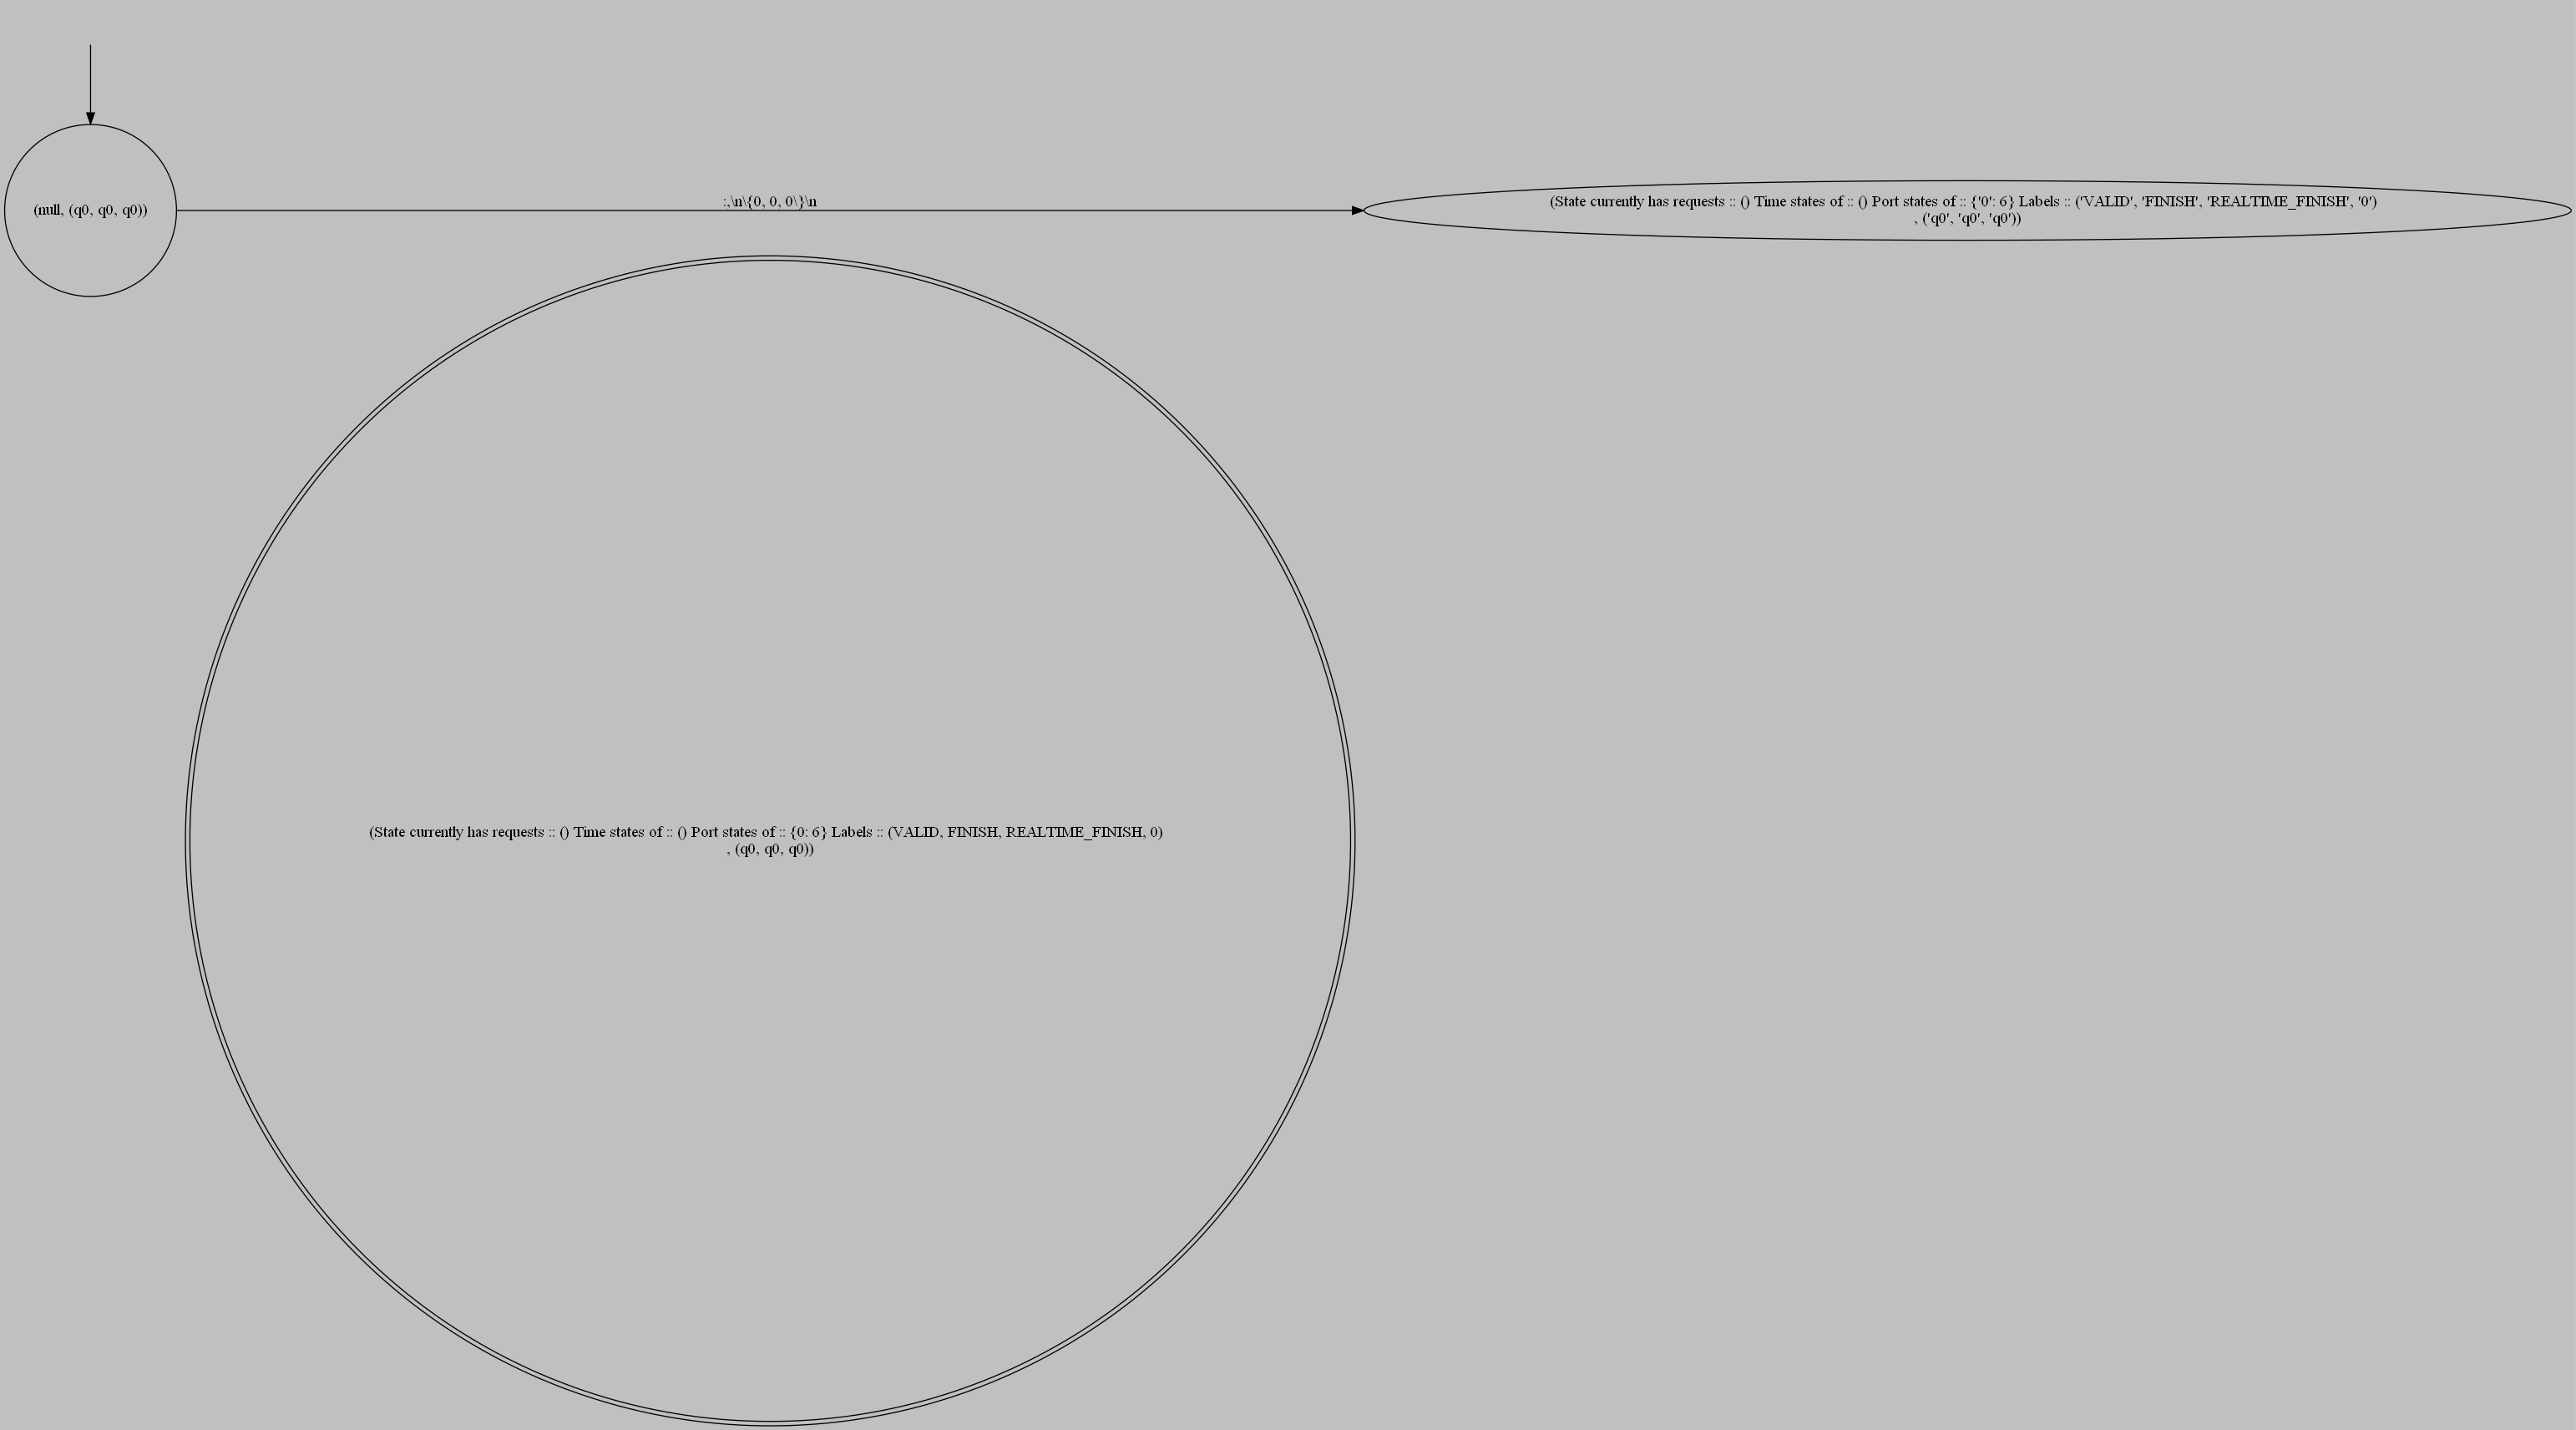

[0.006399499999999891, 0.00433030000000012, 0.0043455999999999495, 0.005832400000000071, 0.007406299999999977, 0.05115610000000004, 0.02417590000000014, 0.01134769999999996, 0.00594579999999989, 0.009845199999999998, 0.0031438999999999773, 0.23436880000000015, 0.12805109999999997, 1.600000000046009e-06, 0.034060200000000096, 0.009460799999999825, 0.03933739999999997, 0.39293829999999996, 0.004340100000000291, 0.006993700000000214, 0.020335800000000237, 1.500000000209667e-06, 0.024573500000000248, 2.5122960000000005, 0.002482700000000726, 1.9735641, 1.1223751000000002, 1.8768335999999994, 0.010601400000000538, 0.1300446000000015, 0.005214099999999888, 0.003330500000000569, 0.018811000000001243, 0.004334099999999452, 0.007424000000000319, 2.573394199999999, 0.0110412999999987, 1.1999999998124622e-06, 0.012395400000000834, 0.016330899999999815, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0]
[0.0]
[0.0]
[0.0]
[0.0]


In [11]:
'''
data buffer for mvp output
'''
percent_valid = [0 for i in range(len(completed_states[0]))]
percent_valid_per_tau = [percent_valid for i in range(TAU_MAX)]
for tau,completed in enumerate(completed_states):
    for index, com in enumerate(completed):
        for state in com:
            if("VALID" in state.labels):
                percent_valid_per_tau[tau][index] += 1

for tower_cost in percent_valid_per_tau:
    print(tower_cost)
mvp_output_per_tower_per_tau_copy = copy.deepcopy(mvp_output_per_tower_per_tau)
for tau in mvp_output_per_tower_per_tau:
    for output in tau:
        gm.print_formatted_cost(output[0],format_override=True)
        output[3].plot()
#     gm.print_formatted_trace_path(output[1])
for timings in timing_info:
    print(timings)